
# Köppen–Geiger lookup

In [ ]:
!pip install kgcPy

from kgcpy import *
import pandas as pd
import os
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

geo_dir = '/content/gdrive/MyDrive/CYL_geo'
df_geo = pd.read_csv(os.path.join(geo_dir, 'CyL_geo.csv'), index_col='Unnamed: 0')
def get_kgc(row):
    return lookupCZ(row['latitude'], row['longitude'])

df_geo["kgc"] = df_geo.apply(get_kgc, axis=1)
KGC_FULL_NAME = {
    "Af": "Tropical rainforest climate",
    "Am": "Tropical monsoon climate",
    "Aw": "Tropical savanna climate",

    "BWh": "Hot desert climate",
    "BWk": "Cold desert climate",
    "BSh": "Hot semi-arid climate",
    "BSk": "Cold semi-arid climate",

    "Csa": "Hot-summer Mediterranean climate",
    "Csb": "Warm-summer Mediterranean climate",
    "Csc": "Cold-summer Mediterranean climate",
    "Cfa": "Humid subtropical climate",
    "Cfb": "Oceanic climate (Marine west coast climate)",
    "Cfc": "Subpolar oceanic climate",

    "Dfa": "Hot-summer humid continental climate",
    "Dfb": "Warm-summer humid continental climate",
    "Dfc": "Subarctic climate",
    "Dfd": "Extremely cold subarctic climate",

    "Dwa": "Monsoon-influenced hot-summer humid continental climate",
    "Dwb": "Monsoon-influenced warm-summer humid continental climate",
    "Dwc": "Monsoon-influenced subarctic climate",
    "Dwd": "Monsoon-influenced extremely cold subarctic climate",

    "Dsa": "Mediterranean-influenced hot-summer humid continental climate",
    "Dsb": "Mediterranean-influenced warm-summer humid continental climate",
    "Dsc": "Mediterranean-influenced subarctic climate",
    "Dsd": "Mediterranean-influenced subarctic climate",

    "ET": "Tundra climate",
    "EF": "Ice cap climate"
}
df_geo["kgc_full"] = df_geo["kgc"].map(KGC_FULL_NAME)
df_geo


Mounted at /content/gdrive


In [ ]:
min_lat = df_geo['latitude'].min()
max_lat = df_geo['latitude'].max()
min_lon = df_geo['longitude'].min()
max_lon = df_geo['longitude'].max()

corners = {
    "lower_left":  (min_lat, min_lon),
    "lower_right": (min_lat, max_lon),
    "upper_right": (max_lat, max_lon),
    "upper_left":  (max_lat, min_lon)
}

print(corners)


{'lower_left': (-6.721713608942912, 40.59005134707985), 'lower_right': (-2.432427861275084, 40.59005134707985), 'upper_right': (-2.432427861275084, 42.74625958504593), 'upper_left': (-6.721713608942912, 42.74625958504593)}


# NDVI

In [ ]:
!pip install earthengine-api
import ee
ee.Authenticate()
ee.Initialize(project='cobalt-vector-480108-j5')


In [ ]:
def get_station_ndvi(lat, lon, start_date='2017-01-01', end_date='2019-12-31'):
    point = ee.Geometry.Point([lon, lat])

    collection = (
        ee.ImageCollection('MODIS/061/MOD13Q1')     # ← UPDATED
        .filterDate(start_date, end_date)
        .select('NDVI')
        .map(lambda img: img.multiply(0.0001).copyProperties(img, img.propertyNames()))
    )

    def extract(img):
        val = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=250,
            bestEffort=True
        ).get('NDVI')
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            'NDVI': val
        })

    features = collection.map(extract).getInfo()["features"]

    rows = []
    for f in features:
        d = pd.to_datetime(f["properties"]["date"])
        v = f["properties"]["NDVI"]
        v = float(v) if v is not None else np.nan
        rows.append((d, v))

    df = pd.DataFrame(rows, columns=['date', 'NDVI'])
    df = df.sort_values("date")
    return df

def align_ndvi_to_station_time(ndvi_df, ts_station):
    ndvi_df = ndvi_df.set_index("date")
    aligned = ndvi_df.reindex(ts_station, method='ffill')
    aligned = aligned.ffill().bfill()
    return aligned["NDVI"].values



## Append NDVI to all files

In [ ]:
import os
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/MyDrive/CYL_GHI/prep_files"
geo_dir  = "/content/gdrive/MyDrive/CYL_geo"

df_geo = pd.read_csv(os.path.join(geo_dir, "stations.csv"))

# Loop through all stations
for idx, row in df_geo.iterrows():

    station_code = row["station_code"]
    lat, lon = row["latitude"], row["longitude"]
    file_path = os.path.join(data_dir, f"{station_code}_prep.csv")

    print(f"\n=== Processing {station_code} ({idx+1}/{len(df_geo)}) ===")

    # 1) Load station file
    df = pd.read_csv(file_path)
    ts = pd.to_datetime(df.iloc[:, 0])   # first column = timestamp

    # 2) Fetch NDVI for station location
    ndvi_df = get_station_ndvi(lat, lon)

    # 3) Align NDVI to station timestamps
    ndvi_values = align_ndvi_to_station_time(ndvi_df, ts)

    # Print min/max of aligned NDVI
    aligned_min = np.nanmin(ndvi_values)
    aligned_max = np.nanmax(ndvi_values)
    print(f"  Aligned NDVI range:      min={aligned_min:.3f}, max={aligned_max:.3f}")

    # 4) Append NDVI column
    df["NDVI"] = ndvi_values

    # 5) Save back
    df.to_csv(file_path, index=False)

    print(f"✓ NDVI added to {station_code}_prep.csv")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

=== Processing BU02 (1/37) ===
  Aligned NDVI range:      min=0.225, max=0.565
✓ NDVI added to BU02_prep.csv

=== Processing LE01 (2/37) ===
  Aligned NDVI range:      min=0.034, max=0.655
✓ NDVI added to LE01_prep.csv

=== Processing P07 (3/37) ===
  Aligned NDVI range:      min=0.232, max=0.755
✓ NDVI added to P07_prep.csv

=== Processing LE02 (4/37) ===
  Aligned NDVI range:      min=0.350, max=0.808
✓ NDVI added to LE02_prep.csv

=== Processing LE06 (5/37) ===
  Aligned NDVI range:      min=0.236, max=0.712
✓ NDVI added to LE06_prep.csv

=== Processing LE07 (6/37) ===
  Aligned NDVI range:      min=0.004, max=0.834
✓ NDVI added to LE07_prep.csv

=== Processing P06 (7/37) ===
  Aligned NDVI range:      min=0.197, max=0.797
✓ NDVI added to P06_prep.csv

=== Processing LE09 (8/37) ===
  Aligned NDVI range:      min=0.150, max=0.583
✓ NDVI added to LE09_pr

## Append NDVI to one file

In [ ]:
import os
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

# --- Paths ---
data_dir = "/content/gdrive/MyDrive/CYL_GHI/prep_files"
geo_dir  = "/content/gdrive/MyDrive/CYL_geo"

# --- Target station ---
station_code = "ZA06"

# --- Load station metadata ---
df_geo = pd.read_csv(os.path.join(geo_dir, "stations.csv"))
row = df_geo[df_geo["station_code"] == station_code].iloc[0]

lat, lon = row["latitude"], row["longitude"]
file_path = os.path.join(data_dir, f"{station_code}_prep.csv")

print(f"\n=== Processing station {station_code} ===")
print(f"Latitude: {lat}, Longitude: {lon}")
print(f"File: {file_path}")

# ------------------------------------------------------------
# 1) Load station CSV
# ------------------------------------------------------------
df = pd.read_csv(file_path)
ts = pd.to_datetime(df.iloc[:, 0])   # timestamp column

print(f"Loaded CSV shape: {df.shape}")

# ------------------------------------------------------------
# 2) Fetch NDVI for this station
# ------------------------------------------------------------
ndvi_df = get_station_ndvi(lat, lon)

# ------------------------------------------------------------
# 3) Align NDVI to timestamps
# ------------------------------------------------------------
ndvi_values = align_ndvi_to_station_time(ndvi_df, ts)

# NDVI stats
print(f"NDVI aligned → min={np.nanmin(ndvi_values):.3f}, max={np.nanmax(ndvi_values):.3f}")

# ------------------------------------------------------------
# 4) Add NDVI column
# ------------------------------------------------------------
df["NDVI"] = ndvi_values

# ------------------------------------------------------------
# 5) Save back
# ------------------------------------------------------------
df.to_csv(file_path, index=False)
print(f"✓ NDVI added to {station_code}_prep.csv")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

=== Processing station ZA06 ===
Latitude: 41.93336407, Longitude: -5.666892155
File: /content/gdrive/MyDrive/CYL_GHI/prep_files/ZA06_prep.csv
Loaded CSV shape: (22995, 24)
NDVI aligned → min=0.213, max=0.579
✓ NDVI added to ZA06_prep.csv


# Installing/Importing Libraries

test

In [ ]:
# let's give Colab access to Google Drive by importing the os and sys libraries
!pip install -q torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 \
    --index-url https://download.pytorch.org/whl/cu124

import os,torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install  -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install  -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install  -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install  -q git+https://github.com/benedekrozemberczki/pytorch_geometric_temporal.git

# Importing libraries
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime,time
from google.colab import drive
from torch_geometric.utils import dense_to_sparse
import torch.nn as nn
import torch.nn.functional as Func
from pyproj import Geod
from torch_geometric_temporal.nn.recurrent import GConvGRU
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import PairNorm
from sklearn.feature_selection import mutual_info_regression
import random
from statistics import mean, stdev
from itertools import product


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# Data importing

## version 2

In [ ]:
# --- Colab mount ---
from google.colab import drive
drive.mount('/content/gdrive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

geo_dir = '/content/gdrive/MyDrive/CYL_geo'
data_dir = '/content/gdrive/MyDrive/CYL_GHI/prep_files'

df_geo = pd.read_csv(os.path.join(geo_dir, 'stations.csv'))
station_files = df_geo['station_code'].tolist()

#building static terrain features
vars_geo = df_geo[["height", "Slope_DEM2_U1", "Aspect_DEM2_1", "rastercalc"]].rename(columns={'Slope_DEM2_U1': 'slope','Aspect_DEM2_1': 'aspect',
        'rastercalc': 'twi'}
)
# Convert aspect to radians (ArcGIS aspect is in degrees 0–360)
aspect_rad = np.deg2rad(vars_geo['aspect'])

# Replace aspect field with sin/cos components
vars_geo['aspect_cos'] = np.cos(aspect_rad)
vars_geo['aspect_sin'] = np.sin(aspect_rad)

# Drop the original angular aspect column
vars_geo = vars_geo.drop(columns=['aspect'])

# normalize static features
geo_scaler = MinMaxScaler()
vars_geo_scaled = geo_scaler.fit_transform(vars_geo)
vars_geo = pd.DataFrame(vars_geo_scaled, columns=vars_geo.columns)

loading_flag = True  # switch to False to rebuild preprocessing

# ================================================================
# === 3. Load or Build Dataset
# ================================================================
if loading_flag:
    # --- Load preprocessed ---
    files_to_load = {
        'node_tensor': os.path.join(data_dir, 'node_tensor2.npz'),
        'target_tensor': os.path.join(data_dir, 'target_tensor2.npz'),
        'columns': os.path.join(data_dir, 'columns2.npz'),
        'masks': os.path.join(data_dir, 'masks2.npz'),
    }

    loaded_data = {}
    for name, path in files_to_load.items():
        try:
            loaded_data[name] = np.load(path, allow_pickle=True)
            print(f"✅ Loaded: {name}")
        except FileNotFoundError:
            print(f"❌ File not found: {path}")

    temporal_node_tensor = loaded_data['node_tensor']['data']
    temporal_target_tensor = loaded_data['target_tensor']['data']
    df_cols = loaded_data['columns']['data']

    if 'masks' in loaded_data:
        masks_file = loaded_data['masks']
        masks = {k: masks_file[k] for k in masks_file.files}
    else:
        masks = None

else:
    # --- Build from scratch ---
    df_list, target_list = [], []

    for station_file in station_files:
        df = pd.read_csv(os.path.join(data_dir, f"{station_file}_prep.csv"))

        # --- Time encodings ---
        ts = pd.to_datetime(df.iloc[:, 0])
        doy = ts.dt.dayofyear
        tod = ts.dt.hour * 3600 + ts.dt.minute * 60 + ts.dt.second

        df = df.assign(
            doy_sin=np.sin(2 * np.pi * doy / 365),
            doy_cos=np.cos(2 * np.pi * doy / 365),
            tod_sin=np.sin(2 * np.pi * tod / 86400),
            tod_cos=np.cos(2 * np.pi * tod / 86400),
            wind_dir_sin=lambda x: np.sin(np.radians(x['wind_dir'])),
            wind_dir_cos=lambda x: np.cos(np.radians(x['wind_dir'])),
            sun_azim_sin=lambda x: np.sin(np.radians(x['sun_azim'])),
            sun_azim_cos=lambda x: np.cos(np.radians(x['sun_azim']))
        )

        # Drop raw azimuth but keep wind_dir last
        df = df.drop(columns=['sun_azim'])
        cols = [c for c in df.columns if c != "wind_dir"] + ["wind_dir"]
        df = df[cols]

        # Features & target
        features = df.iloc[:, 1:]    # drop timestamp
        target = df["GHI"].values

        df_list.append(features)
        target_list.append(target)

    df_cols = df.columns[1:]
    temporal_node_tensor = np.stack(df_list, axis=1)
    temporal_target_tensor = np.stack(target_list, axis=1)

    # --- Normalize input (features) ---
    # Identify columns to normalize (exclude categorical and one-hot)
    non_norm_features = [
        "meteo_cat",  # added later, but ensure excluded if exists
        "NDVI",
        *[c for c in df_cols if c.startswith("cloud_")],  # one-hot cloud types
        "wind_dir"  # keep raw wind_dir for direction trigonometry
    ]

    # Determine indices
    norm_mask = np.array([c not in non_norm_features for c in df_cols])
    notnorm_mask = ~norm_mask

    # Split tensors
    norm_node_att = temporal_node_tensor[:, :, norm_mask]
    notnorm_node_att = temporal_node_tensor[:, :, notnorm_mask]

    # Normalize only selected subset
    T, N, F_norm = norm_node_att.shape
    node_att_2d = norm_node_att.reshape(-1, F_norm)
    scaler = MinMaxScaler()
    node_att_2d_scaled = scaler.fit_transform(node_att_2d)
    norm_node_att = node_att_2d_scaled.reshape(T, N, F_norm)

    # Recombine tensors in the original feature order
    temporal_node_tensor_scaled = np.zeros_like(temporal_node_tensor)
    temporal_node_tensor_scaled[:, :, norm_mask] = norm_node_att
    temporal_node_tensor_scaled[:, :, notnorm_mask] = notnorm_node_att

    temporal_node_tensor = temporal_node_tensor_scaled

    # --- Meteorological groups ---
    col_idx = {col: i for i, col in enumerate(df_cols)}
    cloud_idxs = [col_idx[c] for c in df_cols if c.startswith("cloud_")]
    cloud_pc_idx = col_idx.get("cloud_Probably_Clear")
    precip_idx, aod_idx, sun_elev_idx = col_idx["precipitation"], col_idx["AOD"], col_idx["sun_elev"]

    T, N, F = temporal_node_tensor.shape
    group_labels = np.zeros((T, N), dtype=np.int8)

    for t in range(T):
        for n in range(N):
            x = temporal_node_tensor[t, n]
            is_rainy = x[precip_idx] > 0.1
            is_dusty = x[aod_idx] > 0.2
            is_low_sun = x[sun_elev_idx] < 10
            is_cloudy = any(x[i] > 0 for i in cloud_idxs if i != cloud_pc_idx)
            is_clear = all(x[i] == 0 for i in cloud_idxs) or (cloud_pc_idx is not None and x[cloud_pc_idx] > 0.5)

            if is_rainy: group = 2
            elif is_dusty: group = 3
            elif is_low_sun: group = 4
            elif is_cloudy: group = 1
            elif is_clear: group = 0
            else: group = 1

            group_labels[t, n] = group

    # Append categorical group
    temporal_node_tensor = np.concatenate([temporal_node_tensor, group_labels[..., None]], axis=-1)
    df_cols = np.append(df_cols, "meteo_cat")

    # ================================================================
    # === Masks
    # ================================================================
    mask_gate = np.zeros(len(df_cols), dtype=bool)
    mask_wind = np.zeros(len(df_cols), dtype=bool)
    mask_embed = np.zeros(len(df_cols), dtype=bool)
    mask_forecast = np.zeros(len(df_cols), dtype=bool)
    mask_cloud = np.zeros(len(df_cols), dtype=bool)

    col_idx = {col: i for i, col in enumerate(df_cols)}

    for key in ['GHI','humidity','precipitation','air_temp','sun_elev','AOD',
                'C_GHI','Dew_Point','S_Albedo','Pressure','sun_azim_sin',
                'sun_azim_cos','cloud_Clear','cloud_Probably_Clear','cloud_Water','cloud_Super-Cooled_Water',
                'cloud_Mixed','cloud_Opaque_Ice','cloud_Cirrus','cloud_Overlapping','cloud_Overshooting','NDVI', 'toa','wind_sp']:
        if key in col_idx: mask_gate[col_idx[key]] = True

    for key in ['wind_dir', 'wind_sp']:
        if key in col_idx: mask_wind[col_idx[key]] = True

    for key in ['GHI','humidity','precipitation','air_temp','sun_elev','AOD',
                'C_GHI','Dew_Point','S_Albedo','Pressure','sun_azim_sin',
                'sun_azim_cos','cloud_Clear','cloud_Probably_Clear','cloud_Water','cloud_Super-Cooled_Water',
                'cloud_Mixed','cloud_Opaque_Ice','cloud_Cirrus','cloud_Overlapping','cloud_Overshooting']:
        if key in col_idx: mask_embed[col_idx[key]] = True

    for key in ['cloud_Clear','cloud_Probably_Clear','cloud_Water',
                'cloud_Super-Cooled_Water','cloud_Mixed','cloud_Opaque_Ice','cloud_Cirrus','cloud_Overlapping','cloud_Overshooting']:
        if key in col_idx: mask_cloud[col_idx[key]] = True

    for key in list(col_idx.keys()):
        if key not in ['wind_dir','toa','NDVI']:
            mask_forecast[col_idx[key]] = True

    masks = {
        "mask_gate": mask_gate,
        "mask_wind": mask_wind,
        "mask_embed": mask_embed,
        "mask_forecast": mask_forecast,
        "mask_cloud": mask_cloud,
    }

    # --- Save ---
    np.savez_compressed(os.path.join(data_dir, 'node_tensor2.npz'), data=temporal_node_tensor)
    np.savez_compressed(os.path.join(data_dir, 'target_tensor2.npz'), data=temporal_target_tensor)
    np.savez_compressed(os.path.join(data_dir, 'columns2.npz'), data=df_cols)
    np.savez_compressed(os.path.join(data_dir, 'masks2.npz'), **masks)
    print("✅ Preprocessing complete and saved.")

wind_cols = df_cols[masks["mask_wind"]].tolist()
wind_dir_pos = wind_cols.index("wind_dir")
wind_sp_pos  = wind_cols.index("wind_sp")


Mounted at /content/gdrive
✅ Loaded: node_tensor
✅ Loaded: target_tensor
✅ Loaded: columns
✅ Loaded: masks


## plot GHI values

In [ ]:
import matplotlib.pyplot as plt

import plotly.graph_objects as go

def plot_ghi_range_interactive(station_idx, start_sample, end_sample, temporal_target_tensor, timestamps=None):
    if hasattr(temporal_target_tensor, "cpu"):
        temporal_target_tensor = temporal_target_tensor.cpu().numpy()

    ghi_data = temporal_target_tensor[start_sample:end_sample, station_idx]
    x_axis = timestamps[start_sample:end_sample] if timestamps is not None else list(range(start_sample, end_sample))

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_axis, y=ghi_data, mode="lines", name=f"Station {station_idx}"))
    fig.update_layout(
        title=f"GHI for Station {station_idx} from {start_sample} to {end_sample}",
        xaxis_title="Time" if timestamps is not None else "Sample Index",
        yaxis_title="GHI (W/m²)",
        hovermode="x unified"
    )
    fig.show()


# Example usage (assuming you have temporal_target_tensor defined)
# Replace with your desired station index, start, and end samples
# plot_ghi_range(0, 0, 100, temporal_target_tensor)

In [ ]:
L=len(temporal_target_tensor)
plot_ghi_range_interactive(5, 0, L, temporal_target_tensor)

## feature's Distribution

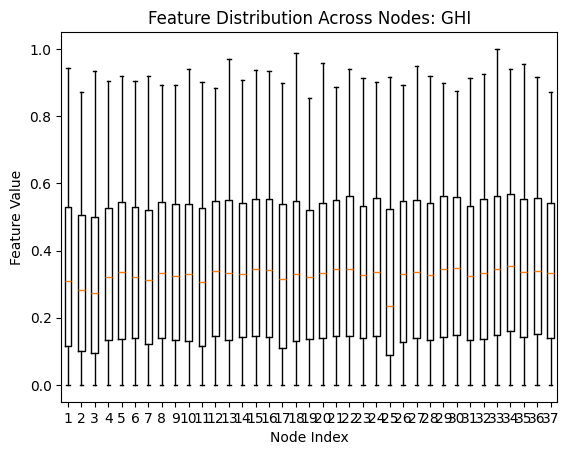

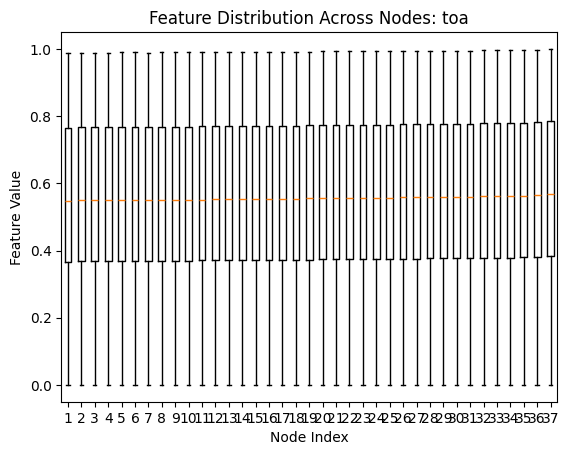

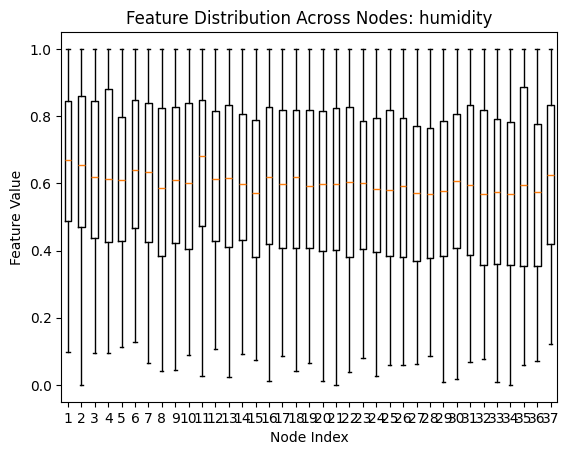

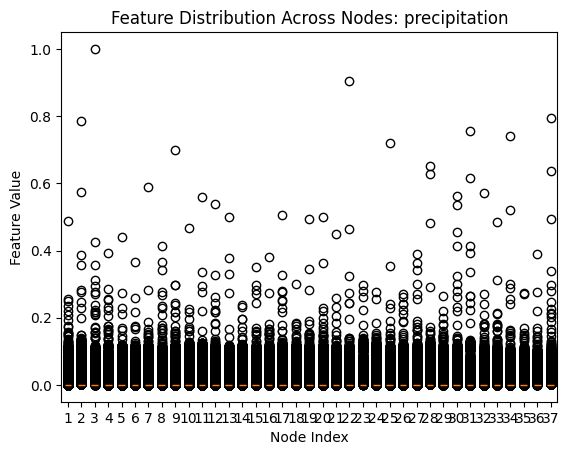

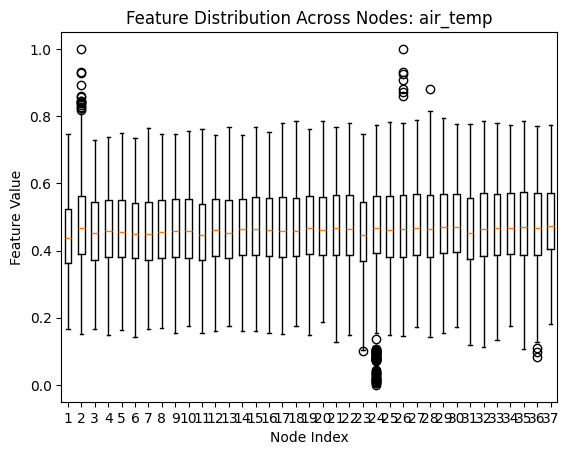

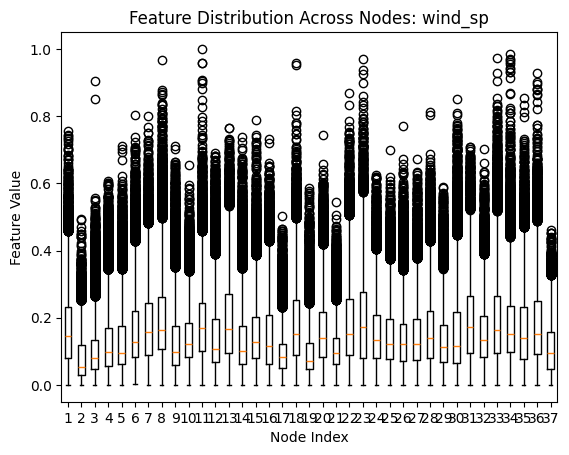

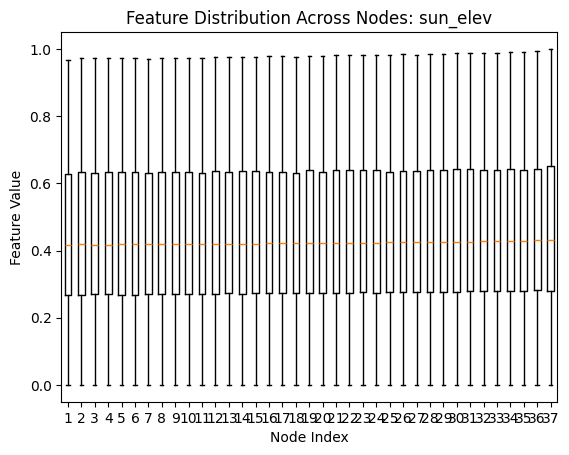

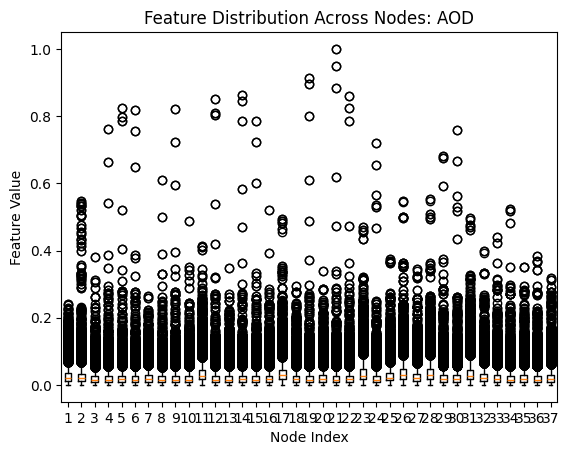

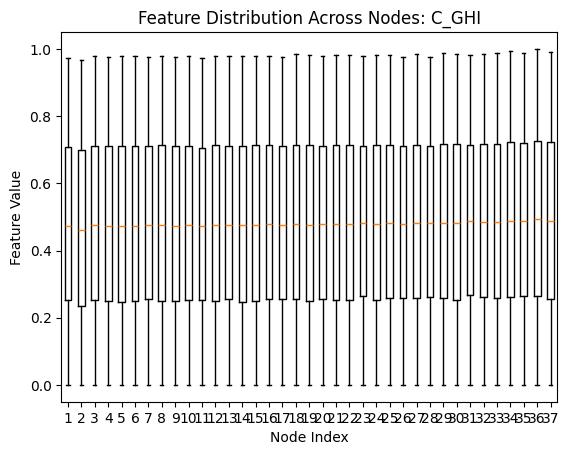

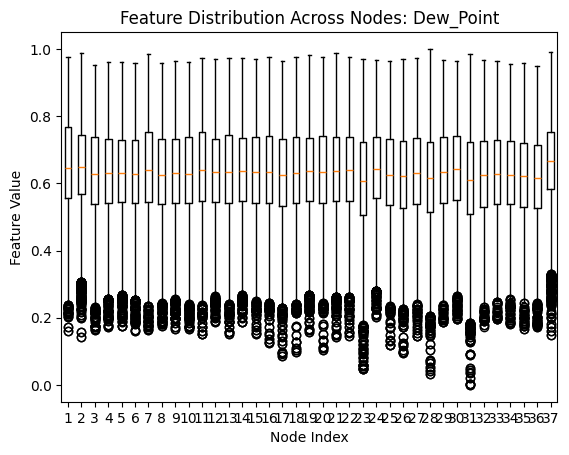

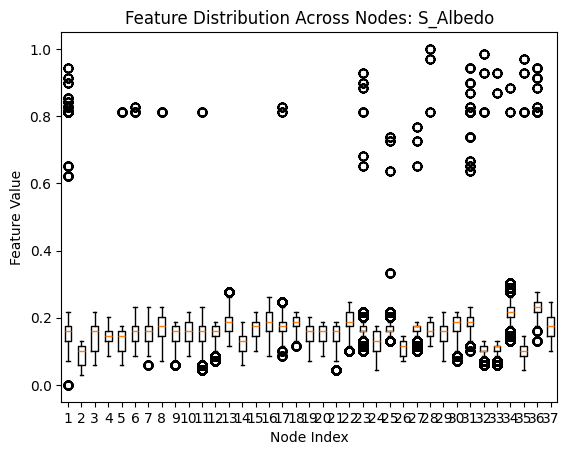

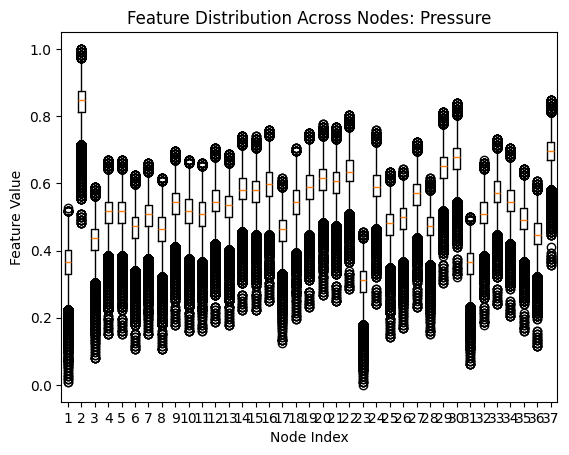

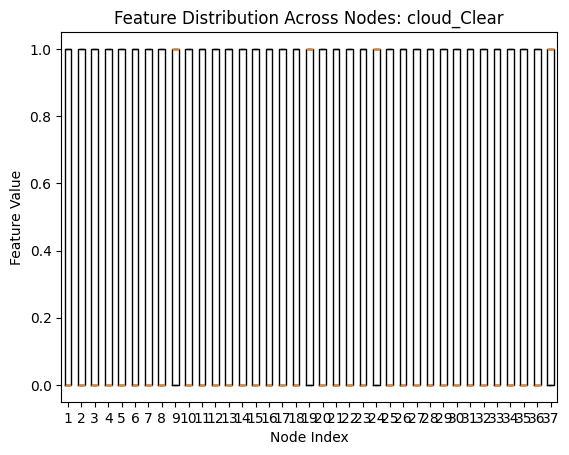

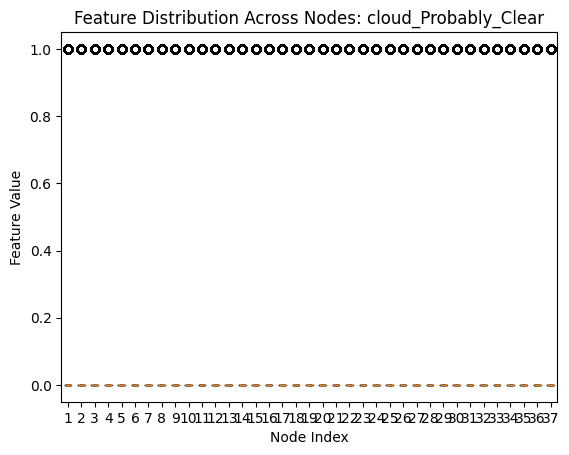

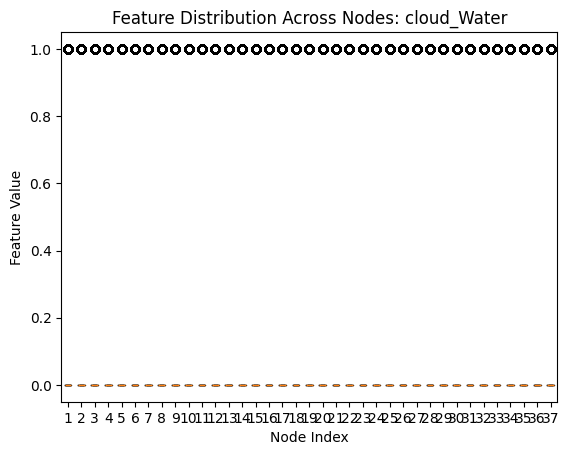

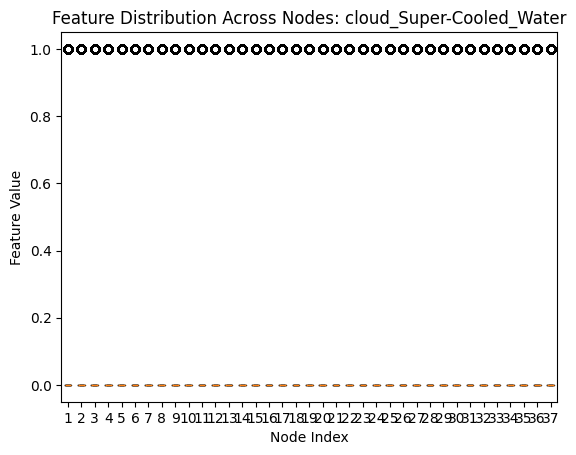

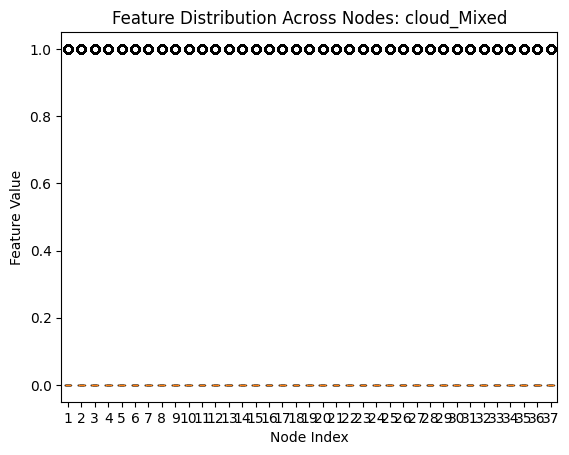

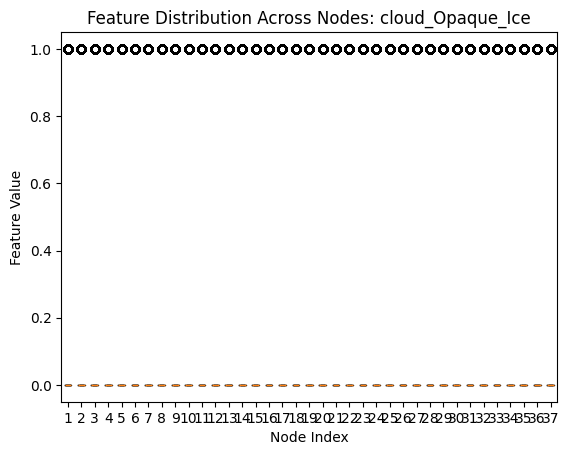

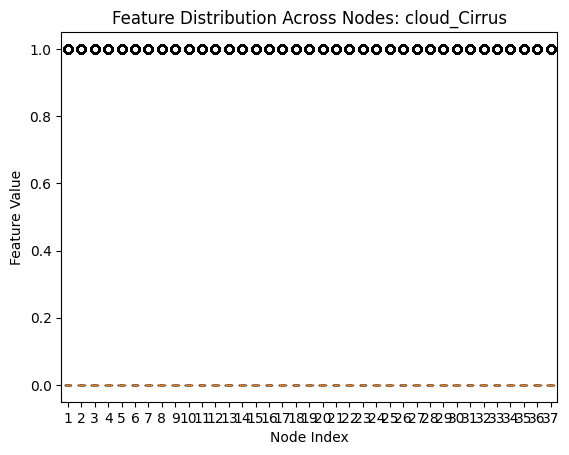

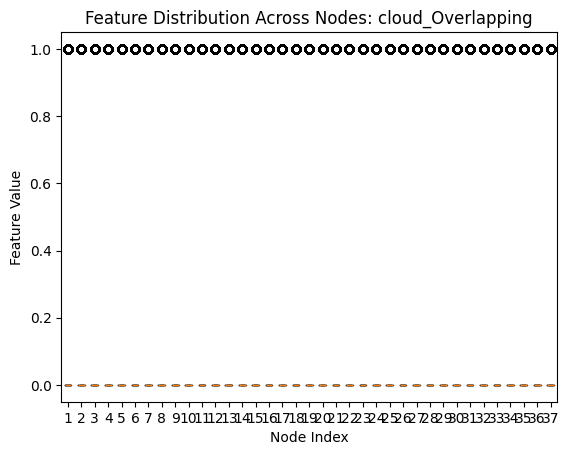

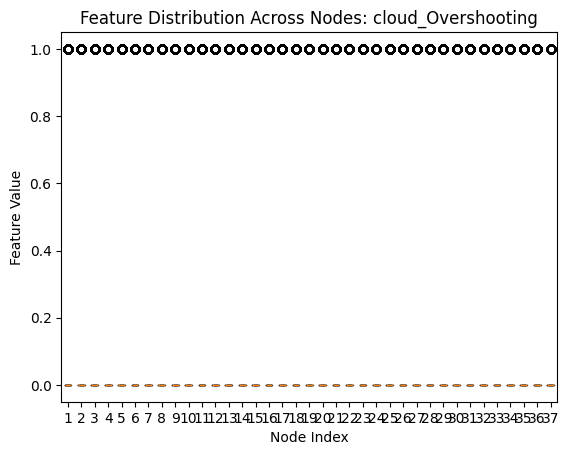

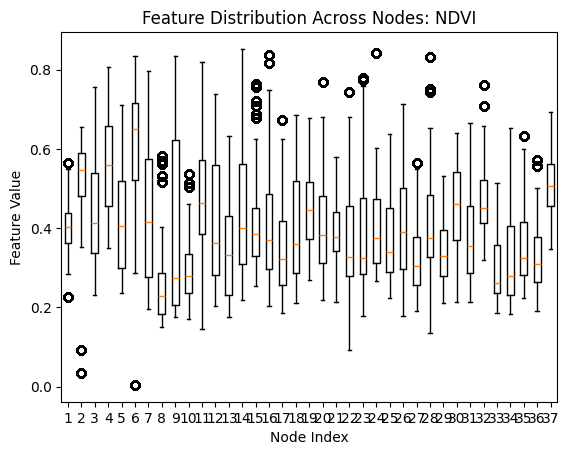

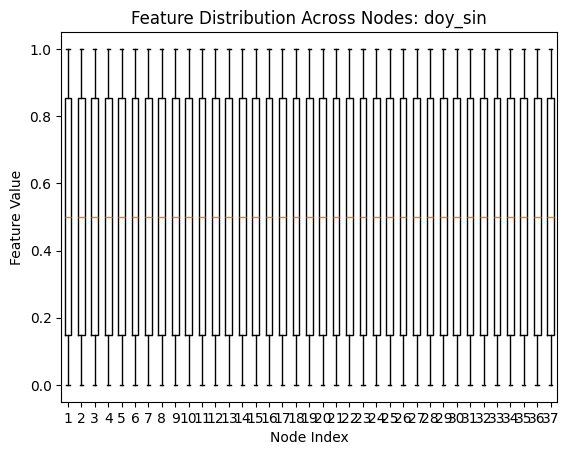

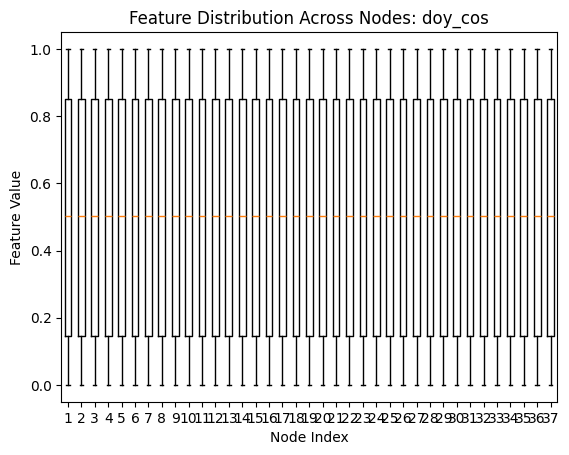

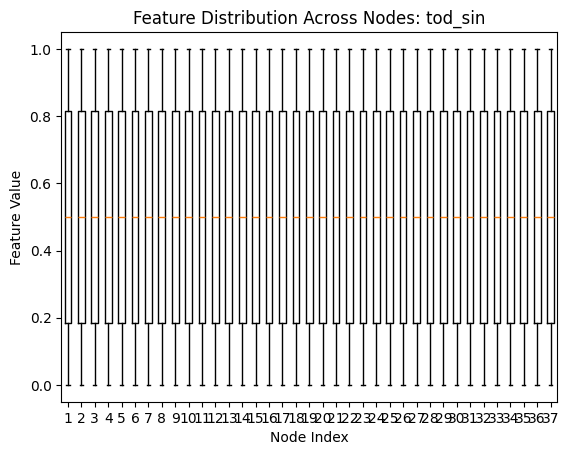

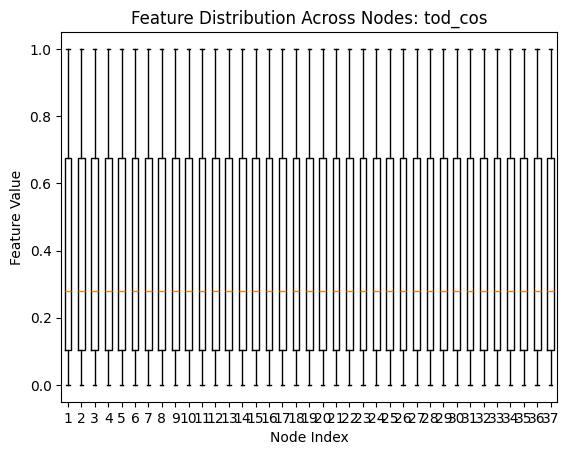

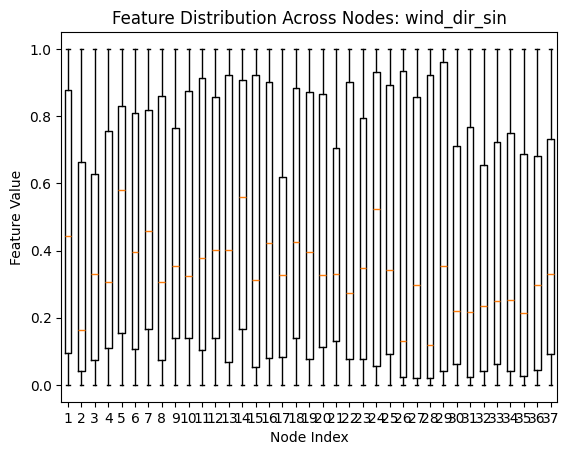

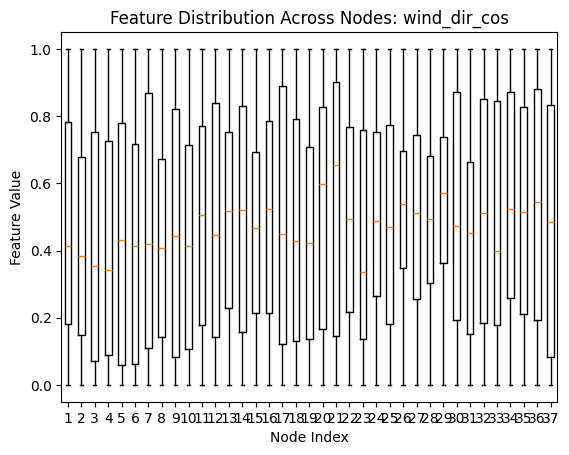

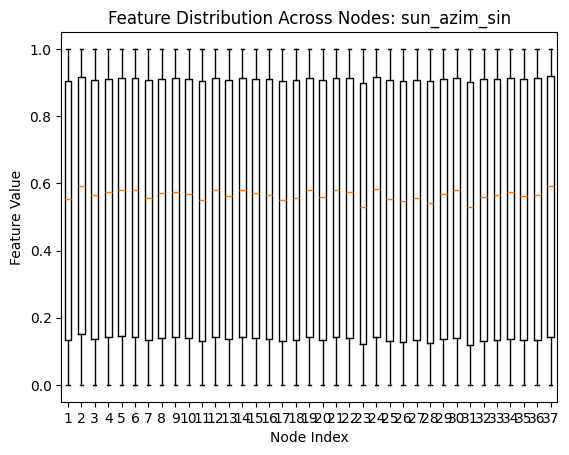

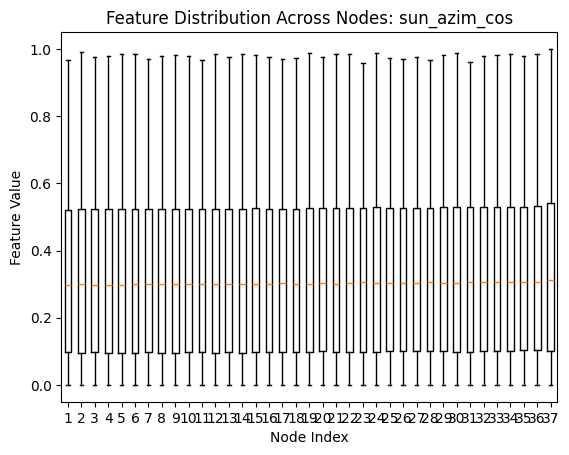

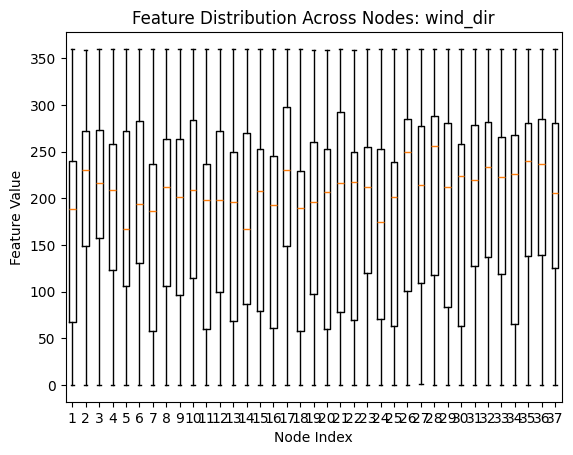

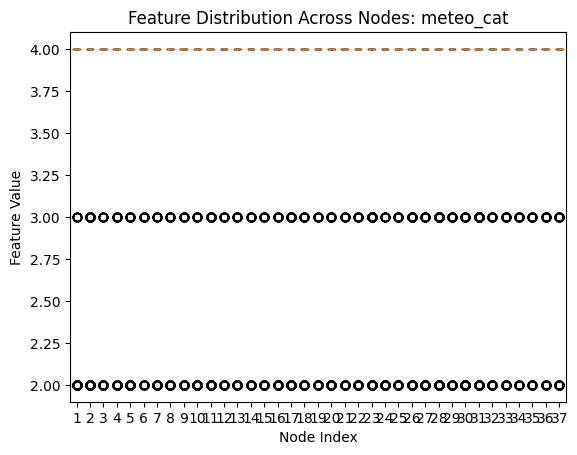

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use the existing temporal_node_tensor and df_cols in the environment
tensor = temporal_node_tensor  # shape (T, N, F)
T, N, F = tensor.shape

for f in range(F):
    data = [tensor[:, n, f] for n in range(N)]  # list of arrays, one per node

    plt.figure()
    plt.boxplot(data)
    plt.title(f"Feature Distribution Across Nodes: {df_cols[f]}")
    plt.xlabel("Node Index")
    plt.ylabel("Feature Value")
    plt.show()


## GHI Persistence baseline

In [ ]:
import torch

def persistence_mae_torch(y, h=6):
    """
    Compute persistence forecast MAE for horizons 1..h using PyTorch.

    Args:
        y (torch.Tensor): 1D tensor of shape [T], time series values.
        h (int): maximum forecast horizon (>=1).

    Returns:
        mae_all (torch.Tensor): tensor of shape [h], MAE for each horizon.
        y_true_list (list[torch.Tensor]): true values per horizon.
        y_pred_list (list[torch.Tensor]): predictions per horizon.
    """
    if h <= 0:
        raise ValueError("h must be >= 1")
    if y.numel() <= h:
        raise ValueError("time series too short for given horizon")

    maes = []
    y_true_list, y_pred_list = [], []
    for k in range(1, h + 1):
        y_pred = y[:-k]
        y_true = y[k:]
        mae = torch.mean(torch.abs(y_true - y_pred))
        maes.append(mae)
        y_true_list.append(y_true)
        y_pred_list.append(y_pred)

    return torch.stack(maes), y_true_list, y_pred_list


# Example usage
l = int(temporal_target_tensor.shape[0] * 0.33)
u = int(temporal_target_tensor.shape[0] * 0.66)

mae_all, y_true_list, y_pred_list = persistence_mae_torch(
    torch.tensor(temporal_target_tensor[l:u]), h=6
)

print("MAE per horizon:", mae_all.tolist())


MAE per horizon: [72.2544312283814, 117.090931552433, 153.93061283828325, 186.11238068764965, 214.26264770771036, 238.3190771885048]


# Utility functions

In [ ]:
# ============================================================
# ============= Normalization/Sparsification functions =======================
# ============================================================
def row_normalize(A: torch.Tensor, eps: float = 1e-8):
    row_sum = A.sum(dim=-1, keepdim=True)
    return A / (row_sum + eps)

def normalize(t, dim=1, eps=1e-6):
    mean = t.mean(dim=dim, keepdim=True)
    std = t.std(dim=dim, unbiased=False, keepdim=True).clamp(min=eps)
    return (t - mean) / std

def minmax_normalize(t, dim=1, eps=1e-6):
    t_min = t.min(dim=dim, keepdim=True).values
    t_max = t.max(dim=dim, keepdim=True).values

    # avoid division-by-zero if t_max == t_min
    denom = (t_max - t_min).clamp(min=eps)

    return (t - t_min) / denom

def symmetry_normalize(A: torch.Tensor, eps: float = 1e-8):
    d = A.sum(dim=-1)
    d_inv_sqrt = torch.pow(d + eps, -0.5)
    return d_inv_sqrt[:, None] * A * d_inv_sqrt[None, :]


# ============================================================
# ============= useful functions =======================
# ============================================================

def gaussian_kernel(distance, sigma):
    return torch.exp(- (distance ** 2) / (2 * sigma ** 2))

def directed_dirichlet_energy(Z: torch.Tensor, A_directed: torch.Tensor, nodewise: bool = False):
    """
    Compute directional (asymmetric) Dirichlet energy.

    Parameters
    ----------
    Z : [N, D] node embeddings
    A_directed : [N, N] directed adjacency matrix
    nodewise : bool
        If True, return per-node energy; otherwise scalar for the whole graph.

    Returns
    -------
    energy : scalar or [N] tensor
        Dirichlet energy.
    """
    # Compute pairwise squared differences ||z_i - z_j||^2
    pd = ((Z.unsqueeze(1) - Z.unsqueeze(0)) ** 2).sum(-1)  # [N, N]

    # Weight by adjacency
    weighted_pd = A_directed * pd  # [N, N]

    if nodewise:
        # Node-wise energy: sum over outgoing edges
        node_energy = 0.5 * weighted_pd.sum(dim=1)  # [N]
        return node_energy
    else:
        # Scalar energy: sum over all edges
        energy = 0.5 * weighted_pd.sum()
        return energy

def spatial_dirichlet_energy(Z: torch.Tensor, A_sym: torch.Tensor, nodewise: bool = False):
    """
    Compute symmetric Dirichlet energy (normalized by degree).

    Parameters
    ----------
    Z : [N, D] node embeddings
    A_sym : [N, N] symmetric adjacency matrix
    nodewise : bool
        If True, return per-node energy; otherwise scalar for the whole graph.

    Returns
    -------
    energy : scalar or [N] tensor
        Dirichlet energy.
    """

    # Compute Laplacian
    I = torch.eye(A_sym.size(0), device=A_sym.device, dtype=A_sym.dtype)
    L = I - A_sym  # normalized Laplacian

    if nodewise:
        # Node-wise energy: (L*Z) · Z per row
        node_energy = torch.sum((L @ Z) * Z, dim=1)  # [N]
        return node_energy
    else:
        # Scalar energy: trace(Z^T L Z)
        energy = torch.trace(Z.T @ (L @ Z))
        return energy

def pairwise_energy(X, A):
    """
    X: [B, W, N, F]
    A: [B, W, N, N]
    Returns: E: [B, W, N]
    Computes nodewise directed Dirichlet energy:
        E[n] = sum_m A[n,m] * ||X[n] - X[m]||^2
    Fully vectorized.
    """

    # ||X||^2 term
    X2 = (X * X).sum(dim=-1, keepdim=True)         # [B,W,N,1]
    # X·Xᵀ term
    XY = X @ X.transpose(-1, -2)                   # [B,W,N,N]
    # squared distances
    D2 = X2 + X2.transpose(-1, -2) - 2 * XY        # [B,W,N,N]

    # multiply by adjacency
    E = (A * D2).sum(dim=-1)                       # [B,W,N]
    return E

def embedding_variance(Z):
    """Encourage spread in embedding space."""
    mean_z = Z.mean(dim=0, keepdim=True)
    return ((Z - mean_z) ** 2).sum() / Z.shape[0]

def topk_row(A: torch.Tensor, k: int, sym: bool = False, eps: float = 1e-8):
    """
    Top-k refinement for adjacency matrices.
    Supports A: [N, N] or A: [B, N, N].

    Args:
        A: adjacency matrix (2D or 3D)
        k: number of neighbors to keep
        sym: enforce symmetry (A ← (A+Aᵀ)/2) before normalization
        eps: numerical stability

    Returns:
        Refined adjacency of the same shape as A
    """

    if A.ndim == 2:
        # Add batch dimension: [1, N, N]
        A = A.unsqueeze(0)
        squeeze_back = True
    else:
        squeeze_back = False

    B, N, N2 = A.shape
    assert N == N2, "Adjacency must be square"

    k = min(k, N)

    # ---- Top-k per row ----
    vals, idx = torch.topk(A, k, dim=2)      # [B, N, k]
    out = torch.zeros_like(A)                # [B, N, N]
    out.scatter_(2, idx, vals)               # put top-k values in place

    # ---- Symmetry optional ----
    if sym:
        out = 0.5 * (out + out.transpose(1, 2))  # [B,N,N]
        out = symmetry_normalize(out, eps)
    else:
        out = row_normalize(out, eps)

    # ---- Remove batch dimension if input was 2D ----
    if squeeze_back:
        out = out.squeeze(0)

    return out
def corrcoef(a, b, eps=1e-6):
    a = a - a.mean()
    b = b - b.mean()
    return (a * b).mean() / (a.std() * b.std() + eps)


# A_static building

In [ ]:
class GeoGeometry:
    def __init__(self, df_geo, device="cpu"):
        self.df_geo = df_geo
        self.device = device
        self._build()

    def _build(self):
        n = self.df_geo.shape[0]
        geod = Geod(ellps="WGS84")

        dist = np.zeros((n, n))
        theta = np.zeros((n, n))

        for i in range(n):
            lat1, lon1 = self.df_geo.iloc[i]["latitude"], self.df_geo.iloc[i]["longitude"]
            for j in range(n):
                if i == j:
                    continue
                lat2, lon2 = self.df_geo.iloc[j]["latitude"], self.df_geo.iloc[j]["longitude"]
                az12, _, dist_m = geod.inv(lon1, lat1, lon2, lat2)
                dist[i, j] = dist_m / 1000.0
                theta[i, j] = np.radians(az12)

        self.dist_matrix = torch.tensor(dist, dtype=torch.float32, device=self.device)
        self.theta_matrix = torch.tensor(theta, dtype=torch.float32, device=self.device)

class DistanceKernel:
    def __init__(self, dist_matrix, sigma=None):
        self.dist_matrix = dist_matrix
        self.sigma = sigma or self._estimate_sigma()

    def _estimate_sigma(self):
        mask = torch.triu(torch.ones_like(self.dist_matrix), diagonal=1).bool()
        return torch.std(self.dist_matrix[mask])

    def compute(self, self_loops=False):
        A = torch.exp(- (self.dist_matrix ** 2) / (2 * self.sigma ** 2))
        if not self_loops:
            A.fill_diagonal_(0)
        return A
# ======================================================
# === 2. Create static adjacency module
# ======================================================
geo = GeoGeometry(df_geo, device)
dist_matrix = geo.dist_matrix
theta_matrix = geo.theta_matrix
kernel = DistanceKernel(dist_matrix)
A_raw = kernel.compute(self_loops=False) # self_loop set diagonal to 0 or 1 (depending on needs)

A_static1 = topk_row (A_raw, k=5, sym=False)
A_static2 = row_normalize (A_raw)
A_static3 = symmetry_normalize (A_raw)


# A_Wind building

In [ ]:
class WindAdjacency(nn.Module):
    """
    Build A_wind(t) from static distance/bearing + time-varying wind dir/speed.
    Supports batched input: wind_feats [B, N, F].
    Produces row-stochastic adjacency per batch.
    return A_wind[i,j].
    important: A_wind[i,j] is how much node i influences node j along wind
    """

    def __init__(
        self,
        D_ij, Theta_ij,
        R=150.0,
        lambda_theta=1.0,
        cone_half_angle=None,
        wind_speed_pos: int = 0,
        wind_dir_pos: int = 1,
    ):
        super().__init__()
        self.register_buffer("D_ij", D_ij)         # [N,N]
        self.register_buffer("Theta_ij", Theta_ij) # [N,N]

        self.R = float(R)
        self.lambda_theta = float(lambda_theta)
        self.cone_half_angle = cone_half_angle

        self.wind_speed_pos = wind_speed_pos
        self.wind_dir_pos = wind_dir_pos

    @staticmethod
    def angdiff(a, b):
        # works with broadcasting (batched or non-batched)
        return (a - b + torch.pi) % (2 * torch.pi) - torch.pi

    def forward(self, wind_feats, sparse: bool=False, k: int = 5,self_loops:bool=False):

        # ---------------------------
        # Handle shapes
        # ---------------------------
        if wind_feats.dim() == 2:
            # [N,F] → [1,N,F], later squeeze back
            wind_feats = wind_feats.unsqueeze(0)
            squeeze = True
        else:
            squeeze = False

        B, N, F = wind_feats.shape
        device = wind_feats.device

        # ---------------------------
        # Extract wind components
        # ---------------------------
        wind_speed = wind_feats[..., self.wind_speed_pos]  # [B,N]
        wind_dir   = wind_feats[..., self.wind_dir_pos]    # [B,N]

        # Convert meteorological (from) → movement (to)
        wind_to = (wind_dir + torch.pi) % (2 * torch.pi)   # [B,N]

        # Expand to [B,N,N]
        dir_mat = wind_to.unsqueeze(-1).expand(B, N, N)    # rows = i

        # Static fields to [B,N,N]
        D_ij = self.D_ij.unsqueeze(0).expand(B, N, N)
        Theta_ij = self.Theta_ij.unsqueeze(0).expand(B, N, N)

        # ---------------------------
        # Alignment term
        # ---------------------------
        # Theta_ij - wind_to[i] → positive if j is downstream from i according to wind
        ang = self.angdiff(Theta_ij, dir_mat)
        align = torch.cos(ang).clamp(min=0.0)              # [B,N,N]

        # ---------------------------
        # Base weight (distance + alignment)
        # ---------------------------
        base = torch.exp(-D_ij / self.R) * torch.exp(align / self.lambda_theta)

        # ---------------------------
        # Cone restriction (optional)
        # ---------------------------
        if self.cone_half_angle is not None:
            cone_mask = (ang.abs() <= self.cone_half_angle)
            base = base * cone_mask.float()

        # ---------------------------
        # Multiply by wind speed_i
        # ---------------------------
        base = base * wind_speed.unsqueeze(-1)             # [B,N,1] → [B,N,N]

        # ---------------------------
        # self loop connection
        # ---------------------------
        if not self_loops:
            base.diagonal(dim1=-2, dim2=-1).zero_()
        # ---------------------------
        # Sparse or dense?
        # ---------------------------
        if sparse:
            A = []
            for b in range(B):
                A_b = topk_row(base[b], k=k, sym=False)    # returns [N,N]
                A.append(A_b)
            A = torch.stack(A, dim=0)                      # [B,N,N]
        else:
            A = base / (base.sum(dim=-1, keepdim=True) + 1e-8)

        # ---------------------------
        # If original input was unbatched → squeeze
        # ---------------------------
        if squeeze:
            A = A[0]

        return A

# ======================================================
# === 2. Create wind-based adjacency module
# ======================================================
wind_adj = WindAdjacency(
    D_ij=dist_matrix,
    Theta_ij=theta_matrix,
    wind_speed_pos= wind_dir_pos,
    wind_dir_pos= wind_sp_pos,
    R=150.0,
    lambda_theta=1.0
)

## example

In [ ]:
# === Extract wind features ===
t = 1000  # choose time index
node_t = temporal_node_tensor[t]

wind_feats = torch.tensor(
    node_t[:, masks["mask_wind"]],
    dtype=torch.float32
).to(device)

# === Build adjacency module ===
A_wind_builder = WindAdjacency(
    D_ij=dist_matrix,
    Theta_ij=theta_matrix,
    R=25.0,
    lambda_theta=1.0,
    cone_half_angle=None,
    wind_speed_pos=wind_sp_pos,
    wind_dir_pos=wind_dir_pos
).to(device)

# === Compute adjacency ===
A = A_wind_builder(wind_feats,sparse=True)
print(A.shape)
print(A.sum(dim=-1))


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')


# Adjacency: Pretraining Embedding

## version 2

In [ ]:
# ============================================================
# ========== Temporal Window AutoEncoder with Optional Attention ==========
# ============================================================
class TemporalWindowAutoEncoder(nn.Module):
    def __init__(
        self,
        in_dim,
        embed_dim,
        window=6,
        conv_hidden=64,
        dropout=0.1,
        use_attention=False,
        cloud_embed_dim=3,
        mask_cloud=None,
    ):
        """
        Args:
            in_dim: number of input features per node
            embed_dim: latent embedding dimension for nodes
            num_cloud_classes: number of one-hot cloud types
            cloud_embed_dim: dimension of learnable cloud embedding
            mask_cloud: boolean mask for cloud features in input vector
        """
        super().__init__()
        self.in_dim = in_dim
        self.window = window
        self.use_attention = use_attention
        self.cloud_embed_dim = cloud_embed_dim
        self.cloud_norm = nn.LayerNorm(cloud_embed_dim)


        # Register mask for cloud features
        self.register_buffer("mask_cloud", mask_cloud.detach().clone().to(torch.bool))

        # Count number of explicit cloud classes (e.g., 9)
        self.num_cloud_classes = int(self.mask_cloud.sum().item())

        # Cloud embedding replaces the one-hot block
        self.in_dim_after_embedding = self.in_dim - self.num_cloud_classes + self.cloud_embed_dim

        # ------------------------------------------------
        # Cloud embedding (for one-hot → latent projection)
        # ------------------------------------------------
        if mask_cloud is not None and self.num_cloud_classes is not None:
            self.use_cloud_embed = True
            self.cloud_emb = nn.Embedding(self.num_cloud_classes, cloud_embed_dim)
        else:
            self.use_cloud_embed = False

        # ---------------- Encoder ----------------

        self.encoder = nn.Sequential(
            nn.Conv1d(self.in_dim_after_embedding, conv_hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(conv_hidden, embed_dim, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # ---------------- Attention Pooling ----------------
        if use_attention:
            self.attn_fc = nn.Linear(embed_dim, 1)

        # ---------------- Decoder ----------------
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, conv_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(conv_hidden, self.in_dim_after_embedding),
        )

    # ============================================================
    def forward(self, x_t):
        B, W, N, F = x_t.shape

        # --- optionally embed cloud features ---
        if self.use_cloud_embed:
            x_t = self.apply_cloud_embedding(x_t)

        z_t = self.encode_window(x_t)
        x_target = x_t[:, -1, :, :]
        x_recon = self.decode_nodes(z_t)
        recon_loss = Func.mse_loss(x_recon, x_target)
        return recon_loss, z_t

    # ============================================================
    def apply_cloud_embedding(self, x_t):
        """
        Replace one-hot cloud features with learnable latent embedding.
        Input shape: [B, W, N, F]
        Output: concatenated features with cloud embedding normalized
        """
        mask = self.mask_cloud.to(x_t.device)
        mask = mask[:x_t.size(-1)]  # safety for shape mismatch
        num_cloud_classes = int(mask.sum().item())

        if num_cloud_classes == 0:
            return x_t

        # --- extract one-hot cloud features ---
        cloud_feats = x_t[..., mask]  # [B, W, N, num_cloud_classes]
        cloud_idx = cloud_feats.argmax(dim=-1).long().to(x_t.device)  # [B, W, N]

        # --- get embedding ---
        cloud_emb = self.cloud_emb(cloud_idx).to(x_t.device)  # [B, W, N, cloud_embed_dim]

        # --- normalize embedding to [0,1] like other features ---
        cloud_emb = self.cloud_norm(cloud_emb)

        '''
        B, W, N, D = cloud_emb.shape
        cloud_emb_2d = cloud_emb.reshape(-1, D)
        min_vals = cloud_emb_2d.min(dim=0, keepdim=True).values
        max_vals = cloud_emb_2d.max(dim=0, keepdim=True).values
        cloud_emb_scaled = (cloud_emb_2d - min_vals) / (max_vals - min_vals + 1e-6)
        cloud_emb = cloud_emb_scaled.reshape(B, W, N, D)
        '''

        # --- concatenate with non-cloud features ---
        non_cloud_feats = x_t[..., ~mask].to(x_t.device)
        x_t_new = torch.cat([non_cloud_feats, cloud_emb], dim=-1)

        return x_t_new

    # ============================================================
    def encode_window(self, x):
        B, W, N, F = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B * N, F, W)
        z_seq = self.encoder(x).permute(0, 2, 1)
        if self.use_attention:
            attn_scores = self.attn_fc(z_seq)
            attn_weights = torch.softmax(attn_scores, dim=1)
            z = torch.sum(attn_weights * z_seq, dim=1)
        else:
            z = z_seq.mean(dim=1)
        z = z.view(B, N, -1)
        return Func.normalize(z, p=2, dim=-1)

    def decode_nodes(self, z):
        B, N, D = z.shape
        x_hat = self.decoder(z.reshape(B * N, D))
        return x_hat.view(B, N, -1)

# ============================================================
# ============= Sliding Window Dataset =======================
# ============================================================

class SlidingWindowDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __len__(self):
        return self.data.shape[0] - self.window

    def __getitem__(self, idx):
        return self.data[idx: idx + self.window]


# ============================================================
# ================ Pretraining Function ======================
# ============================================================
def pretrain_en_de_with_regularizers(
    train_tensor,
    val_tensor=None,
    in_dim=masks["mask_embed"].sum().item(),
    embed_dim=16,
    conv_hidden=128,
    window=6,
    use_attention=True,
    batch_size=8,
    lr=1e-3,
    epochs=20,
    device="cuda" if torch.cuda.is_available() else "cpu",
    early_stopping_patience=5,
    mask_embed=None,
    mask_cloud = None,
    save_path=None,
    verbose=True,
):

    """
    Simplified temporal autoencoder pretraining:
        Loss = recon_loss  - lambda_var * variance
    All wind / spatial regularizers are removed.
    """

    # -------------------- Data --------------------
    train_loader = DataLoader(
        SlidingWindowDataset(train_tensor, window),
        batch_size=batch_size, shuffle=False, drop_last=True
    )

    val_loader = None
    if val_tensor is not None:
        val_loader = DataLoader(
            SlidingWindowDataset(val_tensor, window),
            batch_size=batch_size, shuffle=False, drop_last=True
        )

    # -------------------- Model --------------------
    model = TemporalWindowAutoEncoder(
        in_dim=in_dim,
        embed_dim=embed_dim,
        window=window,
        conv_hidden=conv_hidden,
        use_attention=use_attention,
        cloud_embed_dim=3,
        mask_cloud = mask_cloud
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    # -------------------- Logs --------------------
    logs = {k: [] for k in [
        "train_total", "train_recon","val_total", "val_recon"
    ]}

    best_val = float("inf")
    best_epoch = 0
    patience_counter = 0

    # ============================================================
    # ========================= Training =========================
    # ============================================================
    for epoch in range(1, epochs + 1):

        model.train()
        epoch_recon = 0.0
        n_batches = 0

        for x_t in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            x_t = x_t.to(device)
            emb_t = x_t[..., mask_embed] if mask_embed is not None else x_t

            optimizer.zero_grad()
            recon_loss, z_t = model(emb_t)
            loss = recon_loss

            loss.backward()
            optimizer.step()

            epoch_recon += recon_loss.item()
            n_batches += 1

        n_batches = max(n_batches, 1)
        epoch_recon /= n_batches

        train_total = epoch_recon
        logs["train_total"].append(train_total)
        logs["train_recon"].append(epoch_recon)

        # ============================================================
        # ====================== Validation ==========================
        # ============================================================
        val_total = None
        if val_loader is not None:
            model.eval()
            val_recon = 0.0
            n_val = 0

            with torch.no_grad():
                for x_t in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False):
                    x_t = x_t.to(device)
                    emb_t = x_t[..., mask_embed] if mask_embed is not None else x_t

                    recon_loss, z_t = model(emb_t)
                    val_recon += recon_loss.item()
                    n_val += 1

            n_val = max(n_val, 1)
            val_recon /= n_val
            val_total = val_recon

            logs["val_total"].append(val_total)
            logs["val_recon"].append(val_recon)

            scheduler.step(val_total)

        # ============================================================
        # ===================== Early Stopping =======================
        # ============================================================
        improved = val_total is not None and val_total < best_val

        if improved:
            best_val = val_total
            best_epoch = epoch
            patience_counter = 0

            if save_path is not None:
                torch.save({
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "logs": logs,
                    "last_epoch": epoch,
                    "best_val": best_val,
                    "best_epoch": best_epoch,
                }, save_path)

        else:
            patience_counter += 1

        if verbose:
            v = f"{val_total:.4f}" if val_total is not None else "N/A"
            print(f"Epoch {epoch:02d} | Train: {train_total:.4f} | Val: {v} | Patience {patience_counter}")

        if val_total is not None and patience_counter >= early_stopping_patience:
            print(f"⏹ Early stopping at epoch {epoch}. Best={best_val:.4f} @ {best_epoch}")
            break

    # ----------------------- Save config -------------------------
    if save_path is not None:
        model_config = {
            "in_dim": in_dim,
            "embed_dim": embed_dim,
            "window": window,
            "use_attention": use_attention,
            "conv_hidden": (
                model.encoder[0].out_channels
                if hasattr(model.encoder[0], "out_channels")
                else conv_hidden
            ),
            "dropout": getattr(model.encoder[3], "p", 0.1),
        }

        checkpoint = torch.load(save_path)
        checkpoint["config"] = model_config
        torch.save(checkpoint, save_path)

        print(f"✅ Training complete. Best model saved at {save_path} (epoch {best_epoch})")

    else:
        print(f"✅ Training complete. Best model at epoch {best_epoch} (no file saved).")

    return model, logs, best_epoch


## data preparation

In [ ]:

def make_expanding_folds(T, train_start, first_train_end, val_window, n_folds):
    """
    T               total time length
    train_start     usually 0
    first_train_end index where first train ends (exclusive)
    val_window      number of timesteps for each validation fold
    n_folds         how many folds to generate
    """
    folds = []

    train_end = first_train_end
    val_start = train_end
    for f in range(n_folds):
        val_end = min(val_start + val_window, T)
        if val_end <= val_start: break

        folds.append(dict(
            train_slice=(train_start, train_end),
            val_slice=(val_start, val_end)
        ))

        # expand training to include the validation just used
        train_end = val_end
        val_start = val_end

    return folds

def extract_fold_data(temporal_node_tensor, folds, fold_idx):
    """
    temporal_node_tensor: [T, N, F]
    folds: list of dicts from make_expanding_folds
    fold_idx: which fold (0-based)
    """
    assert 0 <= fold_idx < len(folds), f"Fold index {fold_idx} invalid."

    tr_slice = folds[fold_idx]['train_slice']
    va_slice = folds[fold_idx]['val_slice']

    train_data = temporal_node_tensor[tr_slice[0] : tr_slice[1]]
    val_data   = temporal_node_tensor[va_slice[0] : va_slice[1]]

    return train_data, val_data


# ======================================================
# === 3. Prepare Expanding Window CV Splits ============
# ======================================================

T = temporal_node_tensor.shape[0]

# You choose these:
first_train_end = int(T * 0.33)     # e.g., first 33% as initial training
val_window = int(T * 0.11)          # e.g., each fold validated for 11%
n_folds = 3                         # number of CV foldsca

# ======================================================
# === 1. Expanding Window CV Split Creation ============
# ======================================================
folds = make_expanding_folds(
    T=T,
    train_start=0,
    first_train_end=first_train_end,
    val_window=val_window,
    n_folds=n_folds
)

print("FOLD SPLITS:")
for i, f in enumerate(folds):
    print(f"Fold {i+1}: Train {f['train_slice']}  Val {f['val_slice']}")


FOLD SPLITS:
Fold 1: Train (0, 7588)  Val (7588, 10117)
Fold 2: Train (0, 10117)  Val (10117, 12646)
Fold 3: Train (0, 12646)  Val (12646, 15175)


## HyperTuning

In [ ]:

# ======================================================
# === 1. Reproducibility ================================
# ======================================================
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ======================================================
# === 2. Device & Paths ================================
# ======================================================
device = "cuda" if torch.cuda.is_available() else "cpu"

base_dir = "/content/gdrive/MyDrive/hparam_search_encoder"
os.makedirs(base_dir, exist_ok=True)

set_seed(123)


# ======================================================
# === 3. Hyperparameter Grid ===========================
# ======================================================
EMBED_DIMS   = [8,16,32]
CONV_HIDDENS = [32,64,128,256]

SEEDS = [123]      # correct for CV
FOLDS = [0,1,2]        # expand later if needed


# ======================================================
# === 4. Common Training Arguments =====================
# ======================================================
common_args = dict(
    window=12,
    use_attention=True,
    batch_size=8,
    epochs=20,
    lr=1e-3,
    early_stopping_patience=5,
    verbose=True,

    mask_embed=torch.tensor(
        masks["mask_embed"], dtype=torch.bool, device=device
    ),
    mask_cloud=torch.as_tensor(mask_cloud).bool().to(device),
)


# ======================================================
# === 5. Prepare Data =================================
# ======================================================
temporal_node_tensor = torch.as_tensor(
    temporal_node_tensor, dtype=torch.float32, device=device
)


# ======================================================
# === 6. Hyperparameter Search =========================
# ======================================================
results = []

for embed_dim, conv_hidden in product(EMBED_DIMS, CONV_HIDDENS):

    print(f"\n🔧 Testing embed_dim={embed_dim}, conv_hidden={conv_hidden}")
    fold_scores = []

    for seed in SEEDS:
        set_seed(seed)
        print(f"  🌱 Seed {seed}")

        for f in FOLDS:
            print(f"    📦 Fold {f+1}")

            train_data, val_data = extract_fold_data(
                temporal_node_tensor, folds, f
            )

            ckpt_path = os.path.join(
                base_dir,
                f"ed{embed_dim}_ch{conv_hidden}_seed{seed}_fold{f+1}.pt"
            )

            _, logs, _ = pretrain_en_de_with_regularizers(
                train_tensor=train_data,
                val_tensor=val_data,
                embed_dim=embed_dim,
                conv_hidden=conv_hidden,
                save_path=ckpt_path,
                **common_args,
            )

            best_val = float(min(logs["val_total"]))
            fold_scores.append(best_val)

            print(f"      ⭐ best val = {best_val:.4f}")

    mean_val = mean(fold_scores)
    std_val  = stdev(fold_scores) if len(fold_scores) > 1 else 0.0

    results.append({
        "embed_dim": embed_dim,
        "conv_hidden": conv_hidden,
        "val_mean": mean_val,
        "val_std": std_val,
    })

    print(f"  ✅ mean={mean_val:.4f} ± {std_val:.4f}")


# ======================================================
# === 7. Select Best Configuration =====================
# ======================================================
best_cfg = min(results, key=lambda x: x["val_mean"])

print("\n🏆 Best Encoder Configuration")
print(
    f"embed_dim={best_cfg['embed_dim']}, "
    f"conv_hidden={best_cfg['conv_hidden']} | "
    f"val={best_cfg['val_mean']:.4f} ± {best_cfg['val_std']:.4f}"
)



🔧 Testing embed_dim=8, conv_hidden=32
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0695 | Val: 0.0198 | Patience 0


Epoch 02 | Train: 0.0117 | Val: 0.0115 | Patience 0


Epoch 03 | Train: 0.0081 | Val: 0.0135 | Patience 1


Epoch 04 | Train: 0.0062 | Val: 0.0132 | Patience 2


Epoch 05 | Train: 0.0051 | Val: 0.0123 | Patience 3


Epoch 06 | Train: 0.0044 | Val: 0.0102 | Patience 0


Epoch 07 | Train: 0.0040 | Val: 0.0091 | Patience 0


Epoch 08 | Train: 0.0037 | Val: 0.0084 | Patience 0


Epoch 09 | Train: 0.0034 | Val: 0.0082 | Patience 0


Epoch 10 | Train: 0.0032 | Val: 0.0082 | Patience 0


Epoch 11 | Train: 0.0031 | Val: 0.0085 | Patience 1


Epoch 12 | Train: 0.0030 | Val: 0.0084 | Patience 2


Epoch 13 | Train: 0.0029 | Val: 0.0080 | Patience 0


Epoch 14 | Train: 0.0028 | Val: 0.0082 | Patience 1


Epoch 15 | Train: 0.0028 | Val: 0.0080 | Patience 0


Epoch 16 | Train: 0.0027 | Val: 0.0079 | Patience 0


Epoch 17 | Train: 0.0027 | Val: 0.0082 | Patience 1


Epoch 18 | Train: 0.0027 | Val: 0.0081 | Patience 2


Epoch 19 | Train: 0.0026 | Val: 0.0082 | Patience 3


Epoch 20 | Train: 0.0026 | Val: 0.0063 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold1.pt (epoch 20)
      ⭐ best val = 0.0063
    📦 Fold 2


Epoch 01 | Train: 0.0544 | Val: 0.0112 | Patience 0


Epoch 02 | Train: 0.0104 | Val: 0.0058 | Patience 0


Epoch 03 | Train: 0.0075 | Val: 0.0051 | Patience 0


Epoch 04 | Train: 0.0057 | Val: 0.0046 | Patience 0


Epoch 05 | Train: 0.0046 | Val: 0.0034 | Patience 0


Epoch 06 | Train: 0.0038 | Val: 0.0029 | Patience 0


Epoch 07 | Train: 0.0035 | Val: 0.0027 | Patience 0


Epoch 08 | Train: 0.0033 | Val: 0.0027 | Patience 1


Epoch 09 | Train: 0.0032 | Val: 0.0027 | Patience 2


Epoch 10 | Train: 0.0031 | Val: 0.0025 | Patience 0


Epoch 11 | Train: 0.0030 | Val: 0.0025 | Patience 0


Epoch 12 | Train: 0.0030 | Val: 0.0025 | Patience 0


Epoch 13 | Train: 0.0029 | Val: 0.0024 | Patience 0


Epoch 14 | Train: 0.0028 | Val: 0.0023 | Patience 0


Epoch 15 | Train: 0.0028 | Val: 0.0022 | Patience 0


Epoch 16 | Train: 0.0028 | Val: 0.0023 | Patience 1


Epoch 17 | Train: 0.0027 | Val: 0.0022 | Patience 2


Epoch 18 | Train: 0.0027 | Val: 0.0023 | Patience 3


Epoch 19 | Train: 0.0025 | Val: 0.0021 | Patience 0


Epoch 20 | Train: 0.0025 | Val: 0.0022 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold2.pt (epoch 19)
      ⭐ best val = 0.0021
    📦 Fold 3


Epoch 01 | Train: 0.0535 | Val: 0.0133 | Patience 0


Epoch 02 | Train: 0.0084 | Val: 0.0102 | Patience 0


Epoch 03 | Train: 0.0061 | Val: 0.0062 | Patience 0


Epoch 04 | Train: 0.0050 | Val: 0.0061 | Patience 0


Epoch 05 | Train: 0.0043 | Val: 0.0052 | Patience 0


Epoch 06 | Train: 0.0040 | Val: 0.0049 | Patience 0


Epoch 07 | Train: 0.0039 | Val: 0.0047 | Patience 0


Epoch 08 | Train: 0.0038 | Val: 0.0045 | Patience 0


Epoch 09 | Train: 0.0037 | Val: 0.0044 | Patience 0


Epoch 10 | Train: 0.0036 | Val: 0.0044 | Patience 0


Epoch 11 | Train: 0.0036 | Val: 0.0043 | Patience 0


Epoch 12 | Train: 0.0035 | Val: 0.0043 | Patience 0


Epoch 13 | Train: 0.0035 | Val: 0.0042 | Patience 0


Epoch 14 | Train: 0.0035 | Val: 0.0042 | Patience 0


Epoch 15 | Train: 0.0035 | Val: 0.0042 | Patience 0


Epoch 16 | Train: 0.0034 | Val: 0.0041 | Patience 0


Epoch 17 | Train: 0.0034 | Val: 0.0042 | Patience 1


Epoch 18 | Train: 0.0034 | Val: 0.0042 | Patience 2


Epoch 19 | Train: 0.0034 | Val: 0.0042 | Patience 3


Epoch 20 | Train: 0.0034 | Val: 0.0032 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold3.pt (epoch 20)
      ⭐ best val = 0.0032
  ✅ mean=0.0039 ± 0.0021

🔧 Testing embed_dim=8, conv_hidden=64
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0539 | Val: 0.0191 | Patience 0


Epoch 02 | Train: 0.0093 | Val: 0.0087 | Patience 0


Epoch 03 | Train: 0.0065 | Val: 0.0069 | Patience 0


Epoch 04 | Train: 0.0052 | Val: 0.0067 | Patience 0


Epoch 05 | Train: 0.0046 | Val: 0.0068 | Patience 1


Epoch 06 | Train: 0.0041 | Val: 0.0067 | Patience 2


Epoch 07 | Train: 0.0037 | Val: 0.0065 | Patience 0


Epoch 08 | Train: 0.0035 | Val: 0.0063 | Patience 0


Epoch 09 | Train: 0.0031 | Val: 0.0051 | Patience 0


Epoch 10 | Train: 0.0025 | Val: 0.0050 | Patience 0


Epoch 11 | Train: 0.0023 | Val: 0.0050 | Patience 0


Epoch 12 | Train: 0.0024 | Val: 0.0051 | Patience 1


Epoch 13 | Train: 0.0023 | Val: 0.0049 | Patience 0


Epoch 14 | Train: 0.0022 | Val: 0.0046 | Patience 0


Epoch 15 | Train: 0.0023 | Val: 0.0048 | Patience 1


Epoch 16 | Train: 0.0023 | Val: 0.0047 | Patience 2


Epoch 17 | Train: 0.0023 | Val: 0.0044 | Patience 0


Epoch 18 | Train: 0.0022 | Val: 0.0046 | Patience 1


Epoch 19 | Train: 0.0022 | Val: 0.0043 | Patience 0


Epoch 20 | Train: 0.0021 | Val: 0.0043 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0043
    📦 Fold 2


Epoch 01 | Train: 0.0370 | Val: 0.0056 | Patience 0


Epoch 02 | Train: 0.0065 | Val: 0.0044 | Patience 0


Epoch 03 | Train: 0.0049 | Val: 0.0046 | Patience 1


Epoch 04 | Train: 0.0038 | Val: 0.0034 | Patience 0


Epoch 05 | Train: 0.0030 | Val: 0.0030 | Patience 0


Epoch 06 | Train: 0.0026 | Val: 0.0028 | Patience 0


Epoch 07 | Train: 0.0024 | Val: 0.0027 | Patience 0


Epoch 08 | Train: 0.0024 | Val: 0.0024 | Patience 0


Epoch 09 | Train: 0.0023 | Val: 0.0024 | Patience 1


Epoch 10 | Train: 0.0022 | Val: 0.0024 | Patience 0


Epoch 11 | Train: 0.0021 | Val: 0.0023 | Patience 0


Epoch 12 | Train: 0.0022 | Val: 0.0023 | Patience 0


Epoch 13 | Train: 0.0021 | Val: 0.0022 | Patience 0


Epoch 14 | Train: 0.0021 | Val: 0.0021 | Patience 0


Epoch 15 | Train: 0.0021 | Val: 0.0021 | Patience 0


Epoch 16 | Train: 0.0020 | Val: 0.0021 | Patience 1


Epoch 17 | Train: 0.0020 | Val: 0.0023 | Patience 2


Epoch 18 | Train: 0.0020 | Val: 0.0022 | Patience 3


Epoch 19 | Train: 0.0019 | Val: 0.0020 | Patience 0


Epoch 20 | Train: 0.0018 | Val: 0.0019 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold2.pt (epoch 20)
      ⭐ best val = 0.0019
    📦 Fold 3


Epoch 01 | Train: 0.0356 | Val: 0.0119 | Patience 0


Epoch 02 | Train: 0.0068 | Val: 0.0112 | Patience 0


Epoch 03 | Train: 0.0055 | Val: 0.0060 | Patience 0


Epoch 04 | Train: 0.0044 | Val: 0.0055 | Patience 0


Epoch 05 | Train: 0.0036 | Val: 0.0045 | Patience 0


Epoch 06 | Train: 0.0031 | Val: 0.0038 | Patience 0


Epoch 07 | Train: 0.0028 | Val: 0.0038 | Patience 0


Epoch 08 | Train: 0.0027 | Val: 0.0038 | Patience 0


Epoch 09 | Train: 0.0026 | Val: 0.0038 | Patience 1


Epoch 10 | Train: 0.0026 | Val: 0.0037 | Patience 0


Epoch 11 | Train: 0.0025 | Val: 0.0037 | Patience 1


Epoch 12 | Train: 0.0025 | Val: 0.0038 | Patience 2


Epoch 13 | Train: 0.0025 | Val: 0.0039 | Patience 3


Epoch 14 | Train: 0.0025 | Val: 0.0030 | Patience 0


Epoch 15 | Train: 0.0024 | Val: 0.0028 | Patience 0


Epoch 16 | Train: 0.0024 | Val: 0.0028 | Patience 0


Epoch 17 | Train: 0.0024 | Val: 0.0029 | Patience 1


Epoch 18 | Train: 0.0024 | Val: 0.0029 | Patience 2


Epoch 19 | Train: 0.0024 | Val: 0.0029 | Patience 3


Epoch 20 | Train: 0.0024 | Val: 0.0024 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold3.pt (epoch 20)
      ⭐ best val = 0.0024
  ✅ mean=0.0029 ± 0.0012

🔧 Testing embed_dim=8, conv_hidden=128
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0543 | Val: 0.0160 | Patience 0


Epoch 02 | Train: 0.0083 | Val: 0.0100 | Patience 0


Epoch 03 | Train: 0.0068 | Val: 0.0085 | Patience 0


Epoch 04 | Train: 0.0060 | Val: 0.0082 | Patience 0


Epoch 05 | Train: 0.0050 | Val: 0.0074 | Patience 0


Epoch 06 | Train: 0.0045 | Val: 0.0066 | Patience 0


Epoch 07 | Train: 0.0039 | Val: 0.0061 | Patience 0


Epoch 08 | Train: 0.0036 | Val: 0.0059 | Patience 0


Epoch 09 | Train: 0.0033 | Val: 0.0059 | Patience 0


Epoch 10 | Train: 0.0031 | Val: 0.0052 | Patience 0


Epoch 11 | Train: 0.0029 | Val: 0.0052 | Patience 0


Epoch 12 | Train: 0.0028 | Val: 0.0049 | Patience 0


Epoch 13 | Train: 0.0027 | Val: 0.0046 | Patience 0


Epoch 14 | Train: 0.0026 | Val: 0.0047 | Patience 1


Epoch 15 | Train: 0.0026 | Val: 0.0044 | Patience 0


Epoch 16 | Train: 0.0025 | Val: 0.0044 | Patience 0


Epoch 17 | Train: 0.0025 | Val: 0.0044 | Patience 0


Epoch 18 | Train: 0.0025 | Val: 0.0043 | Patience 0


Epoch 19 | Train: 0.0025 | Val: 0.0044 | Patience 1


Epoch 20 | Train: 0.0025 | Val: 0.0044 | Patience 2
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold1.pt (epoch 18)
      ⭐ best val = 0.0043
    📦 Fold 2


Epoch 01 | Train: 0.0280 | Val: 0.0050 | Patience 0


Epoch 02 | Train: 0.0055 | Val: 0.0041 | Patience 0


Epoch 03 | Train: 0.0043 | Val: 0.0037 | Patience 0


Epoch 04 | Train: 0.0038 | Val: 0.0035 | Patience 0


Epoch 05 | Train: 0.0032 | Val: 0.0026 | Patience 0


Epoch 06 | Train: 0.0025 | Val: 0.0023 | Patience 0


Epoch 07 | Train: 0.0023 | Val: 0.0025 | Patience 1


Epoch 08 | Train: 0.0022 | Val: 0.0023 | Patience 0


Epoch 09 | Train: 0.0022 | Val: 0.0023 | Patience 1


Epoch 10 | Train: 0.0021 | Val: 0.0022 | Patience 0


Epoch 11 | Train: 0.0021 | Val: 0.0023 | Patience 1


Epoch 12 | Train: 0.0020 | Val: 0.0022 | Patience 2


Epoch 13 | Train: 0.0021 | Val: 0.0023 | Patience 3


Epoch 14 | Train: 0.0019 | Val: 0.0022 | Patience 0


Epoch 15 | Train: 0.0018 | Val: 0.0021 | Patience 0


Epoch 16 | Train: 0.0018 | Val: 0.0021 | Patience 1


Epoch 17 | Train: 0.0017 | Val: 0.0020 | Patience 0


Epoch 18 | Train: 0.0018 | Val: 0.0020 | Patience 0


Epoch 19 | Train: 0.0017 | Val: 0.0020 | Patience 1


Epoch 20 | Train: 0.0018 | Val: 0.0021 | Patience 2
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold2.pt (epoch 18)
      ⭐ best val = 0.0020
    📦 Fold 3


Epoch 01 | Train: 0.0305 | Val: 0.0106 | Patience 0


Epoch 02 | Train: 0.0072 | Val: 0.0084 | Patience 0


Epoch 03 | Train: 0.0055 | Val: 0.0061 | Patience 0


Epoch 04 | Train: 0.0039 | Val: 0.0066 | Patience 1


Epoch 05 | Train: 0.0035 | Val: 0.0054 | Patience 0


Epoch 06 | Train: 0.0033 | Val: 0.0052 | Patience 0


Epoch 07 | Train: 0.0033 | Val: 0.0051 | Patience 0


Epoch 08 | Train: 0.0033 | Val: 0.0053 | Patience 1


Epoch 09 | Train: 0.0032 | Val: 0.0051 | Patience 2


Epoch 10 | Train: 0.0031 | Val: 0.0051 | Patience 0


Epoch 11 | Train: 0.0032 | Val: 0.0050 | Patience 0


Epoch 12 | Train: 0.0031 | Val: 0.0048 | Patience 0


Epoch 13 | Train: 0.0031 | Val: 0.0048 | Patience 1


Epoch 14 | Train: 0.0031 | Val: 0.0051 | Patience 2


Epoch 15 | Train: 0.0031 | Val: 0.0050 | Patience 3


Epoch 16 | Train: 0.0030 | Val: 0.0041 | Patience 0


Epoch 17 | Train: 0.0030 | Val: 0.0041 | Patience 0


Epoch 18 | Train: 0.0030 | Val: 0.0041 | Patience 1


Epoch 19 | Train: 0.0030 | Val: 0.0041 | Patience 2


Epoch 20 | Train: 0.0030 | Val: 0.0041 | Patience 3
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold3.pt (epoch 17)
      ⭐ best val = 0.0041
  ✅ mean=0.0035 ± 0.0013

🔧 Testing embed_dim=8, conv_hidden=256
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0485 | Val: 0.0133 | Patience 0


Epoch 02 | Train: 0.0087 | Val: 0.0104 | Patience 0


Epoch 03 | Train: 0.0075 | Val: 0.0097 | Patience 0


Epoch 04 | Train: 0.0067 | Val: 0.0098 | Patience 1


Epoch 05 | Train: 0.0064 | Val: 0.0096 | Patience 0


Epoch 06 | Train: 0.0059 | Val: 0.0087 | Patience 0


Epoch 07 | Train: 0.0057 | Val: 0.0086 | Patience 0


Epoch 08 | Train: 0.0054 | Val: 0.0080 | Patience 0


Epoch 09 | Train: 0.0050 | Val: 0.0083 | Patience 1


Epoch 10 | Train: 0.0043 | Val: 0.0065 | Patience 0


Epoch 11 | Train: 0.0034 | Val: 0.0059 | Patience 0


Epoch 12 | Train: 0.0031 | Val: 0.0055 | Patience 0


Epoch 13 | Train: 0.0030 | Val: 0.0053 | Patience 0


Epoch 14 | Train: 0.0030 | Val: 0.0052 | Patience 0


Epoch 15 | Train: 0.0029 | Val: 0.0053 | Patience 1


Epoch 16 | Train: 0.0029 | Val: 0.0053 | Patience 2


Epoch 17 | Train: 0.0028 | Val: 0.0054 | Patience 3


Epoch 18 | Train: 0.0027 | Val: 0.0042 | Patience 0


Epoch 19 | Train: 0.0027 | Val: 0.0042 | Patience 0


Epoch 20 | Train: 0.0027 | Val: 0.0042 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0042
    📦 Fold 2


Epoch 01 | Train: 0.0311 | Val: 0.0062 | Patience 0


Epoch 02 | Train: 0.0054 | Val: 0.0046 | Patience 0


Epoch 03 | Train: 0.0046 | Val: 0.0044 | Patience 0


Epoch 04 | Train: 0.0043 | Val: 0.0043 | Patience 0


Epoch 05 | Train: 0.0041 | Val: 0.0038 | Patience 0


Epoch 06 | Train: 0.0035 | Val: 0.0035 | Patience 0


Epoch 07 | Train: 0.0030 | Val: 0.0030 | Patience 0


Epoch 08 | Train: 0.0027 | Val: 0.0030 | Patience 0


Epoch 09 | Train: 0.0026 | Val: 0.0029 | Patience 0


Epoch 10 | Train: 0.0026 | Val: 0.0028 | Patience 0


Epoch 11 | Train: 0.0025 | Val: 0.0027 | Patience 0


Epoch 12 | Train: 0.0025 | Val: 0.0028 | Patience 1


Epoch 13 | Train: 0.0024 | Val: 0.0030 | Patience 2


Epoch 14 | Train: 0.0024 | Val: 0.0029 | Patience 3


Epoch 15 | Train: 0.0022 | Val: 0.0026 | Patience 0


Epoch 16 | Train: 0.0022 | Val: 0.0025 | Patience 0


Epoch 17 | Train: 0.0022 | Val: 0.0026 | Patience 1


Epoch 18 | Train: 0.0022 | Val: 0.0025 | Patience 0


Epoch 19 | Train: 0.0022 | Val: 0.0025 | Patience 0


Epoch 20 | Train: 0.0022 | Val: 0.0025 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold2.pt (epoch 19)
      ⭐ best val = 0.0025
    📦 Fold 3


Epoch 01 | Train: 0.0277 | Val: 0.0087 | Patience 0


Epoch 02 | Train: 0.0062 | Val: 0.0081 | Patience 0


Epoch 03 | Train: 0.0056 | Val: 0.0074 | Patience 0


Epoch 04 | Train: 0.0053 | Val: 0.0070 | Patience 0


Epoch 05 | Train: 0.0046 | Val: 0.0068 | Patience 0


Epoch 06 | Train: 0.0042 | Val: 0.0067 | Patience 0


Epoch 07 | Train: 0.0036 | Val: 0.0058 | Patience 0


Epoch 08 | Train: 0.0033 | Val: 0.0053 | Patience 0


Epoch 09 | Train: 0.0031 | Val: 0.0052 | Patience 0


Epoch 10 | Train: 0.0030 | Val: 0.0050 | Patience 0


Epoch 11 | Train: 0.0030 | Val: 0.0052 | Patience 1


Epoch 12 | Train: 0.0029 | Val: 0.0050 | Patience 0


Epoch 13 | Train: 0.0029 | Val: 0.0049 | Patience 0


Epoch 14 | Train: 0.0029 | Val: 0.0050 | Patience 1


Epoch 15 | Train: 0.0029 | Val: 0.0050 | Patience 2


Epoch 16 | Train: 0.0029 | Val: 0.0049 | Patience 0


Epoch 17 | Train: 0.0029 | Val: 0.0049 | Patience 0


Epoch 18 | Train: 0.0029 | Val: 0.0049 | Patience 1


Epoch 19 | Train: 0.0029 | Val: 0.0052 | Patience 2


Epoch 20 | Train: 0.0029 | Val: 0.0049 | Patience 3
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold3.pt (epoch 17)
      ⭐ best val = 0.0049
  ✅ mean=0.0038 ± 0.0012

🔧 Testing embed_dim=16, conv_hidden=32
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0735 | Val: 0.0148 | Patience 0


Epoch 02 | Train: 0.0099 | Val: 0.0082 | Patience 0


Epoch 03 | Train: 0.0072 | Val: 0.0075 | Patience 0


Epoch 04 | Train: 0.0059 | Val: 0.0073 | Patience 0


Epoch 05 | Train: 0.0051 | Val: 0.0070 | Patience 0


Epoch 06 | Train: 0.0046 | Val: 0.0065 | Patience 0


Epoch 07 | Train: 0.0039 | Val: 0.0056 | Patience 0


Epoch 08 | Train: 0.0034 | Val: 0.0048 | Patience 0


Epoch 09 | Train: 0.0032 | Val: 0.0046 | Patience 0


Epoch 10 | Train: 0.0031 | Val: 0.0042 | Patience 0


Epoch 11 | Train: 0.0029 | Val: 0.0040 | Patience 0


Epoch 12 | Train: 0.0029 | Val: 0.0038 | Patience 0


Epoch 13 | Train: 0.0028 | Val: 0.0039 | Patience 1


Epoch 14 | Train: 0.0027 | Val: 0.0037 | Patience 0


Epoch 15 | Train: 0.0026 | Val: 0.0034 | Patience 0


Epoch 16 | Train: 0.0026 | Val: 0.0034 | Patience 0


Epoch 17 | Train: 0.0026 | Val: 0.0032 | Patience 0


Epoch 18 | Train: 0.0025 | Val: 0.0032 | Patience 0


Epoch 19 | Train: 0.0025 | Val: 0.0031 | Patience 0


Epoch 20 | Train: 0.0025 | Val: 0.0031 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0031
    📦 Fold 2


Epoch 01 | Train: 0.0418 | Val: 0.0068 | Patience 0


Epoch 02 | Train: 0.0083 | Val: 0.0048 | Patience 0


Epoch 03 | Train: 0.0059 | Val: 0.0044 | Patience 0


Epoch 04 | Train: 0.0046 | Val: 0.0038 | Patience 0


Epoch 05 | Train: 0.0038 | Val: 0.0029 | Patience 0


Epoch 06 | Train: 0.0034 | Val: 0.0027 | Patience 0


Epoch 07 | Train: 0.0033 | Val: 0.0027 | Patience 0


Epoch 08 | Train: 0.0032 | Val: 0.0026 | Patience 0


Epoch 09 | Train: 0.0031 | Val: 0.0026 | Patience 1


Epoch 10 | Train: 0.0031 | Val: 0.0025 | Patience 0


Epoch 11 | Train: 0.0030 | Val: 0.0024 | Patience 0


Epoch 12 | Train: 0.0030 | Val: 0.0024 | Patience 1


Epoch 13 | Train: 0.0030 | Val: 0.0024 | Patience 2


Epoch 14 | Train: 0.0029 | Val: 0.0023 | Patience 0


Epoch 15 | Train: 0.0029 | Val: 0.0022 | Patience 0


Epoch 16 | Train: 0.0029 | Val: 0.0022 | Patience 1


Epoch 17 | Train: 0.0028 | Val: 0.0020 | Patience 0


Epoch 18 | Train: 0.0027 | Val: 0.0021 | Patience 1


Epoch 19 | Train: 0.0027 | Val: 0.0020 | Patience 0


Epoch 20 | Train: 0.0027 | Val: 0.0019 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold2.pt (epoch 20)
      ⭐ best val = 0.0019
    📦 Fold 3


Epoch 01 | Train: 0.0380 | Val: 0.0166 | Patience 0


Epoch 02 | Train: 0.0078 | Val: 0.0126 | Patience 0


Epoch 03 | Train: 0.0055 | Val: 0.0124 | Patience 0


Epoch 04 | Train: 0.0042 | Val: 0.0102 | Patience 0


Epoch 05 | Train: 0.0038 | Val: 0.0099 | Patience 0


Epoch 06 | Train: 0.0037 | Val: 0.0097 | Patience 0


Epoch 07 | Train: 0.0036 | Val: 0.0093 | Patience 0


Epoch 08 | Train: 0.0034 | Val: 0.0095 | Patience 1


Epoch 09 | Train: 0.0032 | Val: 0.0098 | Patience 2


Epoch 10 | Train: 0.0031 | Val: 0.0092 | Patience 0


Epoch 11 | Train: 0.0030 | Val: 0.0082 | Patience 0


Epoch 12 | Train: 0.0030 | Val: 0.0078 | Patience 0


Epoch 13 | Train: 0.0029 | Val: 0.0080 | Patience 1


Epoch 14 | Train: 0.0028 | Val: 0.0078 | Patience 2


Epoch 15 | Train: 0.0027 | Val: 0.0078 | Patience 3


Epoch 16 | Train: 0.0026 | Val: 0.0059 | Patience 0


Epoch 17 | Train: 0.0025 | Val: 0.0059 | Patience 0


Epoch 18 | Train: 0.0025 | Val: 0.0054 | Patience 0


Epoch 19 | Train: 0.0025 | Val: 0.0053 | Patience 0


Epoch 20 | Train: 0.0025 | Val: 0.0053 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold3.pt (epoch 20)
      ⭐ best val = 0.0053
  ✅ mean=0.0034 ± 0.0017

🔧 Testing embed_dim=16, conv_hidden=64
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0528 | Val: 0.0123 | Patience 0


Epoch 02 | Train: 0.0075 | Val: 0.0077 | Patience 0


Epoch 03 | Train: 0.0056 | Val: 0.0070 | Patience 0


Epoch 04 | Train: 0.0049 | Val: 0.0064 | Patience 0


Epoch 05 | Train: 0.0044 | Val: 0.0060 | Patience 0


Epoch 06 | Train: 0.0038 | Val: 0.0053 | Patience 0


Epoch 07 | Train: 0.0034 | Val: 0.0042 | Patience 0


Epoch 08 | Train: 0.0028 | Val: 0.0037 | Patience 0


Epoch 09 | Train: 0.0026 | Val: 0.0034 | Patience 0


Epoch 10 | Train: 0.0025 | Val: 0.0033 | Patience 0


Epoch 11 | Train: 0.0024 | Val: 0.0034 | Patience 1


Epoch 12 | Train: 0.0024 | Val: 0.0038 | Patience 2


Epoch 13 | Train: 0.0024 | Val: 0.0043 | Patience 3


Epoch 14 | Train: 0.0021 | Val: 0.0025 | Patience 0


Epoch 15 | Train: 0.0021 | Val: 0.0024 | Patience 0


Epoch 16 | Train: 0.0020 | Val: 0.0023 | Patience 0


Epoch 17 | Train: 0.0018 | Val: 0.0021 | Patience 0


Epoch 18 | Train: 0.0018 | Val: 0.0021 | Patience 0


Epoch 19 | Train: 0.0018 | Val: 0.0021 | Patience 0


Epoch 20 | Train: 0.0017 | Val: 0.0021 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0021
    📦 Fold 2


Epoch 01 | Train: 0.0468 | Val: 0.0055 | Patience 0


Epoch 02 | Train: 0.0068 | Val: 0.0045 | Patience 0


Epoch 03 | Train: 0.0052 | Val: 0.0037 | Patience 0


Epoch 04 | Train: 0.0041 | Val: 0.0032 | Patience 0


Epoch 05 | Train: 0.0032 | Val: 0.0029 | Patience 0


Epoch 06 | Train: 0.0028 | Val: 0.0026 | Patience 0


Epoch 07 | Train: 0.0026 | Val: 0.0025 | Patience 0


Epoch 08 | Train: 0.0025 | Val: 0.0023 | Patience 0


Epoch 09 | Train: 0.0024 | Val: 0.0020 | Patience 0


Epoch 10 | Train: 0.0023 | Val: 0.0020 | Patience 0


Epoch 11 | Train: 0.0022 | Val: 0.0019 | Patience 0


Epoch 12 | Train: 0.0021 | Val: 0.0019 | Patience 1


Epoch 13 | Train: 0.0021 | Val: 0.0017 | Patience 0


Epoch 14 | Train: 0.0021 | Val: 0.0018 | Patience 1


Epoch 15 | Train: 0.0020 | Val: 0.0017 | Patience 0


Epoch 16 | Train: 0.0020 | Val: 0.0017 | Patience 1


Epoch 17 | Train: 0.0020 | Val: 0.0017 | Patience 0


Epoch 18 | Train: 0.0020 | Val: 0.0018 | Patience 1


Epoch 19 | Train: 0.0020 | Val: 0.0018 | Patience 2


Epoch 20 | Train: 0.0020 | Val: 0.0018 | Patience 3
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold2.pt (epoch 17)
      ⭐ best val = 0.0017
    📦 Fold 3


Epoch 01 | Train: 0.0270 | Val: 0.0135 | Patience 0


Epoch 02 | Train: 0.0054 | Val: 0.0063 | Patience 0


Epoch 03 | Train: 0.0041 | Val: 0.0049 | Patience 0


Epoch 04 | Train: 0.0032 | Val: 0.0044 | Patience 0


Epoch 05 | Train: 0.0028 | Val: 0.0041 | Patience 0


Epoch 06 | Train: 0.0026 | Val: 0.0039 | Patience 0


Epoch 07 | Train: 0.0025 | Val: 0.0039 | Patience 1


Epoch 08 | Train: 0.0024 | Val: 0.0039 | Patience 2


Epoch 09 | Train: 0.0024 | Val: 0.0040 | Patience 3


Epoch 10 | Train: 0.0022 | Val: 0.0027 | Patience 0


Epoch 11 | Train: 0.0021 | Val: 0.0023 | Patience 0


Epoch 12 | Train: 0.0020 | Val: 0.0020 | Patience 0


Epoch 13 | Train: 0.0019 | Val: 0.0019 | Patience 0


Epoch 14 | Train: 0.0019 | Val: 0.0018 | Patience 0


Epoch 15 | Train: 0.0018 | Val: 0.0019 | Patience 1


Epoch 16 | Train: 0.0018 | Val: 0.0020 | Patience 2


Epoch 17 | Train: 0.0018 | Val: 0.0018 | Patience 0


Epoch 18 | Train: 0.0018 | Val: 0.0018 | Patience 0


Epoch 19 | Train: 0.0018 | Val: 0.0018 | Patience 0


Epoch 20 | Train: 0.0018 | Val: 0.0018 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt (epoch 19)
      ⭐ best val = 0.0018
  ✅ mean=0.0018 ± 0.0002

🔧 Testing embed_dim=16, conv_hidden=128
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0497 | Val: 0.0112 | Patience 0


Epoch 02 | Train: 0.0062 | Val: 0.0078 | Patience 0


Epoch 03 | Train: 0.0047 | Val: 0.0069 | Patience 0


Epoch 04 | Train: 0.0043 | Val: 0.0064 | Patience 0


Epoch 05 | Train: 0.0037 | Val: 0.0060 | Patience 0


Epoch 06 | Train: 0.0033 | Val: 0.0050 | Patience 0


Epoch 07 | Train: 0.0026 | Val: 0.0044 | Patience 0


Epoch 08 | Train: 0.0022 | Val: 0.0041 | Patience 0


Epoch 09 | Train: 0.0021 | Val: 0.0038 | Patience 0


Epoch 10 | Train: 0.0021 | Val: 0.0039 | Patience 1


Epoch 11 | Train: 0.0020 | Val: 0.0038 | Patience 0


Epoch 12 | Train: 0.0019 | Val: 0.0035 | Patience 0


Epoch 13 | Train: 0.0019 | Val: 0.0037 | Patience 1


Epoch 14 | Train: 0.0018 | Val: 0.0032 | Patience 0


Epoch 15 | Train: 0.0018 | Val: 0.0031 | Patience 0


Epoch 16 | Train: 0.0017 | Val: 0.0029 | Patience 0


Epoch 17 | Train: 0.0017 | Val: 0.0028 | Patience 0


Epoch 18 | Train: 0.0017 | Val: 0.0030 | Patience 1


Epoch 19 | Train: 0.0017 | Val: 0.0030 | Patience 2


Epoch 20 | Train: 0.0016 | Val: 0.0028 | Patience 3
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold1.pt (epoch 17)
      ⭐ best val = 0.0028
    📦 Fold 2


Epoch 01 | Train: 0.0385 | Val: 0.0063 | Patience 0


Epoch 02 | Train: 0.0061 | Val: 0.0042 | Patience 0


Epoch 03 | Train: 0.0044 | Val: 0.0039 | Patience 0


Epoch 04 | Train: 0.0040 | Val: 0.0035 | Patience 0


Epoch 05 | Train: 0.0036 | Val: 0.0033 | Patience 0


Epoch 06 | Train: 0.0033 | Val: 0.0033 | Patience 0


Epoch 07 | Train: 0.0032 | Val: 0.0032 | Patience 0


Epoch 08 | Train: 0.0029 | Val: 0.0032 | Patience 1


Epoch 09 | Train: 0.0028 | Val: 0.0027 | Patience 0


Epoch 10 | Train: 0.0026 | Val: 0.0024 | Patience 0


Epoch 11 | Train: 0.0025 | Val: 0.0024 | Patience 0


Epoch 12 | Train: 0.0025 | Val: 0.0025 | Patience 1


Epoch 13 | Train: 0.0024 | Val: 0.0024 | Patience 0


Epoch 14 | Train: 0.0024 | Val: 0.0025 | Patience 1


Epoch 15 | Train: 0.0024 | Val: 0.0024 | Patience 0


Epoch 16 | Train: 0.0025 | Val: 0.0024 | Patience 1


Epoch 17 | Train: 0.0025 | Val: 0.0024 | Patience 2


Epoch 18 | Train: 0.0024 | Val: 0.0024 | Patience 3


Epoch 19 | Train: 0.0024 | Val: 0.0025 | Patience 4


Epoch 20 | Train: 0.0023 | Val: 0.0025 | Patience 5
⏹ Early stopping at epoch 20. Best=0.0024 @ 15
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold2.pt (epoch 15)
      ⭐ best val = 0.0024
    📦 Fold 3


Epoch 01 | Train: 0.0304 | Val: 0.0141 | Patience 0


Epoch 02 | Train: 0.0047 | Val: 0.0060 | Patience 0


Epoch 03 | Train: 0.0034 | Val: 0.0049 | Patience 0


Epoch 04 | Train: 0.0027 | Val: 0.0043 | Patience 0


Epoch 05 | Train: 0.0023 | Val: 0.0044 | Patience 1


Epoch 06 | Train: 0.0022 | Val: 0.0042 | Patience 0


Epoch 07 | Train: 0.0020 | Val: 0.0034 | Patience 0


Epoch 08 | Train: 0.0019 | Val: 0.0030 | Patience 0


Epoch 09 | Train: 0.0018 | Val: 0.0028 | Patience 0


Epoch 10 | Train: 0.0017 | Val: 0.0026 | Patience 0


Epoch 11 | Train: 0.0017 | Val: 0.0028 | Patience 1


Epoch 12 | Train: 0.0019 | Val: 0.0027 | Patience 2


Epoch 13 | Train: 0.0017 | Val: 0.0024 | Patience 0


Epoch 14 | Train: 0.0017 | Val: 0.0025 | Patience 1


Epoch 15 | Train: 0.0017 | Val: 0.0025 | Patience 2


Epoch 16 | Train: 0.0017 | Val: 0.0025 | Patience 3


Epoch 17 | Train: 0.0015 | Val: 0.0019 | Patience 0


Epoch 18 | Train: 0.0015 | Val: 0.0019 | Patience 1


Epoch 19 | Train: 0.0015 | Val: 0.0018 | Patience 0


Epoch 20 | Train: 0.0014 | Val: 0.0018 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold3.pt (epoch 19)
      ⭐ best val = 0.0018
  ✅ mean=0.0023 ± 0.0005

🔧 Testing embed_dim=16, conv_hidden=256
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0443 | Val: 0.0107 | Patience 0


Epoch 02 | Train: 0.0060 | Val: 0.0069 | Patience 0


Epoch 03 | Train: 0.0045 | Val: 0.0068 | Patience 0


Epoch 04 | Train: 0.0040 | Val: 0.0073 | Patience 1


Epoch 05 | Train: 0.0037 | Val: 0.0069 | Patience 2


Epoch 06 | Train: 0.0035 | Val: 0.0067 | Patience 0


Epoch 07 | Train: 0.0032 | Val: 0.0058 | Patience 0


Epoch 08 | Train: 0.0028 | Val: 0.0051 | Patience 0


Epoch 09 | Train: 0.0025 | Val: 0.0048 | Patience 0


Epoch 10 | Train: 0.0023 | Val: 0.0049 | Patience 1


Epoch 11 | Train: 0.0020 | Val: 0.0039 | Patience 0


Epoch 12 | Train: 0.0019 | Val: 0.0041 | Patience 1


Epoch 13 | Train: 0.0019 | Val: 0.0033 | Patience 0


Epoch 14 | Train: 0.0017 | Val: 0.0033 | Patience 0


Epoch 15 | Train: 0.0016 | Val: 0.0029 | Patience 0


Epoch 16 | Train: 0.0016 | Val: 0.0031 | Patience 1


Epoch 17 | Train: 0.0015 | Val: 0.0040 | Patience 2


Epoch 18 | Train: 0.0014 | Val: 0.0034 | Patience 3


Epoch 19 | Train: 0.0012 | Val: 0.0028 | Patience 0


Epoch 20 | Train: 0.0012 | Val: 0.0026 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold1.pt (epoch 20)
      ⭐ best val = 0.0026
    📦 Fold 2


Epoch 01 | Train: 0.0319 | Val: 0.0050 | Patience 0


Epoch 02 | Train: 0.0049 | Val: 0.0041 | Patience 0


Epoch 03 | Train: 0.0042 | Val: 0.0045 | Patience 1


Epoch 04 | Train: 0.0036 | Val: 0.0036 | Patience 0


Epoch 05 | Train: 0.0026 | Val: 0.0026 | Patience 0


Epoch 06 | Train: 0.0024 | Val: 0.0027 | Patience 1


Epoch 07 | Train: 0.0022 | Val: 0.0027 | Patience 2


Epoch 08 | Train: 0.0021 | Val: 0.0026 | Patience 0


Epoch 09 | Train: 0.0021 | Val: 0.0025 | Patience 0


Epoch 10 | Train: 0.0020 | Val: 0.0025 | Patience 0


Epoch 11 | Train: 0.0019 | Val: 0.0025 | Patience 1


Epoch 12 | Train: 0.0019 | Val: 0.0024 | Patience 0


Epoch 13 | Train: 0.0019 | Val: 0.0024 | Patience 1


Epoch 14 | Train: 0.0019 | Val: 0.0024 | Patience 2


Epoch 15 | Train: 0.0019 | Val: 0.0023 | Patience 0


Epoch 16 | Train: 0.0019 | Val: 0.0023 | Patience 0


Epoch 17 | Train: 0.0019 | Val: 0.0023 | Patience 0


Epoch 18 | Train: 0.0019 | Val: 0.0022 | Patience 0


Epoch 19 | Train: 0.0018 | Val: 0.0022 | Patience 0


Epoch 20 | Train: 0.0017 | Val: 0.0022 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold2.pt (epoch 19)
      ⭐ best val = 0.0022
    📦 Fold 3


Epoch 01 | Train: 0.0247 | Val: 0.0083 | Patience 0


Epoch 02 | Train: 0.0040 | Val: 0.0067 | Patience 0


Epoch 03 | Train: 0.0033 | Val: 0.0066 | Patience 0


Epoch 04 | Train: 0.0027 | Val: 0.0049 | Patience 0


Epoch 05 | Train: 0.0024 | Val: 0.0049 | Patience 1


Epoch 06 | Train: 0.0022 | Val: 0.0047 | Patience 0


Epoch 07 | Train: 0.0020 | Val: 0.0046 | Patience 0


Epoch 08 | Train: 0.0020 | Val: 0.0044 | Patience 0


Epoch 09 | Train: 0.0019 | Val: 0.0037 | Patience 0


Epoch 10 | Train: 0.0018 | Val: 0.0035 | Patience 0


Epoch 11 | Train: 0.0018 | Val: 0.0036 | Patience 1


Epoch 12 | Train: 0.0017 | Val: 0.0030 | Patience 0


Epoch 13 | Train: 0.0017 | Val: 0.0033 | Patience 1


Epoch 14 | Train: 0.0017 | Val: 0.0033 | Patience 2


Epoch 15 | Train: 0.0016 | Val: 0.0030 | Patience 3


Epoch 16 | Train: 0.0014 | Val: 0.0021 | Patience 0


Epoch 17 | Train: 0.0013 | Val: 0.0020 | Patience 0


Epoch 18 | Train: 0.0013 | Val: 0.0020 | Patience 0


Epoch 19 | Train: 0.0013 | Val: 0.0019 | Patience 0


Epoch 20 | Train: 0.0013 | Val: 0.0020 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold3.pt (epoch 19)
      ⭐ best val = 0.0019
  ✅ mean=0.0022 ± 0.0003

🔧 Testing embed_dim=32, conv_hidden=32
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0660 | Val: 0.0142 | Patience 0


Epoch 02 | Train: 0.0095 | Val: 0.0096 | Patience 0


Epoch 03 | Train: 0.0069 | Val: 0.0090 | Patience 0


Epoch 04 | Train: 0.0056 | Val: 0.0093 | Patience 1


Epoch 05 | Train: 0.0047 | Val: 0.0077 | Patience 0


Epoch 06 | Train: 0.0039 | Val: 0.0066 | Patience 0


Epoch 07 | Train: 0.0033 | Val: 0.0072 | Patience 1


Epoch 08 | Train: 0.0030 | Val: 0.0072 | Patience 2


Epoch 09 | Train: 0.0030 | Val: 0.0066 | Patience 0


Epoch 10 | Train: 0.0028 | Val: 0.0065 | Patience 0


Epoch 11 | Train: 0.0028 | Val: 0.0064 | Patience 0


Epoch 12 | Train: 0.0027 | Val: 0.0054 | Patience 0


Epoch 13 | Train: 0.0026 | Val: 0.0051 | Patience 0


Epoch 14 | Train: 0.0025 | Val: 0.0048 | Patience 0


Epoch 15 | Train: 0.0025 | Val: 0.0045 | Patience 0


Epoch 16 | Train: 0.0025 | Val: 0.0045 | Patience 1


Epoch 17 | Train: 0.0024 | Val: 0.0046 | Patience 2


Epoch 18 | Train: 0.0024 | Val: 0.0046 | Patience 3


Epoch 19 | Train: 0.0023 | Val: 0.0032 | Patience 0


Epoch 20 | Train: 0.0022 | Val: 0.0034 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0032
    📦 Fold 2


Epoch 01 | Train: 0.0501 | Val: 0.0060 | Patience 0


Epoch 02 | Train: 0.0083 | Val: 0.0048 | Patience 0


Epoch 03 | Train: 0.0060 | Val: 0.0049 | Patience 1


Epoch 04 | Train: 0.0046 | Val: 0.0036 | Patience 0


Epoch 05 | Train: 0.0035 | Val: 0.0029 | Patience 0


Epoch 06 | Train: 0.0032 | Val: 0.0030 | Patience 1


Epoch 07 | Train: 0.0031 | Val: 0.0032 | Patience 2


Epoch 08 | Train: 0.0029 | Val: 0.0028 | Patience 0


Epoch 09 | Train: 0.0029 | Val: 0.0024 | Patience 0


Epoch 10 | Train: 0.0027 | Val: 0.0022 | Patience 0


Epoch 11 | Train: 0.0027 | Val: 0.0025 | Patience 1


Epoch 12 | Train: 0.0026 | Val: 0.0026 | Patience 2


Epoch 13 | Train: 0.0026 | Val: 0.0024 | Patience 3


Epoch 14 | Train: 0.0024 | Val: 0.0024 | Patience 4


Epoch 15 | Train: 0.0024 | Val: 0.0023 | Patience 5
⏹ Early stopping at epoch 15. Best=0.0022 @ 10
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold2.pt (epoch 10)
      ⭐ best val = 0.0022
    📦 Fold 3


Epoch 01 | Train: 0.0362 | Val: 0.0175 | Patience 0


Epoch 02 | Train: 0.0066 | Val: 0.0084 | Patience 0


Epoch 03 | Train: 0.0049 | Val: 0.0070 | Patience 0


Epoch 04 | Train: 0.0038 | Val: 0.0063 | Patience 0


Epoch 05 | Train: 0.0033 | Val: 0.0063 | Patience 1


Epoch 06 | Train: 0.0032 | Val: 0.0060 | Patience 0


Epoch 07 | Train: 0.0031 | Val: 0.0059 | Patience 0


Epoch 08 | Train: 0.0030 | Val: 0.0056 | Patience 0


Epoch 09 | Train: 0.0030 | Val: 0.0052 | Patience 0


Epoch 10 | Train: 0.0029 | Val: 0.0049 | Patience 0


Epoch 11 | Train: 0.0029 | Val: 0.0048 | Patience 0


Epoch 12 | Train: 0.0028 | Val: 0.0049 | Patience 1


Epoch 13 | Train: 0.0027 | Val: 0.0045 | Patience 0


Epoch 14 | Train: 0.0026 | Val: 0.0044 | Patience 0


Epoch 15 | Train: 0.0026 | Val: 0.0045 | Patience 1


Epoch 16 | Train: 0.0026 | Val: 0.0042 | Patience 0


Epoch 17 | Train: 0.0026 | Val: 0.0045 | Patience 1


Epoch 18 | Train: 0.0026 | Val: 0.0041 | Patience 0


Epoch 19 | Train: 0.0025 | Val: 0.0040 | Patience 0


Epoch 20 | Train: 0.0025 | Val: 0.0041 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold3.pt (epoch 19)
      ⭐ best val = 0.0040
  ✅ mean=0.0031 ± 0.0009

🔧 Testing embed_dim=32, conv_hidden=64
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0560 | Val: 0.0110 | Patience 0


Epoch 02 | Train: 0.0071 | Val: 0.0083 | Patience 0


Epoch 03 | Train: 0.0056 | Val: 0.0078 | Patience 0


Epoch 04 | Train: 0.0048 | Val: 0.0072 | Patience 0


Epoch 05 | Train: 0.0042 | Val: 0.0063 | Patience 0


Epoch 06 | Train: 0.0034 | Val: 0.0058 | Patience 0


Epoch 07 | Train: 0.0028 | Val: 0.0058 | Patience 0


Epoch 08 | Train: 0.0025 | Val: 0.0054 | Patience 0


Epoch 09 | Train: 0.0024 | Val: 0.0057 | Patience 1


Epoch 10 | Train: 0.0023 | Val: 0.0055 | Patience 2


Epoch 11 | Train: 0.0022 | Val: 0.0054 | Patience 0


Epoch 12 | Train: 0.0021 | Val: 0.0051 | Patience 0


Epoch 13 | Train: 0.0020 | Val: 0.0044 | Patience 0


Epoch 14 | Train: 0.0020 | Val: 0.0042 | Patience 0


Epoch 15 | Train: 0.0019 | Val: 0.0043 | Patience 1


Epoch 16 | Train: 0.0019 | Val: 0.0043 | Patience 2


Epoch 17 | Train: 0.0019 | Val: 0.0043 | Patience 3


Epoch 18 | Train: 0.0017 | Val: 0.0030 | Patience 0


Epoch 19 | Train: 0.0017 | Val: 0.0030 | Patience 0


Epoch 20 | Train: 0.0017 | Val: 0.0031 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0030
    📦 Fold 2


Epoch 01 | Train: 0.0334 | Val: 0.0049 | Patience 0


Epoch 02 | Train: 0.0058 | Val: 0.0037 | Patience 0


Epoch 03 | Train: 0.0042 | Val: 0.0030 | Patience 0


Epoch 04 | Train: 0.0034 | Val: 0.0030 | Patience 0


Epoch 05 | Train: 0.0030 | Val: 0.0023 | Patience 0


Epoch 06 | Train: 0.0026 | Val: 0.0020 | Patience 0


Epoch 07 | Train: 0.0023 | Val: 0.0023 | Patience 1


Epoch 08 | Train: 0.0022 | Val: 0.0022 | Patience 2


Epoch 09 | Train: 0.0021 | Val: 0.0022 | Patience 3


Epoch 10 | Train: 0.0019 | Val: 0.0017 | Patience 0


Epoch 11 | Train: 0.0018 | Val: 0.0016 | Patience 0


Epoch 12 | Train: 0.0018 | Val: 0.0016 | Patience 1


Epoch 13 | Train: 0.0018 | Val: 0.0017 | Patience 2


Epoch 14 | Train: 0.0018 | Val: 0.0017 | Patience 3


Epoch 15 | Train: 0.0017 | Val: 0.0016 | Patience 0


Epoch 16 | Train: 0.0017 | Val: 0.0015 | Patience 0


Epoch 17 | Train: 0.0016 | Val: 0.0015 | Patience 0


Epoch 18 | Train: 0.0016 | Val: 0.0015 | Patience 1


Epoch 19 | Train: 0.0016 | Val: 0.0015 | Patience 0


Epoch 20 | Train: 0.0016 | Val: 0.0015 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold2.pt (epoch 20)
      ⭐ best val = 0.0015
    📦 Fold 3


Epoch 01 | Train: 0.0359 | Val: 0.0110 | Patience 0


Epoch 02 | Train: 0.0057 | Val: 0.0061 | Patience 0


Epoch 03 | Train: 0.0046 | Val: 0.0054 | Patience 0


Epoch 04 | Train: 0.0035 | Val: 0.0043 | Patience 0


Epoch 05 | Train: 0.0029 | Val: 0.0041 | Patience 0


Epoch 06 | Train: 0.0026 | Val: 0.0039 | Patience 0


Epoch 07 | Train: 0.0024 | Val: 0.0038 | Patience 0


Epoch 08 | Train: 0.0023 | Val: 0.0029 | Patience 0


Epoch 09 | Train: 0.0022 | Val: 0.0026 | Patience 0


Epoch 10 | Train: 0.0021 | Val: 0.0024 | Patience 0


Epoch 11 | Train: 0.0020 | Val: 0.0024 | Patience 0


Epoch 12 | Train: 0.0020 | Val: 0.0024 | Patience 1


Epoch 13 | Train: 0.0020 | Val: 0.0024 | Patience 2


Epoch 14 | Train: 0.0020 | Val: 0.0023 | Patience 0


Epoch 15 | Train: 0.0019 | Val: 0.0022 | Patience 0


Epoch 16 | Train: 0.0019 | Val: 0.0022 | Patience 1


Epoch 17 | Train: 0.0019 | Val: 0.0023 | Patience 2


Epoch 18 | Train: 0.0019 | Val: 0.0023 | Patience 3


Epoch 19 | Train: 0.0018 | Val: 0.0017 | Patience 0


Epoch 20 | Train: 0.0018 | Val: 0.0017 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold3.pt (epoch 19)
      ⭐ best val = 0.0017
  ✅ mean=0.0021 ± 0.0008

🔧 Testing embed_dim=32, conv_hidden=128
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0477 | Val: 0.0128 | Patience 0


Epoch 02 | Train: 0.0059 | Val: 0.0102 | Patience 0


Epoch 03 | Train: 0.0047 | Val: 0.0095 | Patience 0


Epoch 04 | Train: 0.0041 | Val: 0.0087 | Patience 0


Epoch 05 | Train: 0.0034 | Val: 0.0080 | Patience 0


Epoch 06 | Train: 0.0027 | Val: 0.0073 | Patience 0


Epoch 07 | Train: 0.0023 | Val: 0.0079 | Patience 1


Epoch 08 | Train: 0.0022 | Val: 0.0077 | Patience 2


Epoch 09 | Train: 0.0020 | Val: 0.0073 | Patience 0


Epoch 10 | Train: 0.0019 | Val: 0.0081 | Patience 1


Epoch 11 | Train: 0.0019 | Val: 0.0081 | Patience 2


Epoch 12 | Train: 0.0017 | Val: 0.0080 | Patience 3


Epoch 13 | Train: 0.0014 | Val: 0.0058 | Patience 0


Epoch 14 | Train: 0.0013 | Val: 0.0059 | Patience 1


Epoch 15 | Train: 0.0012 | Val: 0.0059 | Patience 2


Epoch 16 | Train: 0.0012 | Val: 0.0063 | Patience 3


Epoch 17 | Train: 0.0011 | Val: 0.0048 | Patience 0


Epoch 18 | Train: 0.0011 | Val: 0.0048 | Patience 1


Epoch 19 | Train: 0.0011 | Val: 0.0048 | Patience 2


Epoch 20 | Train: 0.0010 | Val: 0.0049 | Patience 3
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold1.pt (epoch 17)
      ⭐ best val = 0.0048
    📦 Fold 2


Epoch 01 | Train: 0.0330 | Val: 0.0049 | Patience 0


Epoch 02 | Train: 0.0054 | Val: 0.0040 | Patience 0


Epoch 03 | Train: 0.0041 | Val: 0.0031 | Patience 0


Epoch 04 | Train: 0.0031 | Val: 0.0029 | Patience 0


Epoch 05 | Train: 0.0025 | Val: 0.0029 | Patience 0


Epoch 06 | Train: 0.0024 | Val: 0.0023 | Patience 0


Epoch 07 | Train: 0.0023 | Val: 0.0023 | Patience 1


Epoch 08 | Train: 0.0022 | Val: 0.0024 | Patience 2


Epoch 09 | Train: 0.0022 | Val: 0.0023 | Patience 3


Epoch 10 | Train: 0.0020 | Val: 0.0022 | Patience 0


Epoch 11 | Train: 0.0019 | Val: 0.0021 | Patience 0


Epoch 12 | Train: 0.0018 | Val: 0.0018 | Patience 0


Epoch 13 | Train: 0.0016 | Val: 0.0017 | Patience 0


Epoch 14 | Train: 0.0015 | Val: 0.0017 | Patience 1


Epoch 15 | Train: 0.0015 | Val: 0.0016 | Patience 0


Epoch 16 | Train: 0.0015 | Val: 0.0016 | Patience 1


Epoch 17 | Train: 0.0015 | Val: 0.0015 | Patience 0


Epoch 18 | Train: 0.0014 | Val: 0.0017 | Patience 1


Epoch 19 | Train: 0.0014 | Val: 0.0016 | Patience 2


Epoch 20 | Train: 0.0014 | Val: 0.0015 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold2.pt (epoch 20)
      ⭐ best val = 0.0015
    📦 Fold 3


Epoch 01 | Train: 0.0210 | Val: 0.0061 | Patience 0


Epoch 02 | Train: 0.0036 | Val: 0.0050 | Patience 0


Epoch 03 | Train: 0.0031 | Val: 0.0048 | Patience 0


Epoch 04 | Train: 0.0027 | Val: 0.0045 | Patience 0


Epoch 05 | Train: 0.0024 | Val: 0.0044 | Patience 0


Epoch 06 | Train: 0.0023 | Val: 0.0043 | Patience 0


Epoch 07 | Train: 0.0022 | Val: 0.0044 | Patience 1


Epoch 08 | Train: 0.0021 | Val: 0.0043 | Patience 2


Epoch 09 | Train: 0.0023 | Val: 0.0042 | Patience 0


Epoch 10 | Train: 0.0020 | Val: 0.0043 | Patience 1


Epoch 11 | Train: 0.0020 | Val: 0.0043 | Patience 2


Epoch 12 | Train: 0.0020 | Val: 0.0043 | Patience 3


Epoch 13 | Train: 0.0019 | Val: 0.0030 | Patience 0


Epoch 14 | Train: 0.0018 | Val: 0.0030 | Patience 0


Epoch 15 | Train: 0.0017 | Val: 0.0027 | Patience 0


Epoch 16 | Train: 0.0015 | Val: 0.0024 | Patience 0


Epoch 17 | Train: 0.0015 | Val: 0.0021 | Patience 0


Epoch 18 | Train: 0.0014 | Val: 0.0020 | Patience 0


Epoch 19 | Train: 0.0014 | Val: 0.0019 | Patience 0


Epoch 20 | Train: 0.0014 | Val: 0.0018 | Patience 0
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold3.pt (epoch 20)
      ⭐ best val = 0.0018
  ✅ mean=0.0027 ± 0.0018

🔧 Testing embed_dim=32, conv_hidden=256
  🌱 Seed 123
    📦 Fold 1


Epoch 01 | Train: 0.0449 | Val: 0.0124 | Patience 0


Epoch 02 | Train: 0.0056 | Val: 0.0104 | Patience 0


Epoch 03 | Train: 0.0044 | Val: 0.0096 | Patience 0


Epoch 04 | Train: 0.0039 | Val: 0.0097 | Patience 1


Epoch 05 | Train: 0.0034 | Val: 0.0086 | Patience 0


Epoch 06 | Train: 0.0029 | Val: 0.0074 | Patience 0


Epoch 07 | Train: 0.0025 | Val: 0.0068 | Patience 0


Epoch 08 | Train: 0.0021 | Val: 0.0066 | Patience 0


Epoch 09 | Train: 0.0021 | Val: 0.0058 | Patience 0


Epoch 10 | Train: 0.0019 | Val: 0.0059 | Patience 1


Epoch 11 | Train: 0.0019 | Val: 0.0057 | Patience 0


Epoch 12 | Train: 0.0018 | Val: 0.0056 | Patience 0


Epoch 13 | Train: 0.0017 | Val: 0.0053 | Patience 0


Epoch 14 | Train: 0.0017 | Val: 0.0055 | Patience 1


Epoch 15 | Train: 0.0017 | Val: 0.0056 | Patience 2


Epoch 16 | Train: 0.0017 | Val: 0.0054 | Patience 3


Epoch 17 | Train: 0.0014 | Val: 0.0040 | Patience 0


Epoch 18 | Train: 0.0014 | Val: 0.0040 | Patience 0


Epoch 19 | Train: 0.0013 | Val: 0.0039 | Patience 0


Epoch 20 | Train: 0.0013 | Val: 0.0041 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold1.pt (epoch 19)
      ⭐ best val = 0.0039
    📦 Fold 2


Epoch 01 | Train: 0.0320 | Val: 0.0062 | Patience 0


Epoch 02 | Train: 0.0052 | Val: 0.0067 | Patience 1


Epoch 03 | Train: 0.0044 | Val: 0.0040 | Patience 0


Epoch 04 | Train: 0.0034 | Val: 0.0032 | Patience 0


Epoch 05 | Train: 0.0025 | Val: 0.0029 | Patience 0


Epoch 06 | Train: 0.0023 | Val: 0.0030 | Patience 1


Epoch 07 | Train: 0.0023 | Val: 0.0029 | Patience 0


Epoch 08 | Train: 0.0021 | Val: 0.0034 | Patience 1


Epoch 09 | Train: 0.0021 | Val: 0.0033 | Patience 2


Epoch 10 | Train: 0.0020 | Val: 0.0029 | Patience 0


Epoch 11 | Train: 0.0019 | Val: 0.0027 | Patience 0


Epoch 12 | Train: 0.0020 | Val: 0.0028 | Patience 1


Epoch 13 | Train: 0.0020 | Val: 0.0028 | Patience 2


Epoch 14 | Train: 0.0019 | Val: 0.0028 | Patience 3


Epoch 15 | Train: 0.0016 | Val: 0.0021 | Patience 0


Epoch 16 | Train: 0.0015 | Val: 0.0022 | Patience 1


Epoch 17 | Train: 0.0015 | Val: 0.0021 | Patience 2


Epoch 18 | Train: 0.0014 | Val: 0.0022 | Patience 3


Epoch 19 | Train: 0.0013 | Val: 0.0018 | Patience 0


Epoch 20 | Train: 0.0013 | Val: 0.0019 | Patience 1
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold2.pt (epoch 19)
      ⭐ best val = 0.0018
    📦 Fold 3


Epoch 01 | Train: 0.0302 | Val: 0.0150 | Patience 0


Epoch 02 | Train: 0.0049 | Val: 0.0101 | Patience 0


Epoch 03 | Train: 0.0037 | Val: 0.0080 | Patience 0


Epoch 04 | Train: 0.0028 | Val: 0.0062 | Patience 0


Epoch 05 | Train: 0.0025 | Val: 0.0051 | Patience 0


Epoch 06 | Train: 0.0022 | Val: 0.0051 | Patience 0


Epoch 07 | Train: 0.0020 | Val: 0.0047 | Patience 0


Epoch 08 | Train: 0.0019 | Val: 0.0042 | Patience 0


Epoch 09 | Train: 0.0018 | Val: 0.0035 | Patience 0


Epoch 10 | Train: 0.0017 | Val: 0.0031 | Patience 0


Epoch 11 | Train: 0.0016 | Val: 0.0030 | Patience 0


Epoch 12 | Train: 0.0016 | Val: 0.0027 | Patience 0


Epoch 13 | Train: 0.0015 | Val: 0.0024 | Patience 0


Epoch 14 | Train: 0.0015 | Val: 0.0022 | Patience 0


Epoch 15 | Train: 0.0015 | Val: 0.0021 | Patience 0


Epoch 16 | Train: 0.0015 | Val: 0.0021 | Patience 0


Epoch 17 | Train: 0.0014 | Val: 0.0021 | Patience 0


Epoch 18 | Train: 0.0014 | Val: 0.0022 | Patience 1


Epoch 19 | Train: 0.0014 | Val: 0.0023 | Patience 2


Epoch 20 | Train: 0.0015 | Val: 0.0023 | Patience 3
✅ Training complete. Best model saved at /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold3.pt (epoch 17)
      ⭐ best val = 0.0021
  ✅ mean=0.0026 ± 0.0011

🏆 Best Encoder Configuration
embed_dim=16, conv_hidden=64 | val=0.0018 ± 0.0002


In [ ]:
#delete files in path
base_dir = "/content/gdrive/MyDrive/ablation_results"

for fname in os.listdir(base_dir):
    fpath = os.path.join(base_dir, fname)

    # Delete only files, not subfolders
    if os.path.isfile(fpath):
        os.remove(fpath)
        print("Deleted:", fpath)


In [ ]:
import os
import re
import torch
import pandas as pd
from statistics import mean, stdev
base_dir = "/content/gdrive/MyDrive/hparam_search_encoder"
ckpt_dir = base_dir  # same directory you used before

pattern = re.compile(
    r"ed(?P<ed>\d+)_ch(?P<ch>\d+)_seed(?P<seed>\d+)_fold(?P<fold>\d+)\.pt"
)

records = []

for fname in os.listdir(ckpt_dir):
    match = pattern.match(fname)
    if not match:
        continue

    info = match.groupdict()
    path = os.path.join(ckpt_dir, fname)

    ckpt = torch.load(path, map_location="cpu")

    # handle both checkpoint styles
    if isinstance(ckpt, dict) and "logs" in ckpt:
        logs = ckpt["logs"]
    else:
        logs = ckpt  # assume logs directly

    best_val = float(min(logs["val_total"]))

    records.append({
        "embed_dim": int(info["ed"]),
        "conv_hidden": int(info["ch"]),
        "seed": int(info["seed"]),
        "fold": int(info["fold"]),
        "best_val": best_val,
    })
df = pd.DataFrame(records)

summary = (
    df
    .groupby(["embed_dim", "conv_hidden"])
    .agg(
        val_mean=("best_val", "mean"),
        val_std=("best_val", "std"),
        n_runs=("best_val", "count"),
    )
    .reset_index()
    .sort_values("val_mean")
)

print(summary)


    embed_dim  conv_hidden  val_mean   val_std  n_runs
5          16           64  0.001841  0.000186       3
9          32           64  0.002054  0.000825       3
7          16          256  0.002227  0.000320       3
6          16          128  0.002317  0.000503       3
11         32          256  0.002602  0.001143       3
10         32          128  0.002680  0.001823       3
1           8           64  0.002863  0.001236       3
8          32           32  0.003110  0.000877       3
4          16           32  0.003433  0.001729       3
2           8          128  0.003457  0.001284       3
3           8          256  0.003828  0.001233       3
0           8           32  0.003877  0.002134       3


## diversity metrics

In [ ]:

def share_metric_temporal(x_t, z_t, eps=1e-9):
    """
    Compare representation diversity before and after temporal encoding.

    Parameters
    ----------
    x_t : torch.Tensor, [B, W, N, F]
        Raw temporal window input (before encoder).
    z_t : torch.Tensor, [B, N, D]
        Encoded node embeddings (after encoder).

    Returns
    -------
    dict with:
        - share_input : float  → diversity before encoding
        - share_embed : float  → diversity after encoding
        - delta       : float  → share_embed - share_input
        - details     : list of per-batch diagnostic dicts
        - mean_details: dict with mean values of eff_rank, cos_div, rel_var
    """

    B, W, N, F = x_t.shape
    _, _, D = z_t.shape

    # -------------------------------------------------------------
    # === Core metric for one batch ===
    # -------------------------------------------------------------
    def _share_core(Z, Z_ref=None):
        """Compute share metric for [N, D]."""
        N, D = Z.shape
        Zc = Z - Z.mean(dim=0, keepdim=True)

        # ---- 1. Effective rank (normalized spectral entropy) ----
        S = torch.linalg.svdvals(Zc)
        s2 = (S ** 2) + eps
        ps = s2 / s2.sum()
        H = -(ps * (ps + eps).log()).sum()
        eff_rank = torch.exp(H)
        eff_rank_norm = float((eff_rank / D).clamp(0, 1))

        # ---- 2. Cosine diversity ----
        Zn = torch.nn.functional.normalize(Zc, dim=1, eps=1e-8)
        sim = Zn @ Zn.T
        mean_cos = sim[~torch.eye(N, dtype=torch.bool, device=Z.device)].mean()
        cos_div = float((1 - mean_cos).clamp(0, 1))

        # ---- 3. Relative variance ----
        var_dim = Zc.var(dim=0, unbiased=False).mean()
        if Z_ref is not None:
            Zr = Z_ref - Z_ref.mean(dim=0, keepdim=True)
            var_ref = Zr.var(dim=0, unbiased=False).mean()
            rel_var = float((var_dim / (var_ref + eps)).clamp(0, 1))
        else:
            rel_var = float((var_dim / (var_dim + 1e-6)).clamp(0, 1))

        share = (eff_rank_norm + cos_div + rel_var) / 3.0
        return share, eff_rank_norm, cos_div, rel_var

    # -------------------------------------------------------------
    # === Compute metrics batch-wise ===
    # -------------------------------------------------------------
    x_flat = x_t.mean(dim=1).reshape(-1, N, F)  # [B, N, F]
    z_flat = z_t.reshape(-1, N, D)              # [B, N, D]

    share_in_list, share_out_list, details = [], [], []
    r_in_list, c_in_list, v_in_list = [], [], []
    r_out_list, c_out_list, v_out_list = [], [], []

    for b in range(B):
        s_in, r_in, c_in, v_in = _share_core(x_flat[b])
        s_out, r_out, c_out, v_out = _share_core(z_flat[b], Z_ref=x_flat[b])

        share_in_list.append(s_in)
        share_out_list.append(s_out)

        r_in_list.append(r_in)
        c_in_list.append(c_in)
        v_in_list.append(v_in)

        r_out_list.append(r_out)
        c_out_list.append(c_out)
        v_out_list.append(v_out)

        details.append({
            "eff_rank_in": r_in, "cos_div_in": c_in, "rel_var_in": v_in,
            "eff_rank_out": r_out, "cos_div_out": c_out, "rel_var_out": v_out,
        })

    share_input = float(torch.tensor(share_in_list).mean())
    share_embed = float(torch.tensor(share_out_list).mean())
    delta = share_embed - share_input

    # --- Mean of component metrics across batches ---
    mean_details = {
        "eff_rank_in": float(torch.tensor(r_in_list).mean()),
        "cos_div_in":  float(torch.tensor(c_in_list).mean()),
        "rel_var_in":  float(torch.tensor(v_in_list).mean()),
        "eff_rank_out": float(torch.tensor(r_out_list).mean()),
        "cos_div_out":  float(torch.tensor(c_out_list).mean()),
        "rel_var_out":  float(torch.tensor(v_out_list).mean()),
    }

    return {
        "share_input": share_input,
        "share_embed": share_embed,
        "delta": delta,
        "details": details,
        "mean_details": mean_details,
    }


In [ ]:
# ============================================================
# === 0. Configuration =======================================
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Paths to all models you want to compare ===
ckpt_paths = [
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold3.pt",
]

# === Mask for feature selection (kept as before) ===
mask_embed = torch.tensor(masks["mask_embed"], dtype=torch.bool, device=device)

# ============================================================
# === Helper: create sliding windows =========================
# ============================================================
def sliding_windows(x, window):
    """Generate sliding temporal windows [B, W, N, F]."""
    x = x[..., mask_embed]
    return torch.stack([x[t:t + window] for t in range(len(x) - window)], dim=0)

# ---------------------------------------------
# ===  Extract Fold-3 Validation Data  =========
# ---------------------------------------------
fold_index = 2   # fold3 because fold indices = [0,1,2]

_, val_data_f3 = extract_fold_data(
    temporal_node_tensor,
    folds,
    fold_index
)
val_data_f3 = torch.as_tensor(val_data_f3, dtype=torch.float32, device=device)

# ============================================================
# === 1. Evaluate each model =================================
# ============================================================

results = []

for ckpt_path in ckpt_paths:
    print(f"\n>>> Evaluating {ckpt_path}")

    # --- Load checkpoint ---
    ckpt = torch.load(ckpt_path, map_location=device)
    config = ckpt.get("config", {})

    # === Cloud embedding safety ===
    # If training config did not store mask_cloud, you must pass it manually
    config["mask_cloud"] = masks.get("mask_cloud", None)
    if config["mask_cloud"] is not None and not isinstance(config["mask_cloud"], torch.Tensor):
        config["mask_cloud"] = torch.tensor(config["mask_cloud"], dtype=torch.bool)

    # === Instantiate model with current API ===
    model = TemporalWindowAutoEncoder(
        in_dim=config["in_dim"],
        embed_dim=config["embed_dim"],
        window=config.get("window", 6),
        conv_hidden=config.get("conv_hidden", 64),
        dropout=config.get("dropout", 0.1),
        use_attention=config.get("use_attention", False),
        cloud_embed_dim=config.get("cloud_embed_dim", 3),
        mask_cloud=config.get("mask_cloud", None),
    ).to(device)

    # --- Load weights ---
    missing, unexpected = model.load_state_dict(ckpt["model_state"], strict=False)
    if missing or unexpected:
        print(f"ℹ️ State dict load: missing={len(missing)}, unexpected={len(unexpected)}")

    model.eval()
    window = config["window"]

    # --- Prepare validation windows ---
    val_seq = sliding_windows(val_data_f3.to(device), window=window)
    val_loader = torch.utils.data.DataLoader(val_seq, batch_size=8, shuffle=False)

    # --- Compute metrics ---
    metrics_all = []
    with torch.no_grad():
        for x_t in val_loader:
            x_t = x_t.to(device)
            _, z_t = model(x_t)
            metrics = share_metric_temporal(x_t, z_t)
            metrics_all.append(metrics)

    # === Aggregate overall metrics ===
    mean_input = torch.tensor([m["share_input"] for m in metrics_all]).mean().item()
    mean_embed = torch.tensor([m["share_embed"] for m in metrics_all]).mean().item()
    mean_delta = mean_embed - mean_input

    # === Aggregate mean component metrics ===
    mean_eff_rank_in  = torch.tensor([m["mean_details"]["eff_rank_in"]  for m in metrics_all]).mean().item()
    mean_cos_div_in   = torch.tensor([m["mean_details"]["cos_div_in"]   for m in metrics_all]).mean().item()
    mean_rel_var_in   = torch.tensor([m["mean_details"]["rel_var_in"]   for m in metrics_all]).mean().item()

    mean_eff_rank_out = torch.tensor([m["mean_details"]["eff_rank_out"] for m in metrics_all]).mean().item()
    mean_cos_div_out  = torch.tensor([m["mean_details"]["cos_div_out"]  for m in metrics_all]).mean().item()
    mean_rel_var_out  = torch.tensor([m["mean_details"]["rel_var_out"]  for m in metrics_all]).mean().item()

    results.append({
        "model": ckpt_path.split("/")[-1].replace(".pt", ""),
        "share_input": mean_input,
        "share_embed": mean_embed,
        "delta": mean_delta,
        "r_in": mean_eff_rank_in,
        "c_in": mean_cos_div_in,
        "v_in": mean_rel_var_in,
        "r_out": mean_eff_rank_out,
        "c_out": mean_cos_div_out,
        "v_out": mean_rel_var_out,
        "attention": config.get("use_attention", False)
    })

# ============================================================
# === 2. Display Comparison ==================================
# ============================================================
df = pd.DataFrame(results)
df = df.round(4)
df = df.sort_values("delta", ascending=False)

print("\n=== Representation Diversity Comparison ===")
print(df[[
    "model", "attention", "share_input", "share_embed", "delta",
    "r_in", "c_in", "v_in", "r_out", "c_out", "v_out"
]].to_string(index=False))



>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold3.pt

>>> Evaluating /content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold3.pt

>>> Evaluating /co

## visualization

### Heat map

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cloud_euclidean_heatmap(
    ckpt_path,
    masks,
    df_cols,
    device="cuda",
    normalize=False,
    title_suffix=""
):
    """
    Plot Euclidean distance heat map of cloud embeddings for a single model.

    Args
    ----
    ckpt_path : str
        Path to checkpoint
    masks : dict
        Must contain masks["mask_cloud"]
    df_cols : list[str]
        Column names corresponding to input features
    normalize : bool
        If True, min-max normalize embeddings per dimension before distance
    """

    # ---------------- Load checkpoint ----------------
    ckpt = torch.load(ckpt_path, map_location=device)
    config = ckpt["config"]

    model = TemporalWindowAutoEncoder(
        in_dim=config["in_dim"],
        embed_dim=config["embed_dim"],
        window=config["window"],
        conv_hidden=config.get("conv_hidden", 128),
        dropout=config.get("dropout", 0.1),
        use_attention=config.get("use_attention", False),
        cloud_embed_dim=config.get("cloud_embed_dim", 3),
        mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool)
    ).to(device)

    model.load_state_dict(ckpt["model_state"], strict=False)
    model.eval()

    # ---------------- Extract cloud embeddings ----------------
    Z = model.cloud_emb.weight.detach().cpu()   # [C, D]

    if normalize:
        Z_min = Z.min(dim=0, keepdim=True).values
        Z_max = Z.max(dim=0, keepdim=True).values
        Z = (Z - Z_min) / (Z_max - Z_min + 1e-8)

    # ---------------- Euclidean distance ----------------
    D = torch.cdist(Z, Z, p=2).numpy()

    cloud_labels = list(np.array(df_cols)[masks["mask_cloud"]])

    # ---------------- Plot ----------------
    model_name = ckpt_path.split("/")[-1].replace(".pt", "")
    title = f"{model_name} – Euclidean distance"
    if title_suffix:
        title += f" ({title_suffix})"

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        D,
        xticklabels=cloud_labels,
        yticklabels=cloud_labels,
        cmap="magma",
        square=True,
        cbar_kws={"label": "Euclidean distance"},
        linewidths=0.5
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return D


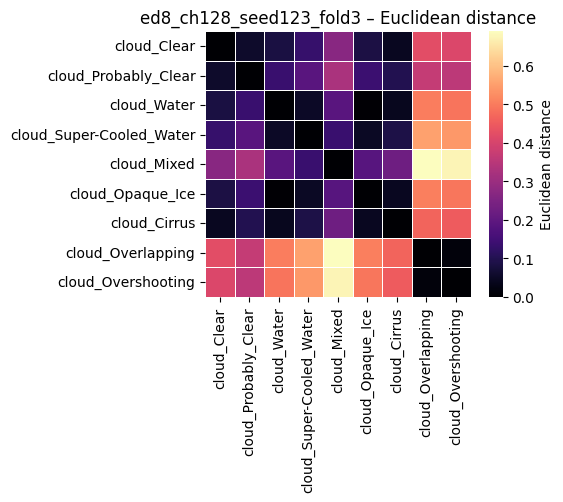

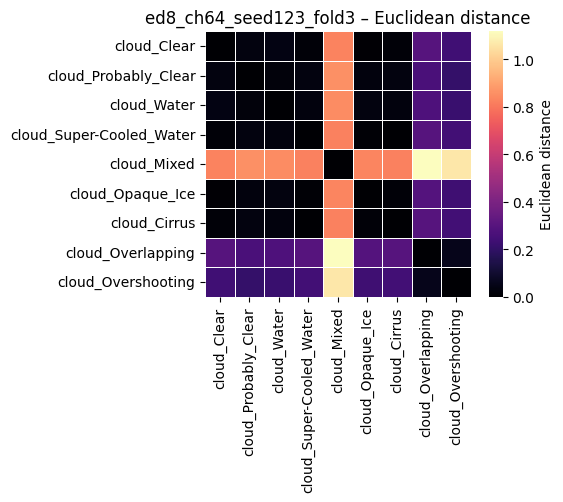

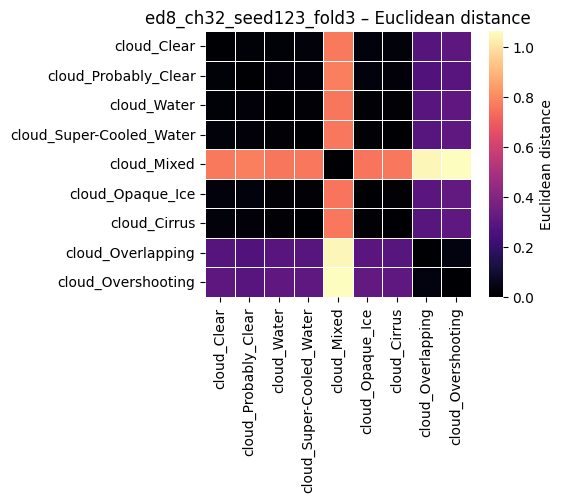

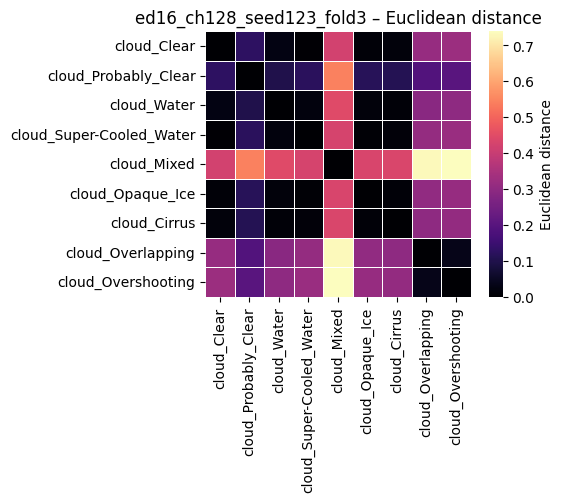

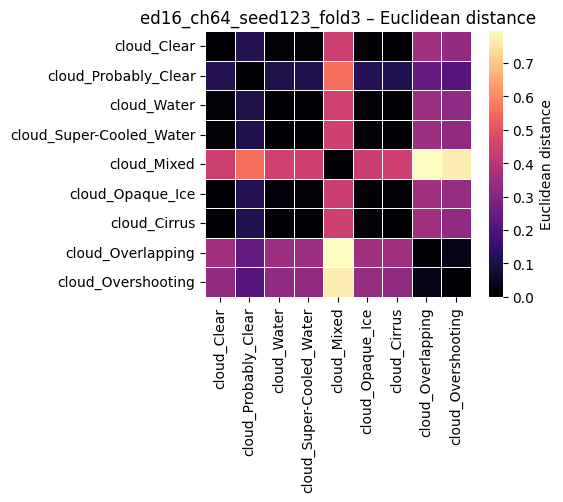

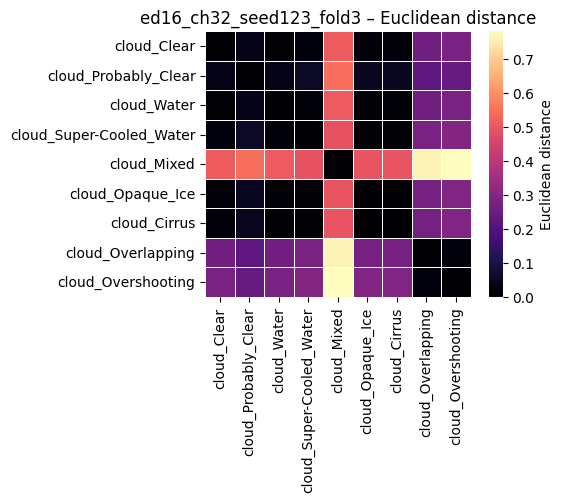

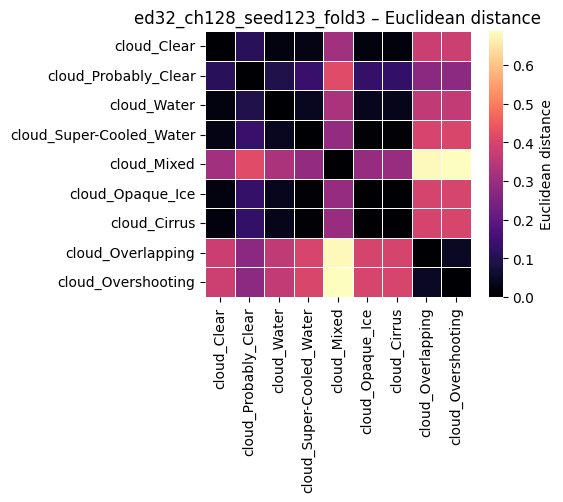

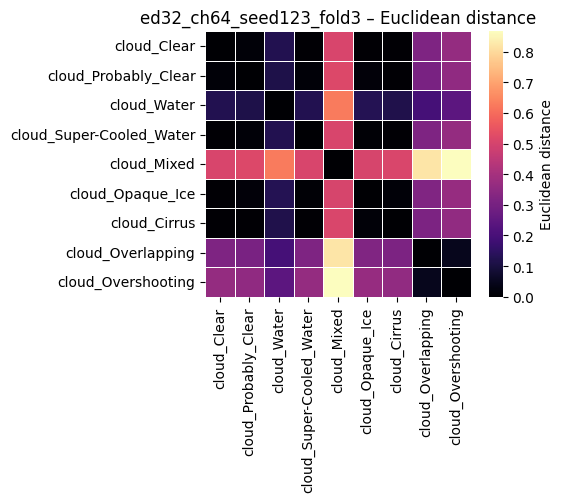

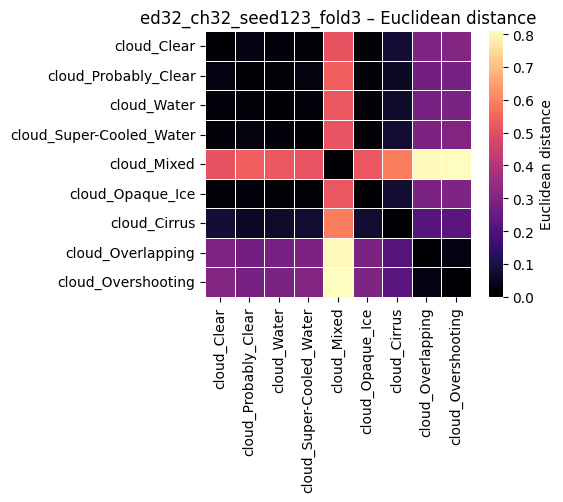

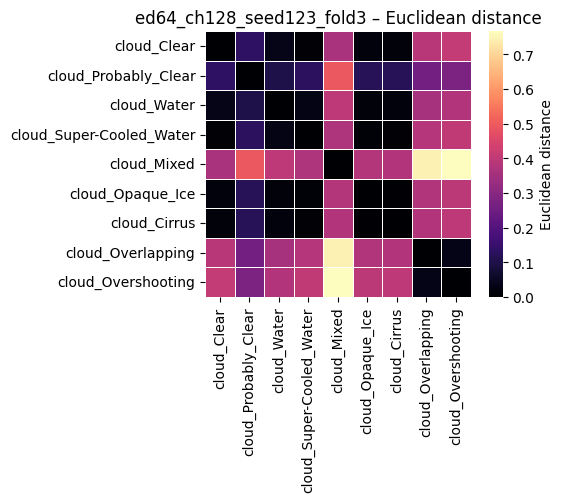

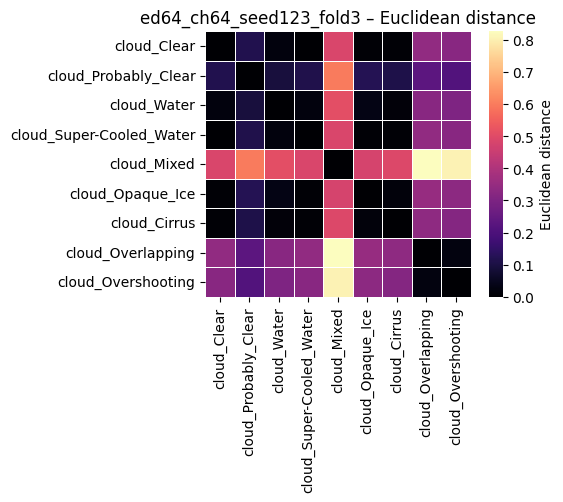

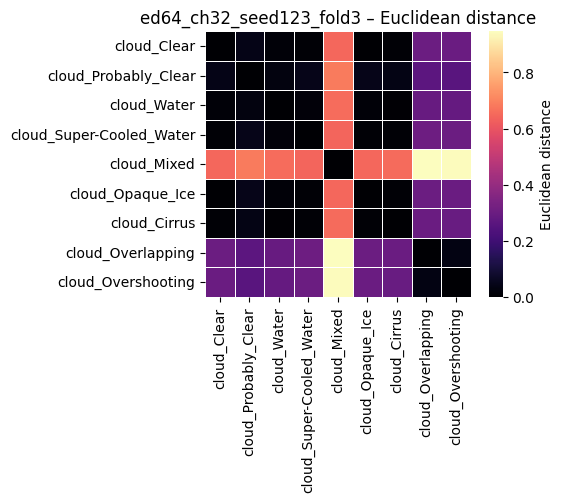

In [ ]:
ckpt_paths = [
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed64_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed64_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed64_ch32_seed123_fold3.pt",
]

for ckpt in ckpt_paths:
    plot_cloud_euclidean_heatmap(
        ckpt,
        masks=masks,
        df_cols=df_cols,
        device=device,
        normalize=False   # set True if scale varies across models
    )


### tSNE

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize_cloud_embeddings_independent(
    ckpt_paths,
    masks,
    df_cols,
    device="cuda",
    tsne_perplexity=5,
    tsne_seed=42,
):
    """
    Visualize cloud embeddings from multiple checkpoints.
    Each checkpoint gets its OWN t-SNE (independent mode).
    """

    cloud_labels = list(np.array(df_cols)[masks["mask_cloud"]])
    num_ckpts = len(ckpt_paths)
    all_cloud_latents = {}
    model_names = []

    # -------------------- Load models & embeddings --------------------
    for ckpt_path in ckpt_paths:
        ckpt = torch.load(ckpt_path, map_location=device)
        config = ckpt["config"]

        model = TemporalWindowAutoEncoder(
            in_dim=config["in_dim"],
            embed_dim=config["embed_dim"],
            window=config["window"],
            conv_hidden=config.get("conv_hidden", 128),
            dropout=config.get("dropout", 0.1),
            use_attention=config.get("use_attention", False),
            cloud_embed_dim=config.get("cloud_embed_dim", 3),
            mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool),
        ).to(device)

        model.load_state_dict(ckpt["model_state"], strict=False)
        model.eval()

        raw = model.cloud_emb.weight.detach().cpu()  # [C, D]

        # Per-model normalization (kept to match your original intent)
        min_vals = raw.min(dim=0, keepdim=True).values
        max_vals = raw.max(dim=0, keepdim=True).values
        cloud_latents = ((raw - min_vals) / (max_vals - min_vals + 1e-6)).numpy()

        model_name = ckpt_path.split("/")[-1].replace(".pt", "")
        all_cloud_latents[model_name] = cloud_latents
        model_names.append(model_name)

        # Print embeddings
        print(f"\n========================")
        print(f"Cloud latents for: {model_name}")
        for label, vec in zip(cloud_labels, cloud_latents):
            vec_str = ", ".join([f"{v:.4f}" for v in vec])
            print(f"{label:20s}: [{vec_str}]")
        print("========================\n")

    # -------------------- Plotting --------------------
    n_cols = 2
    n_rows = (num_ckpts + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    colors = plt.cm.tab10(np.arange(len(cloud_labels)))

    for i, model_name in enumerate(model_names):
        cloud_latents = all_cloud_latents[model_name]

        tsne = TSNE(
            n_components=2,
            perplexity=tsne_perplexity,
            random_state=tsne_seed,
            init="pca",
        )
        cloud_2d = tsne.fit_transform(cloud_latents)

        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]

        for j, label in enumerate(cloud_labels):
            ax.scatter(
                cloud_2d[j, 0],
                cloud_2d[j, 1],
                color=colors[j],
                s=80,
            )
            ax.text(
                cloud_2d[j, 0] + 0.03,
                cloud_2d[j, 1] + 0.03,
                label,
                fontsize=8,
            )

        ax.set_title(model_name)
        ax.set_xlabel("t-SNE dim 1")
        ax.set_ylabel("t-SNE dim 2")

    # Disable empty axes
    for k in range(num_ckpts, n_rows * n_cols):
        axes[k // n_cols, k % n_cols].axis("off")

    plt.tight_layout()
    plt.show()

    return all_cloud_latents



Cloud latents for: ed8_ch256_seed123_fold3
cloud_Clear         : [0.4653, 0.9970, 0.0000]
cloud_Probably_Clear: [0.1787, 0.5081, 0.6606]
cloud_Water         : [0.3827, 0.6137, 0.3706]
cloud_Super-Cooled_Water: [0.2369, 0.5130, 0.3761]
cloud_Mixed         : [0.3625, 0.6683, 0.0801]
cloud_Opaque_Ice    : [0.9979, 0.0000, 0.0133]
cloud_Cirrus        : [0.2932, 0.5611, 0.4735]
cloud_Overlapping   : [0.2042, 0.4163, 0.6851]
cloud_Overshooting  : [0.0000, 0.1340, 0.9978]


Cloud latents for: ed8_ch128_seed123_fold3
cloud_Clear         : [0.5216, 0.6338, 0.4759]
cloud_Probably_Clear: [0.0000, 0.9989, 0.0087]
cloud_Water         : [0.2938, 0.8068, 0.2302]
cloud_Super-Cooled_Water: [0.5983, 0.4793, 0.3960]
cloud_Mixed         : [0.5315, 0.3712, 0.5091]
cloud_Opaque_Ice    : [0.3690, 0.6856, 0.3110]
cloud_Cirrus        : [0.0765, 0.5680, 0.0000]
cloud_Overlapping   : [0.9423, 0.0000, 0.4654]
cloud_Overshooting  : [0.9986, 0.0894, 0.9985]


Cloud latents for: ed8_ch64_seed123_fold3
cloud_Clear  

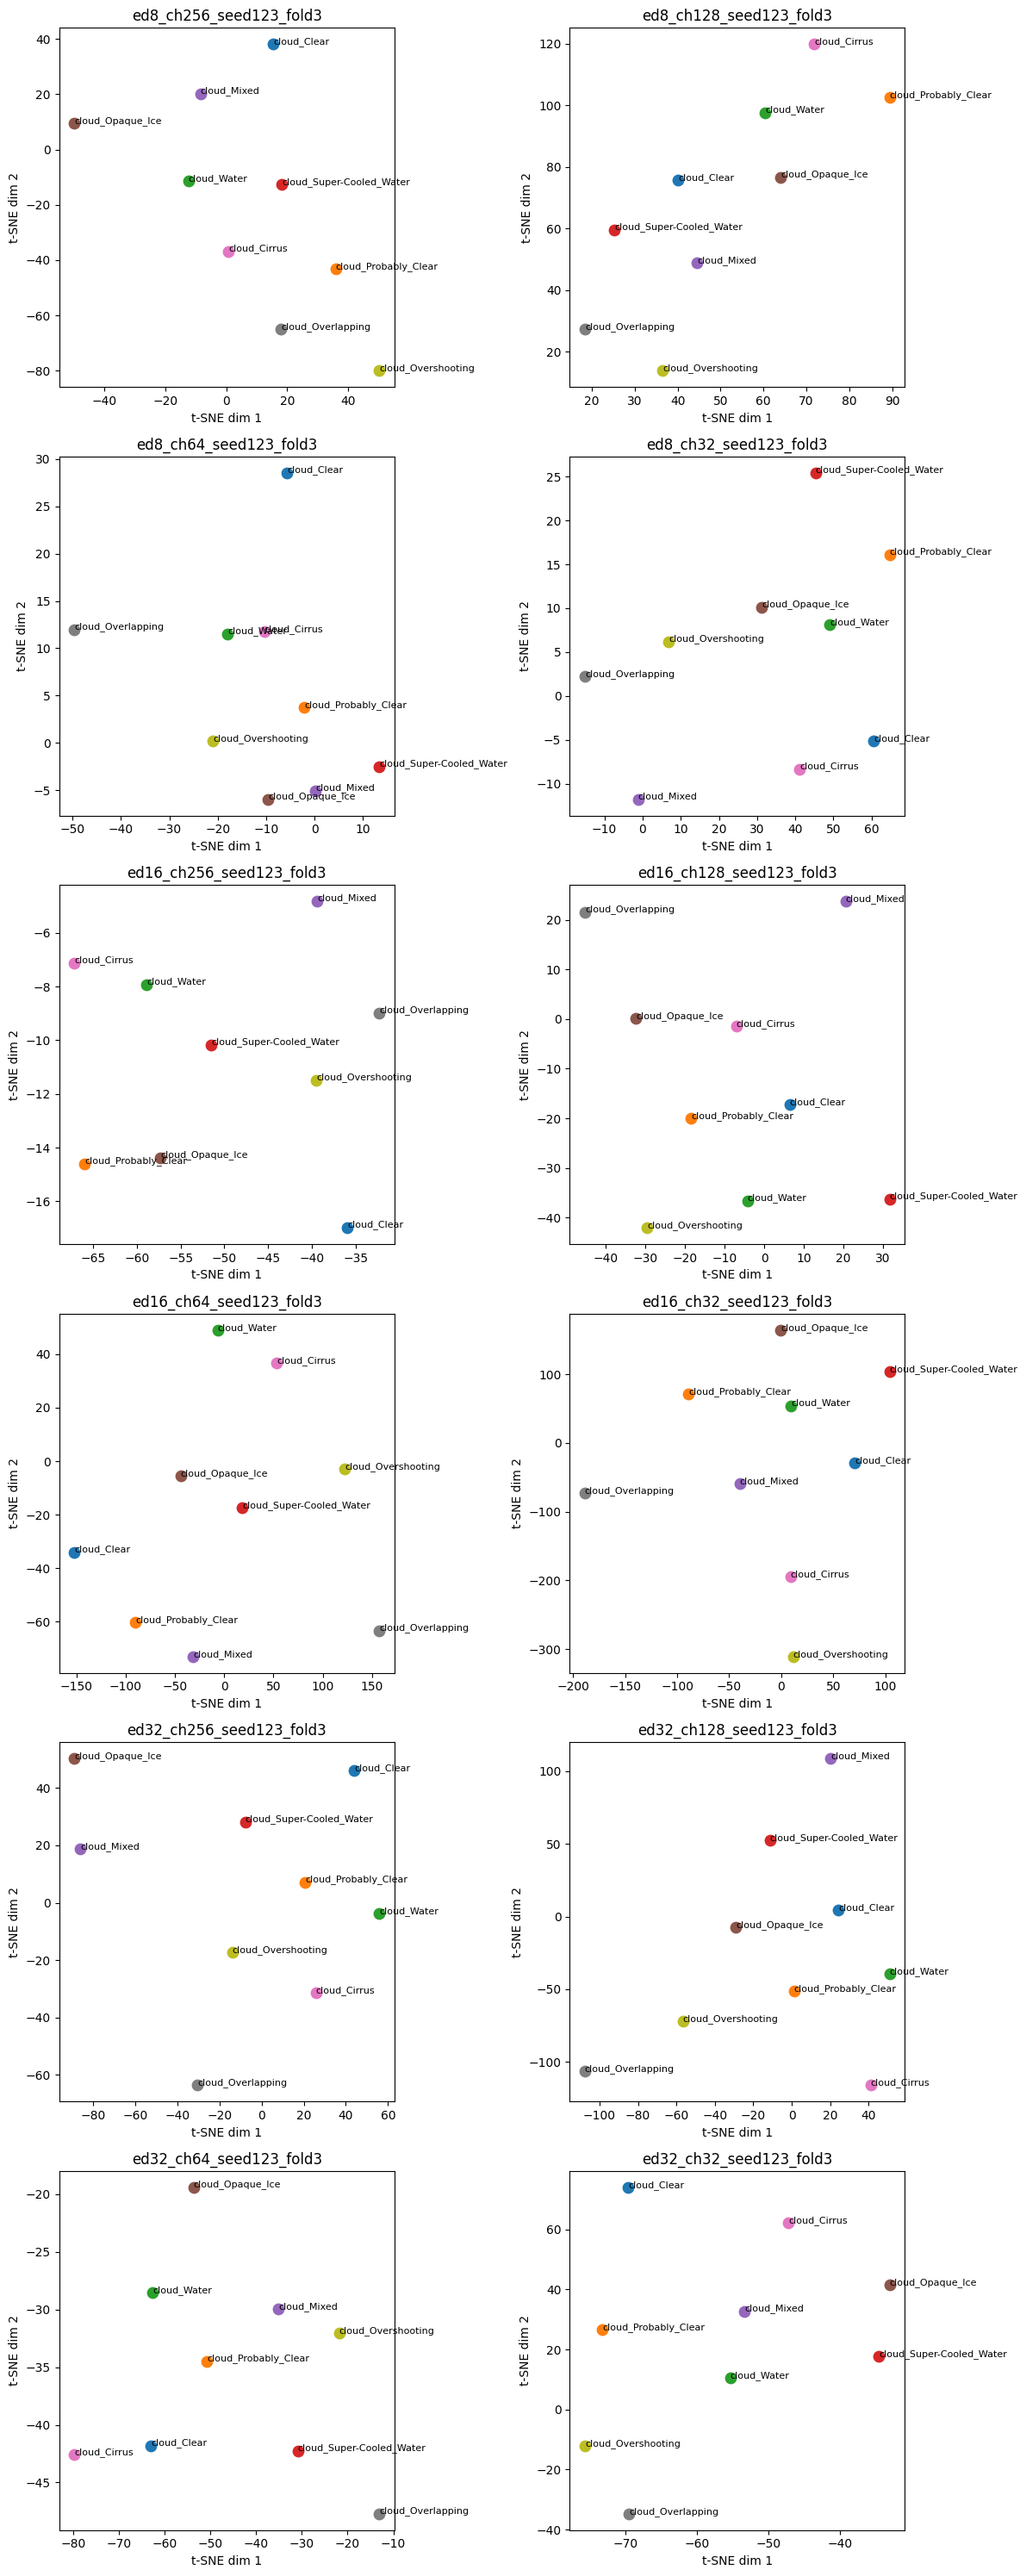

In [ ]:
ckpt_paths = [
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold3.pt",
]

all_latents = visualize_cloud_embeddings_independent(
    ckpt_paths,
    masks=masks,
    df_cols=df_cols,
    device=device,
)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_cloud_embeddings_multi_fixed(ckpt_paths, masks, df_cols, device="cuda"):
    """
    Visualize cloud embeddings from multiple checkpoints,
    2 subplots per row, using a shared t-SNE projection for consistent axes.
    Returns all cloud_latents as a dict.
    """

    cloud_labels = list(np.array(df_cols)[masks["mask_cloud"]])
    num_ckpts = len(ckpt_paths)
    all_cloud_latents = {}
    model_names = []

    # --- Load all cloud embeddings first ---
    all_latents_concat = []
    lengths = []

    for ckpt_path in ckpt_paths:
        ckpt = torch.load(ckpt_path, map_location=device)
        config = ckpt["config"]

        model = TemporalWindowAutoEncoder(
            in_dim=config["in_dim"],
            embed_dim=config["embed_dim"],
            window=config["window"],
            conv_hidden=config.get("conv_hidden", 128),
            dropout=config.get("dropout", 0.1),
            use_attention=config.get("use_attention", False),
            cloud_embed_dim=config.get("cloud_embed_dim", 3),
            mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool)
        ).to(device)

        model.load_state_dict(ckpt["model_state"], strict=False)
        model.eval()

        raw = model.cloud_emb.weight.detach().cpu()     # [C, D]
        min_vals = raw.min(dim=0, keepdim=True).values
        max_vals = raw.max(dim=0, keepdim=True).values
        cloud_latents_norm = (raw - min_vals) / (max_vals - min_vals + 1e-6)
        cloud_latents = cloud_latents_norm.numpy()


        model_name = ckpt_path.split("/")[-1].replace(".pt", "")
        all_cloud_latents[model_name] = cloud_latents
        model_names.append(model_name)
        all_latents_concat.append(cloud_latents)
        lengths.append(cloud_latents.shape[0])

        # Print latents with names
        print(f"\n========================")
        print(f"Cloud latents for: {model_name}")
        for label, vec in zip(cloud_labels, cloud_latents):
            vec_str = ", ".join([f"{v:.4f}" for v in vec])
            print(f"{label:20s}: [{vec_str}]")
        print("========================\n")

    # --- Concatenate for shared t-SNE ---
    all_latents_concat = np.vstack(all_latents_concat)
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    all_latents_2d = tsne.fit_transform(all_latents_concat)

    # --- Prepare subplots ---
    n_cols = 2
    n_rows = (num_ckpts + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    # --- Split t-SNE results back per model ---
    start_idx = 0
    for i, model_name in enumerate(model_names):
        end_idx = start_idx + lengths[i]
        cloud_2d = all_latents_2d[start_idx:end_idx]
        start_idx = end_idx

        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]

        colors = plt.cm.tab10(np.arange(len(cloud_labels)))
        for j, label in enumerate(cloud_labels):
            ax.scatter(cloud_2d[j, 0], cloud_2d[j, 1], color=colors[j], s=80)
            ax.text(cloud_2d[j, 0]+0.05, cloud_2d[j, 1]+0.05, label, fontsize=8)

        ax.set_title(model_name)
        ax.set_xlabel("t-SNE dim 1")
        ax.set_ylabel("t-SNE dim 2")

    # Turn off empty subplots
    for k in range(len(ckpt_paths), n_rows * n_cols):
        row = k // n_cols
        col = k % n_cols
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

    return all_cloud_latents



Cloud latents for: ed8_ch128_seed123_fold3
cloud_Clear         : [0.5633, 0.3619, 0.5721]
cloud_Probably_Clear: [0.4821, 0.4414, 0.4885]
cloud_Water         : [0.6925, 0.2503, 0.6969]
cloud_Super-Cooled_Water: [0.7780, 0.1837, 0.7776]
cloud_Mixed         : [1.0000, 0.0000, 1.0000]
cloud_Opaque_Ice    : [0.6963, 0.2457, 0.6998]
cloud_Cirrus        : [0.6345, 0.3050, 0.6422]
cloud_Overlapping   : [0.0000, 1.0000, 0.0000]
cloud_Overshooting  : [0.0195, 0.9781, 0.0123]


Cloud latents for: ed8_ch64_seed123_fold3
cloud_Clear         : [0.1995, 0.7223, 0.2755]
cloud_Probably_Clear: [0.1845, 0.7391, 0.2414]
cloud_Water         : [0.2134, 0.7059, 0.2339]
cloud_Super-Cooled_Water: [0.2152, 0.7027, 0.2696]
cloud_Mixed         : [1.0000, 0.0000, 1.0000]
cloud_Opaque_Ice    : [0.1928, 0.7146, 0.2690]
cloud_Cirrus        : [0.2164, 0.7033, 0.2675]
cloud_Overlapping   : [0.0000, 1.0000, 0.0000]
cloud_Overshooting  : [0.0241, 0.9503, 0.0577]


Cloud latents for: ed8_ch32_seed123_fold3
cloud_Clear   

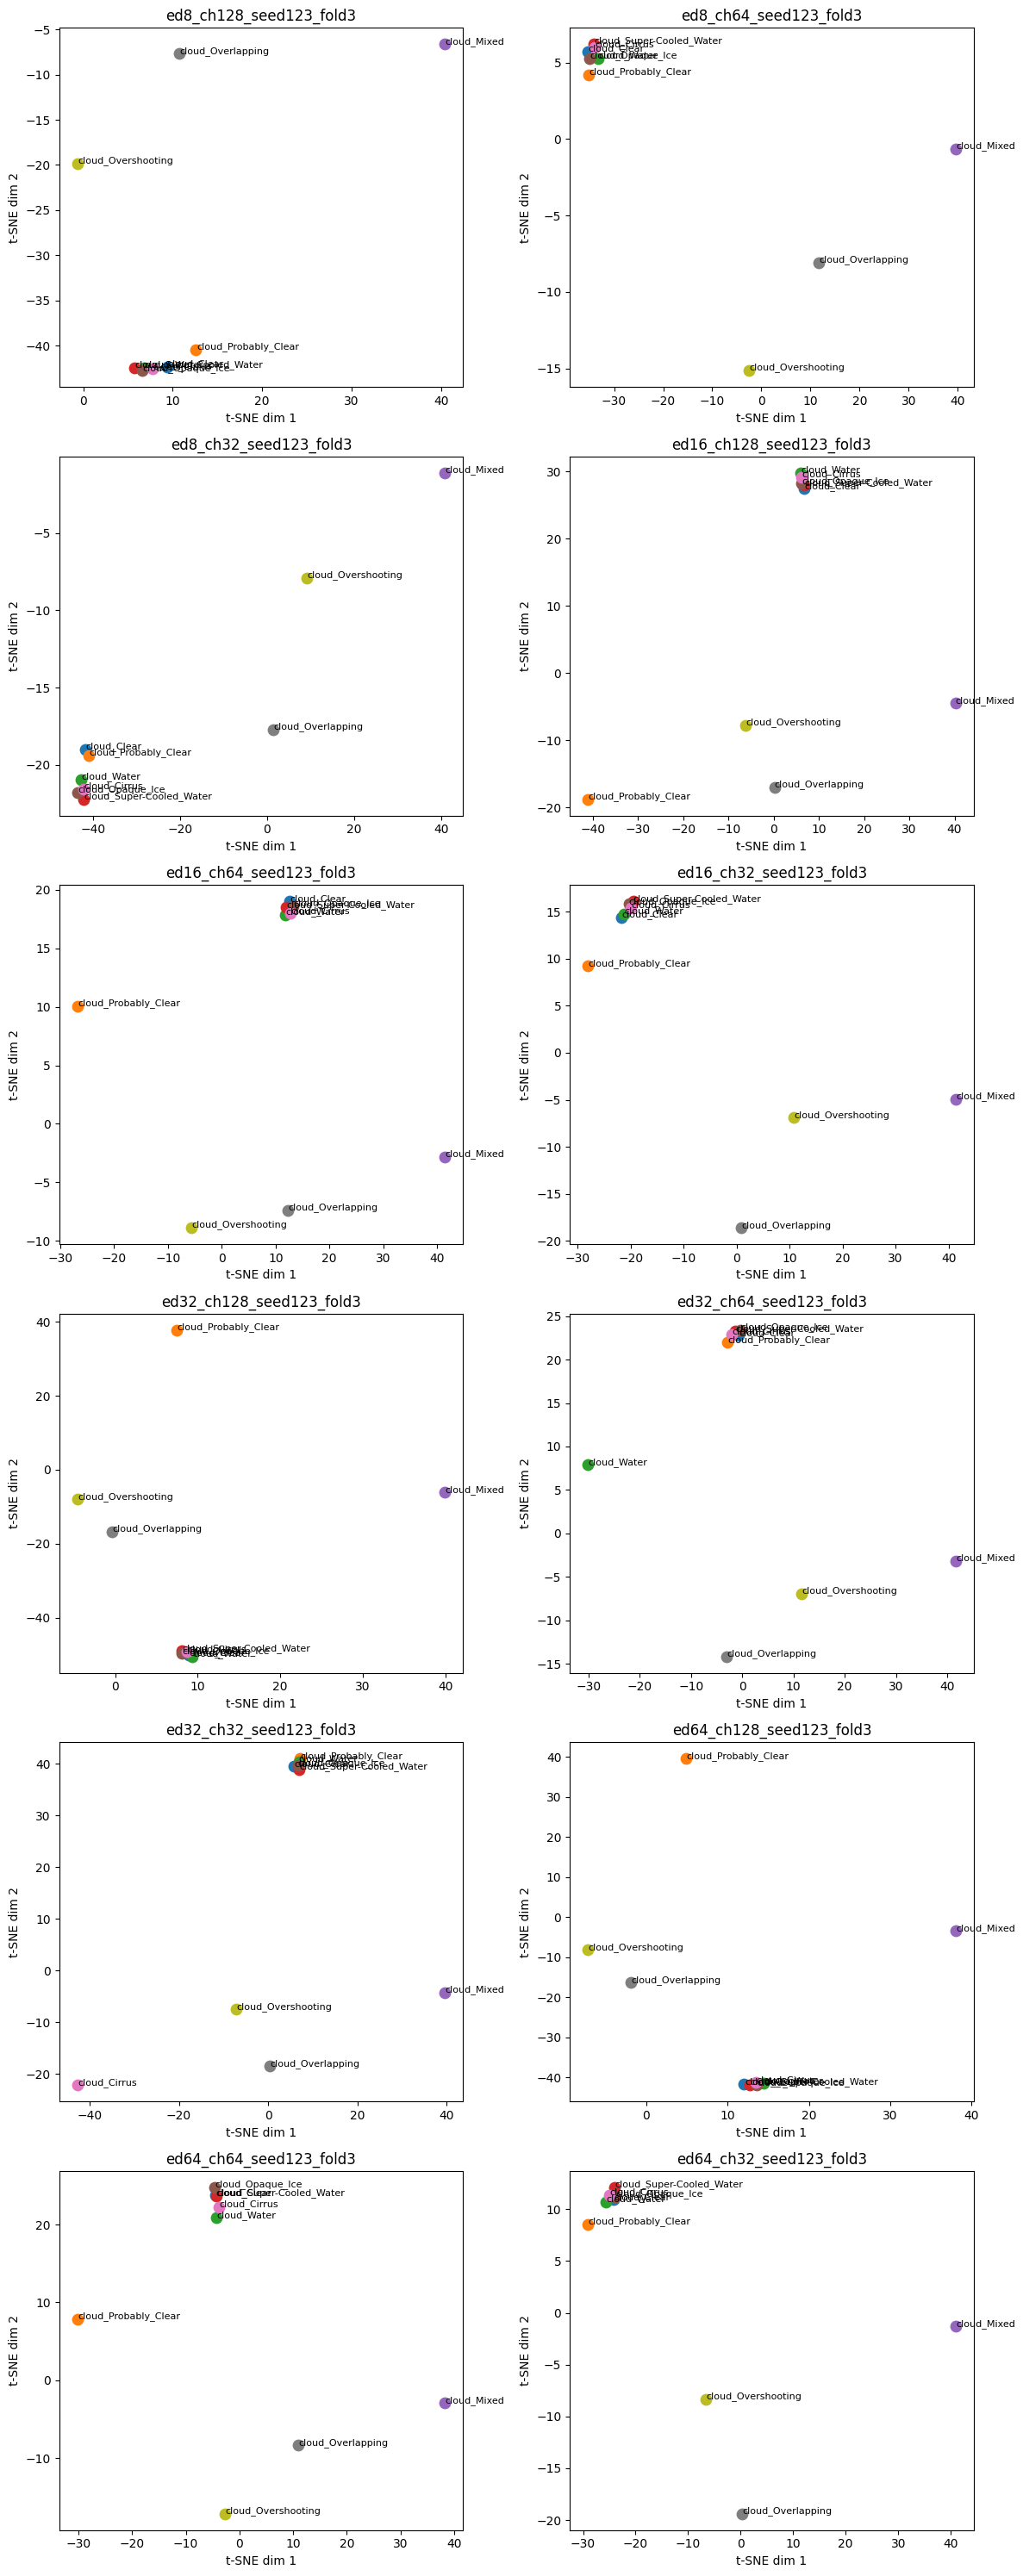


>>> Available embedding sets:
ed8_ch128_seed123_fold3 (9, 3)
ed8_ch64_seed123_fold3 (9, 3)
ed8_ch32_seed123_fold3 (9, 3)
ed16_ch128_seed123_fold3 (9, 3)
ed16_ch64_seed123_fold3 (9, 3)
ed16_ch32_seed123_fold3 (9, 3)
ed32_ch128_seed123_fold3 (9, 3)
ed32_ch64_seed123_fold3 (9, 3)
ed32_ch32_seed123_fold3 (9, 3)
ed64_ch128_seed123_fold3 (9, 3)
ed64_ch64_seed123_fold3 (9, 3)
ed64_ch32_seed123_fold3 (9, 3)


In [ ]:
ckpt_paths = [
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed8_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch32_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch256_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch128_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch64_seed123_fold3.pt",
    "/content/gdrive/MyDrive/hparam_search_encoder/ed32_ch32_seed123_fold3.pt",
]

all_latents = visualize_cloud_embeddings_multi_fixed(
    ckpt_paths,
    masks=masks,
    df_cols=df_cols,
    device=device
)

print("\n>>> Available embedding sets:")
for name in all_latents:
    print(name, all_latents[name].shape)

### **Drawing Network**

In [ ]:
import math
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.colors as colors

def visualize_adjacency_matrices(adj_matrices, df_geo, titles, graphs_per_row=2):
    num_graphs = len(adj_matrices)
    n_rows = math.ceil(num_graphs / graphs_per_row)

    fig, axs = plt.subplots(n_rows, graphs_per_row, figsize=(5 * graphs_per_row, 5 * n_rows))
    axs = np.array(axs).reshape(-1)  # Flatten in case axs is 2D

    pos = {
        idx: (row['longitude'], row['latitude'])
        for idx, row in df_geo.iterrows()
    }

    for i, (edge_index, edge_weight) in enumerate(adj_matrices):
        dummy_x = torch.ones((df_geo.shape[0], 1), dtype=torch.float32)
        data = Data(
            x=dummy_x,
            edge_index = edge_index.detach().clone().long(),
            edge_attr = edge_weight.detach().clone().float()
        )
        G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])

        edge_weights = [float(G[u][v].get("edge_attr", 1.0)) for u, v in G.edges()]
        if min(edge_weights) == max(edge_weights):
            edge_alphas = [1.0 for _ in edge_weights]
        else:
            norm = colors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights), clip=True)
            edge_alphas = [float(norm(w)) for w in edge_weights]
        ax = axs[i]
        ax.set_title(titles[i], fontsize=14)
        nx.draw_networkx_nodes(G, pos, node_size=200, node_color="#1f78b4", alpha=0.9, ax=ax, edgecolors='white')
        nx.draw_networkx_labels(G, pos, font_size=7, ax=ax)
        for (u, v), alpha in zip(G.edges(), edge_alphas):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='black', alpha=alpha, width=1.0, ax=ax)
        ax.set_axis_off()
        ax.set_facecolor('#f8f9fa')

    # Hide any extra unused subplots
    for j in range(num_graphs, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()
    import torch.nn.functional as F
# -----------------------------------------------------------

def build_adj_with_sharpening(Z, tau=0.2,k=5):

    Z = Func.normalize(Z - Z.mean(dim=0, keepdim=True), p=2, dim=-1)
    A = (Z @ Z.T + 1) / 2
    A = A ** (1/tau)    # temperature sharpening
    A.fill_diagonal_(1.0)

    # --- Top-k sparsification then row normalization---
    A_k = topk_row(A, k)

    def to_edges(A):
        i, j = torch.where(A > 0)
        w = A[i, j]
        return torch.stack([i, j], dim=0), w

    return to_edges(A_k)


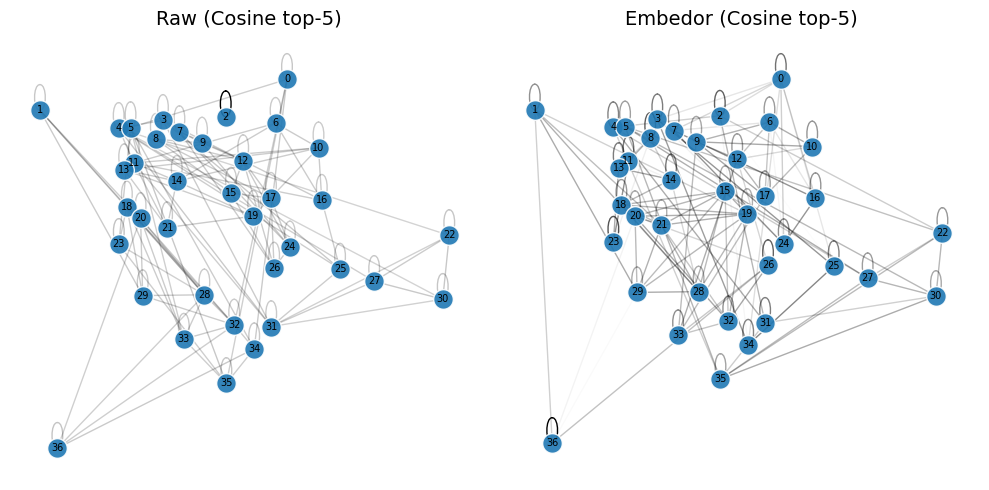

In [ ]:
# --- 1. Load model and extract embeddings ---
base_dir = "/content/gdrive/MyDrive/hparam_search_encoder"
ckpt = torch.load(os.path.join(base_dir, "ed16_ch64_seed123_fold3.pt"), map_location=device)

model = TemporalWindowAutoEncoder(
    in_dim=masks["mask_embed"].sum().item(),
    embed_dim=16,
    conv_hidden=64,
    window=12,
    use_attention=True,
    mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool)
).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

with torch.no_grad():
    x_window = val_data[-12:].unsqueeze(0).to(device)  # [1, W, N, F]
    x_window = x_window[..., torch.tensor(masks["mask_embed"], dtype=torch.bool, device=device)]
    _, Z = model(x_window)  # [1, N, embed_dim]
    Z = Z.squeeze(0).cpu()  # [N, embed_dim]

# --- Raw adjacency (cosine from last step) ---
X_last = x_window[0, -1].cpu()  # [N, F]

A_embed = build_adj_with_sharpening(X_last, tau=0.2, k=5)
edge_index_raw, edge_weight_raw = A_embed

# --- Build adjacency variants from learned embeddings ---
A_embed = build_adj_with_sharpening(Z, tau=0.2, k=5)
edge_index_embed, edge_weight_embed = A_embed

# --- 5. Prepare for visualization ---
titles = ["Raw (Cosine top-5)", "Embedor (Cosine top-5)"]
adj_matrices = [
    (edge_index_raw, edge_weight_raw),
    (edge_index_embed, edge_weight_embed),
]

# df_geo: DataFrame with 'latitude' and 'longitude' columns indexed by node ID
visualize_adjacency_matrices(adj_matrices, df_geo, titles, graphs_per_row=2)


# Gate RecurrentGCN

## basic model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric.nn.norm import PairNorm


class GraphGateContext(nn.Module):
    """
    Context-dependent gate over [A_static, A_dynamic, A_wind].
    pi_t = softmax( MLP(context_t) )
    """
    def __init__(self, in_dim, hidden=64, n_graphs=3, tau=0.7):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, n_graphs)
        )
        self.tau = tau

    def forward(self, ctx):   # ctx: [B, in_dim] or [in_dim]
        if ctx.ndim == 1:
            ctx = ctx.unsqueeze(0)
        logits = self.mlp(ctx) / self.tau     # [B, n_graphs]
        pi = torch.softmax(logits, dim=-1)    # [B, n_graphs]
        return pi.squeeze(0)                  # [n_graphs] if B==1

class EmbeddingNet(nn.Module):
    def __init__(self, in_dim, embed_dim, dropout=0.1):
        super().__init__()
        hidden_dim = max(in_dim // 2, embed_dim * 2)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.ReLU(),
            nn.BatchNorm1d(embed_dim)
        )
    def forward(self, x):
        refined = self.mlp(x)
        return Func.normalize(refined, p=2, dim=-1)



class RecurrentGCN(nn.Module):
    def __init__(self, node_feature_dim, filters, horizon=1, alpha=0.5, dropout=0.2):
        """
        Args:
            node_feature_dim (int): Input feature dimension per node
            filters (int or list[int]): Number of filters per layer.
                                        If int -> same filters for all layers.
                                        If list -> arbitrary filters per layer.
            horizon (int): Forecasting horizon
            alpha (float): Residual mixing coefficient
            dropout (float): Dropout probability
        """
        super().__init__()
        self.alpha = alpha
        self.dropout = nn.Dropout(dropout)

        # Ensure filters is a list
        if isinstance(filters, int):
            filters = [filters]
        self.n_layers = len(filters)

        self.recurrent_layers = nn.ModuleList()
        self.residual_projs = nn.ModuleList()
        self.norms = nn.ModuleList()

        in_dim = node_feature_dim
        for out_dim in filters:
            self.recurrent_layers.append(GConvGRU(in_dim, out_dim, K=1))
            self.residual_projs.append(nn.Linear(in_dim, out_dim))
            self.norms.append(PairNorm(scale=2))
            in_dim = out_dim

        # Prediction heads take the last layer’s dimension
        self.heads = nn.ModuleList([nn.Linear(filters[-1], 1) for _ in range(horizon)])

    def forward(self, x_seq, edge_index, edge_weight, return_hidden=False):
        """
        Args:
            x_seq: [lags, N, F]
            edge_index, edge_weight: graph structure
            return_hidden: if True, also return list of hidden states per layer
        """
        hidden_states = [None] * self.n_layers

        for t in range(x_seq.shape[0]):
            out = x_seq[t]
            for layer, (gru, res_proj, norm) in enumerate(
                zip(self.recurrent_layers, self.residual_projs, self.norms)
            ):
                h_prev = hidden_states[layer]
                h_t = gru(out, edge_index, edge_weight, h_prev)
                residual = res_proj(out)
                h_t = (1 - self.alpha) * h_t + self.alpha * residual
                h_t = Func.relu(h_t)
                # h_t = norm(h_t)   # enable if you want normalization
                h_t = self.dropout(h_t)
                hidden_states[layer] = h_t
                out = h_t

        final_hidden = hidden_states[-1]
        outs = [head(final_hidden) for head in self.heads]
        pred = torch.cat(outs, dim=1)  # [N, horizon]

        if return_hidden:
            return pred, hidden_states
        return pred


## advance model
(layer fusion-Horizon based)


In [ ]:
#GconvGRU
class GraphGateNodewise(nn.Module):
    """
    Node-wise context-dependent gate over multiple adjacency types.
    Input:
        ctx: [N, in_dim] — context vector per node
    Output:
        pi: [N, n_graphs] — mixture weights for each adjacency type, per node
        Output graphs:  [static, dynamic, wind]
    """
    def __init__(self, in_dim, hidden=16, n_graphs=3, tau=1, learn_tau=False):
        super().__init__()
        self.n_graphs = n_graphs
        self.learn_tau = learn_tau

        # Learnable temperature if requested
        self.tau = nn.Parameter(torch.log(torch.tensor(tau))) if learn_tau else tau

        # MLP applied per node
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, n_graphs),
            nn.LayerNorm(n_graphs)  # optional: stabilize logits
        )

    def forward(self, ctx):
        """
        ctx: [N, in_dim] or [B, N, in_dim]
        Returns: [N, n_graphs] or [B, N, n_graphs]
        """
        if ctx.ndim == 2:
            # single graph: [N, in_dim] -> [N, n_graphs]
            tau = self.tau.exp() if self.learn_tau else self.tau
            logits = self.mlp(ctx) / tau
            pi = torch.softmax(logits, dim=-1)
            return pi

        elif ctx.ndim == 3:
            # batched graph: [B, N, in_dim] -> [B, N, n_graphs]
            B, N, F = ctx.shape
            ctx_flat = ctx.view(B * N, F)
            tau = self.tau.exp() if self.learn_tau else self.tau
            logits_flat = self.mlp(ctx_flat) / tau
            pi = torch.softmax(logits_flat, dim=-1)
            return pi.view(B, N, self.n_graphs)
        else:
            raise ValueError(f"Unsupported ctx shape {ctx.shape}")

class RecurrentGCN(nn.Module):
    def __init__(
        self,
        node_feature_dim,        # F_in  : input feature dimension per node
        filters,                 # [D1, D2, ..., DL] hidden dims per layer
        horizon=1,               # H     : number of forecasting steps
        alpha=0.5,
        dropout=0.2,
        mode="last",             # "last" or "fusion_learnable"
    ):
        super().__init__()
        self.alpha = alpha
        self.dropout = nn.Dropout(dropout)
        self.mode = mode
        self.horizon = horizon

        if isinstance(filters, int):
            filters = [filters]
        self.n_layers = len(filters)  # L layers

        self.recurrent_layers = nn.ModuleList()
        self.residual_projs = nn.ModuleList()

        in_dim = node_feature_dim   # F_in
        for out_dim in filters:     # Dₗ
            self.recurrent_layers.append(GConvGRU(in_dim, out_dim, K=1)) # [N, Dₗ]
            self.residual_projs.append(nn.Linear(in_dim, out_dim))       # [N, Dₗ]
            in_dim = out_dim

        # One prediction head per horizon: maps [N, D_L] → [N, 1]
        self.heads = nn.ModuleList([nn.Linear(filters[-1], 1) for _ in range(horizon)])

        if self.mode == "fusion_learnable":
            self.fusion_weights = nn.Parameter(torch.ones(horizon, self.n_layers) / self.n_layers)

            # Projection: [N, Dₗ] → [N, D_L]
            self.projections = nn.ModuleList([
                nn.Linear(d, filters[-1]) if d != filters[-1] else nn.Identity()
                for d in filters
            ])

    # -----------------------------------------------------------------
    # x_seq:          [W, N, F_in]
    # edge_index:     [2, E]
    # edge_weight:    [E]
    # return_hidden:  returns list of layer hidden states [N, Dₗ]
    # -----------------------------------------------------------------
    def forward(self, x_seq, edge_index, edge_weight, return_hidden=False):
        # Hidden state list: one tensor per layer → [N, Dₗ]
        hidden_states = [None] * self.n_layers

        # ----- Recurrence over window length W -----
        for w in range(x_seq.shape[0]):     # w = 0..W-1
            out = x_seq[w]                 # [N, F_in] at w=0, then [N, Dₗ]

            for layer, (gru, res_proj) in enumerate(
                zip(self.recurrent_layers, self.residual_projs)
            ):
                h_prev = hidden_states[layer]           # [N, Dₗ] or None
                h_w = gru(out, edge_index, edge_weight, h_prev)  # [N, Dₗ]
                residual = res_proj(out)                # [N, Dₗ]

                h_w = (1 - self.alpha) * h_w + self.alpha * residual   # [N, Dₗ]
                h_w = Func.relu(h_w)                    # [N, Dₗ]
                # h_w = norm(h_w)                       # (optional)
                h_w = self.dropout(h_w)                 # [N, Dₗ]

                hidden_states[layer] = h_w
                out = h_w                               # feed to next GCN layer

        # ----- Horizon Predictions -----
        if self.mode == "last":
            final_hidden = hidden_states[-1]             # [N, D_L]
            outs = [head(final_hidden) for head in self.heads]  # H × [N, 1]

        elif self.mode == "fusion_learnable":
            weights = (torch.softmax(self.fusion_weights, dim=-1))  # [H, L]

            outs = []
            for h, head in enumerate(self.heads):        # horizon h
                # blended: [N, D_L]
                blended = sum(
                    weights[h, l] * self.projections[l](hidden_states[l])
                    for l in range(self.n_layers)
                )
                outs.append(head(blended))               # [N, 1]

        pred = torch.cat(outs, dim=1)  # → [N, H]

        if return_hidden:
            return pred, hidden_states
        return pred


## GConvLSTM

In [ ]:
# GConvLSTM
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch_geometric_temporal.nn.recurrent import GConvLSTM
from torch_geometric.nn.norm import PairNorm

class GraphGateContext(nn.Module):
    """
    Context-dependent gate over [A_static, A_dynamic, A_wind].
    pi_t = softmax( MLP(context_t) )
    """
    def __init__(self, in_dim, hidden=64, n_graphs=3, tau=0.7):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, n_graphs)
        )
        self.tau = tau

    def forward(self, ctx):   # ctx: [B, in_dim] or [in_dim]
        if ctx.ndim == 1:
            ctx = ctx.unsqueeze(0)
        logits = self.mlp(ctx) / self.tau     # [B, n_graphs]
        pi = torch.softmax(logits, dim=-1)    # [B, n_graphs]
        return pi.squeeze(0)                  # [n_graphs] if B==1

class EmbeddingNet(nn.Module):
    def __init__(self, in_dim, embed_dim, dropout=0.1):
        super().__init__()
        hidden_dim = max(in_dim // 2, embed_dim * 2)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.ReLU(),
            nn.BatchNorm1d(embed_dim)
        )
    def forward(self, x):
        refined = self.mlp(x)
        return Func.normalize(refined, p=2, dim=-1)

class RecurrentGCN(nn.Module):
    def __init__(
        self,
        node_feature_dim,
        filters,
        horizon=1,
        alpha=0.5,
        dropout=0.2,
        mode="last",
        fusion_weights=None,
        learn_fusion=False,
    ):
        super().__init__()
        self.alpha = alpha
        self.dropout = nn.Dropout(dropout)
        self.mode = mode
        self.horizon = horizon
        self.learn_fusion = learn_fusion

        if isinstance(filters, int):
            filters = [filters]
        self.n_layers = len(filters)

        self.recurrent_layers = nn.ModuleList()
        self.residual_projs = nn.ModuleList()
        self.norms = nn.ModuleList()

        in_dim = node_feature_dim
        for out_dim in filters:
            self.recurrent_layers.append(GConvLSTM(in_dim, out_dim, K=1))
            self.residual_projs.append(nn.Linear(in_dim, out_dim))
            self.norms.append(PairNorm(scale=2))
            in_dim = out_dim

        # --- Prediction heads ---
        self.heads = nn.ModuleList([nn.Linear(filters[-1], 1) for _ in range(horizon)])

        if self.mode == "fusion":
            if fusion_weights is not None:
                fusion_tensor = torch.tensor(fusion_weights, dtype=torch.float32)
                self.register_buffer("fusion_weights", fusion_tensor)
            elif learn_fusion:
                self.fusion_weights = nn.Parameter(torch.ones(horizon, self.n_layers) / self.n_layers)
            else:
                fusion_tensor = torch.ones(horizon, self.n_layers) / self.n_layers
                self.register_buffer("fusion_weights", fusion_tensor)

            self.projections = nn.ModuleList([
                nn.Linear(d, filters[-1]) if d != filters[-1] else nn.Identity()
                for d in filters
            ])

    def forward(self, x_seq, edge_index, edge_weight, return_hidden=False):
        # Initialize hidden and cell states for each layer
        hidden_states = [None] * self.n_layers
        cell_states = [None] * self.n_layers

        for t in range(x_seq.shape[0]):
            out = x_seq[t]
            for layer, (lstm, res_proj, norm) in enumerate(
                zip(self.recurrent_layers, self.residual_projs, self.norms)
            ):
                h_prev, c_prev = hidden_states[layer], cell_states[layer]
                h_t, c_t = lstm(out, edge_index, edge_weight, h_prev, c_prev)
                residual = res_proj(out)
                h_t = (1 - self.alpha) * h_t + self.alpha * residual
                h_t = Func.relu(h_t)
                # h_t = norm(h_t)  # uncomment if needed
                h_t = self.dropout(h_t)
                hidden_states[layer], cell_states[layer] = h_t, c_t
                out = h_t

        # --- Predictions ---
        if self.mode == "last":
            final_hidden = hidden_states[-1]
            outs = [head(final_hidden) for head in self.heads]

        elif self.mode == "fusion":
            if self.learn_fusion:
                weights = torch.softmax(self.fusion_weights, dim=-1)
            else:
                weights = self.fusion_weights

            outs = []
            for h, head in enumerate(self.heads):
                blended = 0
                for l, w in enumerate(weights[h]):
                    if w.item() != 0:
                        proj = self.projections[l]
                        blended = blended + w * proj(hidden_states[l])
                outs.append(head(blended))

        pred = torch.cat(outs, dim=1)  # [N, horizon]

        if return_hidden:
            return pred, hidden_states
        return pred

# mixed Adjacency

## version 1 (depricated)

In [ ]:
def build_mixed_adjacency(
    e_window,                  # [B, W, N, Fe] full temporal window
    w_window,                  # [B, W, N, Fw] full temporal window
    g_window,                  # [B, W, N, Fg]
    Embedor,                   # window-based autoencoder (forward → z_t)
    Gater,                      # gating MLP
    WindKernel,                 # wind kernel
    A_static,                   # [N, N]
    temperature=0.5,
    topk_each=5,
    ablation_config=None,
):
    """
    Build batch-wise mixed adjacency matrices combining static, latent-based, and wind-based graphs.

    Returns:
        A_mix: [B, N, N]
        details: dict containing {pi, A_dyn, A_wind, A_static}
    """
    if ablation_config is None:
        ablation_config = {"use_static": True, "use_dynamic": True, "use_wind": True}

    B, W, N, Fe = e_window.shape

    # -----------------------------
    # 1) Latent adjacency
    # -----------------------------
    if ablation_config.get("use_dynamic", True):
        with torch.no_grad():
            _, z_t = Embedor(e_window)  # z_t: [B, N, D_latent]
        S = torch.matmul(z_t, z_t.transpose(-1, -2))  # [B, N, N]
        A_dyn = torch.softmax(S / temperature, dim=-1)
        A_dyn = topk_row_batch(A_dyn, topk_each)
    else:
        A_dyn = torch.zeros(B, N, N, device=A_static.device, dtype=A_static.dtype)

    # -----------------------------
    # 2) Wind adjacency (last timestep)
    # -----------------------------
    if ablation_config.get("use_wind", True):
        w_last_step = w_window[:, -1, :, :]  # [B, N, Fw]
        wind_dir_deg = w_last_step[..., wind_dir_pos]  # [B, N]
        wind_sp      = w_last_step[..., wind_sp_pos]   # [B, N]
        wind_dir_rad = torch.deg2rad(wind_dir_deg)
        A_wind = WindKernel(wind_sp, wind_dir_rad)     # [B, N, N] or broadcastable
        if A_wind.ndim == 2:
            A_wind = A_wind.unsqueeze(0).expand(B, N, N)
        A_wind = topk_row_batch(A_wind, topk_each)
    else:
        A_wind = torch.zeros(B, N, N, device=A_static.device, dtype=A_static.dtype)

    # -----------------------------
    # 3) Static adjacency
    # -----------------------------
    if ablation_config.get("use_static", True):
        A_s = A_static.unsqueeze(0).expand(B, -1, -1)  # [B, N, N]
    else:
        A_s = torch.zeros(B, N, N, device=A_static.device, dtype=A_static.dtype)

    # -----------------------------
    # 4) Gating weights (last timestep)
    # -----------------------------
    e_last_step = e_window[:, -1, :, :]  # [B, N, Fe]
    g_last_step = g_window[:, -1, :, :]  # [B, N, Fg]
    ctx = torch.cat([e_last_step.mean(dim=1), g_last_step.mean(dim=1)], dim=-1)  # [B, Fe+Fg]
    pi = Gater(ctx)  # [B, 3]

    mask = torch.tensor([
        ablation_config.get("use_static", True),
        ablation_config.get("use_dynamic", True),
        ablation_config.get("use_wind", True),
    ], device=e_window.device, dtype=pi.dtype)
    pi = pi * mask
    pi = pi / (pi.sum(dim=-1, keepdim=True) + 1e-12)  # normalize per batch
    pi = pi.view(pi.size(0), 1, -1)  # [B, 1, 3]
    # -----------------------------
    # 5) Mixed adjacency
    # -----------------------------
    A_mix = pi[..., 0:1] * A_s + pi[..., 1:2] * A_dyn + pi[..., 2:3] * A_wind  # [B, N, N]
    return A_mix, {"pi": pi, "A_dyn": A_dyn, "A_wind": A_wind, "A_static": A_s}


## version 2

In [ ]:

def build_mixed_adjacency(
    e_window,                 # [B, W, N, Fe]
    w_window,                 # [B, W, N, Fw]
    g_window,                 # [B, W, N, Fg] or None
    node_const,               # [N, Fc] or None Fc=5
    Gater,                    # gater NN
    WindKernel,               # wind → adjacency
    A_static,                 # [N,N]
    Embedor,                  # frozen TemporalWindowAutoEncoder
    temperature=0.5,
    topk_each=5,
    ablation_config=None,
):
    """
    Final vectorized version.
    - Embedor is frozen via torch.no_grad().
    - Energy fully vectorized via broadcasting.
    - Context normalized for stable gater learning.
    """

    if ablation_config is None:
        ablation_config = {"use_static": True, "use_dynamic": True, "use_wind": True, "use_self": True}

    dev = e_window.device
    B, W, N, _ = e_window.shape
    dtype = e_window.dtype

    # ============================================================
    # 1) CLOUD EMBEDDING (NO GRAD)
    # ============================================================
    with torch.no_grad():
        e_proc = Embedor.apply_cloud_embedding(e_window).to(dev)
        g_proc = Embedor.apply_cloud_embedding(g_window).to(dev)

    e_last = e_proc[:, -1]  # [B,N,Fe]
    g_last = g_proc[:, -1]  # [B,N,Fg]

    # node_const
    if node_const is None:
        node_const_tensor = torch.zeros(B, N, 0, device=dev)
    else:
        node_const_tensor = node_const.unsqueeze(0).expand(B, N, -1).to(dev)

    # ============================================================
    # 2) DYNAMIC adjacency from Z_last (NO GRAD)
    # ============================================================
    if ablation_config.get("use_dynamic", True):
        with torch.no_grad():
            Z_last = Embedor.encode_window(e_proc)    # [B,N,D]

        S = Z_last @ Z_last.transpose(-1, -2)         # [B,N,N]
        A_dyn = torch.softmax(S / temperature, dim=-1)
        A_dyn.diagonal(dim1=-2,dim2=-1).zero_()
        A_dyn = topk_row(A_dyn, topk_each)            # [B,N,N]
    else:
        A_dyn = torch.zeros(B, N, N, device=dev)

    # ============================================================
    # 3) Static adjacency
    # ============================================================
    if ablation_config.get("use_static", True):
        A_s = A_static.unsqueeze(0).expand(B, -1, -1).to(dev)
    else:
        A_s = torch.zeros(B, N, N, device=dev)

    # ============================================================
    # 4) WIND adjacency per lag
    # ============================================================
    if ablation_config.get("use_wind", True):
        A_wind_list = []
        for t in range(W):
            Aw_t = WindKernel(w_window[:, t],sparse=True,k=topk_each).to(device=dev, dtype=dtype)
            A_wind_list.append(Aw_t)

        A_wind_window = torch.stack(A_wind_list, dim=1)  # [B,W,N,N]
        A_wind = A_wind_window[:, -1]                    # last-lag wind adjacency
    else:
        A_wind_window = torch.zeros(B, W, N, N, device=dev)
        A_wind = torch.zeros(B, N, N, device=dev)
    # ============================================================
    # 5) create A_self (batched)
    # ============================================================
    I = torch.eye(N, device=dev, dtype=dtype)          # [N,N]
    A_self = I.unsqueeze(0).expand(B, -1, -1)          # [B,N,N]

    # ============================================================
    # 6) VECTORIZED ENERGY FOR ALL LAGS
    # ============================================================
    # expand static/dynamic to W dimension for broadcasting
    A_s_full   = A_s.unsqueeze(1).expand(-1, W, -1, -1)       # [B,W,N,N]
    A_dyn_full = A_dyn.unsqueeze(1).expand(-1, W, -1, -1)     # [B,W,N,N]

    E_static_window = pairwise_energy(e_proc, A_s_full)
    E_dyn_window    = pairwise_energy(e_proc, A_dyn_full)
    E_wind_window   = pairwise_energy(e_proc, A_wind_window)

    # ============================================================
    # 7) VARIANCES & LAST-LAG
    # ============================================================
    Var_E_static = minmax_normalize(E_static_window.var(dim=1, unbiased=False).unsqueeze(-1))
    Var_E_dyn    = minmax_normalize(E_dyn_window.var(dim=1, unbiased=False).unsqueeze(-1))
    Var_E_wind   = minmax_normalize(E_wind_window.var(dim=1, unbiased=False).unsqueeze(-1))

    E_static_last = minmax_normalize(E_static_window[:, -1].unsqueeze(-1))
    E_dyn_last    = minmax_normalize(E_dyn_window[:, -1].unsqueeze(-1))
    E_wind_last   = minmax_normalize(E_wind_window[:, -1].unsqueeze(-1))

    # degrees
    Deg_s    = minmax_normalize(A_s.sum(dim=-1, keepdim=True))
    Deg_dyn  = minmax_normalize(A_dyn.sum(dim=-1, keepdim=True))
    Deg_wind = minmax_normalize(A_wind.sum(dim=-1, keepdim=True))

    # ============================================================
    # variance of all g_window features EXCEPT last 3
    # ============================================================
    if g_window is None or g_window.shape[-1] <= 3:
        # No valid non-cloud features
        Var_g = minmax_normalize(torch.zeros(B, N, 1, device=dev))
    else:
        Fg = g_proc.shape[-1]
        g_noncloud = g_proc[..., :Fg-3]              # [B, W, N, Fg-3]

        # Variance over time (lag dimension W)
        Var_g = g_noncloud.var(dim=1, unbiased=False)  # [B, N, Fg-3]
        Var_g = minmax_normalize(Var_g)

    # ============================================================
    # 8) BUILD CONTEXT + LAYERNORM
    # ============================================================
    ctx = torch.cat([
        node_const_tensor, g_last,
        E_static_last, E_dyn_last, E_wind_last,
        Var_E_static, Var_E_dyn, Var_E_wind,
        Deg_s, Deg_dyn, Deg_wind,
        Var_g
    ], dim=-1)

    # ============================================================
    # 9) Gater → mixture
    # ============================================================
    pi = Gater(ctx)  # [B,N,4]

    mask = torch.tensor([
        ablation_config.get("use_static", True),
        ablation_config.get("use_dynamic", True),
        ablation_config.get("use_wind", True),
        ablation_config.get("use_self", True)
    ], device=dev, dtype=pi.dtype)

    pi = pi * mask
    pi = pi / (pi.sum(-1, keepdim=True) + 1e-12)

    # ============================================================
    # 10) MIXED ADJACENCY
    # ============================================================
    A_mix = (
        pi[..., 0:1] * A_s +
        pi[..., 1:2] * A_dyn +
        pi[..., 2:3] * A_wind +
        pi[..., 3:4] * A_self

    )
    # ============================================================
    # 11) Normalizing A_mix
    # ============================================================
    A_mix = topk_row(A_mix, topk_each)            # [B,N,N]

    return A_mix, {
        "pi": pi,
        "A_static": A_s,
        "A_dynamic": A_dyn,
        "A_wind": A_wind,
        "ctx": ctx,
    }

## version 3

In [ ]:
def build_mixed_adjacency(
    e_window,                 # [B, W, N, Fe]
    w_window,                 # [B, W, N, Fw]
    g_window,                 # [B, W, N, Fg] or None
    node_const,               # [N, Fc] or None
    Gater,
    WindKernel,
    A_static,                 # [N,N]
    Embedor,                  # frozen
    temperature=0.5,
    topk_each=5,
    ablation_config=None,
):
    """
    Option B:
    - ctx_tensor: concatenated tensor → Gater
    - ctx_dict  : named components → alignment & analysis
    """

    if ablation_config is None:
        ablation_config = dict(
            use_static=True,
            use_dynamic=True,
            use_wind=True,
        )

    dev   = e_window.device
    dtype = e_window.dtype
    B, W, N, _ = e_window.shape

    # ============================================================
    # 1) CLOUD EMBEDDINGS (NO GRAD)
    # ============================================================
    with torch.no_grad():
        e_proc = Embedor.apply_cloud_embedding(e_window).to(dev)
        g_proc = (
            Embedor.apply_cloud_embedding(g_window).to(dev)
            if g_window is not None else None
        )

    g_last = g_proc[:, -1] if g_proc is not None else None

    # ============================================================
    # 2) NODE CONSTANTS
    # ============================================================
    if node_const is None:
        node_const_tensor = torch.zeros(B, N, 0, device=dev)
    else:
        node_const_tensor = node_const.unsqueeze(0).expand(B, N, -1).to(dev)

    # ============================================================
    # 3) DYNAMIC ADJACENCY (NO GRAD)
    # ============================================================
    if ablation_config["use_dynamic"]:
        with torch.no_grad():
            Z_last = Embedor.encode_window(e_proc)     # [B,N,D]

        S = Z_last @ Z_last.transpose(-1, -2)          # [B,N,N]
        A_dyn = torch.softmax(S / temperature, dim=-1)
        A_dyn.diagonal(dim1=-2, dim2=-1).zero_()
        A_dyn = topk_row(A_dyn, topk_each)
    else:
        A_dyn = torch.zeros(B, N, N, device=dev)

    # ============================================================
    # 4) STATIC ADJACENCY
    # ============================================================
    if ablation_config["use_static"]:
        A_s = A_static.unsqueeze(0).expand(B, -1, -1).to(dev)
    else:
        A_s = torch.zeros(B, N, N, device=dev)

    # ============================================================
    # 5) WIND ADJACENCY (LAST LAG)
    # ============================================================
    if ablation_config["use_wind"]:
        A_wind_list = []
        for t in range(W):
            Aw_t = WindKernel(
                w_window[:, t], sparse=True, k=topk_each
            ).to(device=dev, dtype=dtype)
            A_wind_list.append(Aw_t)

        A_wind_window = torch.stack(A_wind_list, dim=1)   # [B,W,N,N]
        A_wind = A_wind_window[:, -1]
    else:
        A_wind_window = torch.zeros(B, W, N, N, device=dev)
        A_wind = torch.zeros(B, N, N, device=dev)

    # ============================================================
    # 6) ENERGY (ALL LAGS, VECTORIZED)
    # ============================================================
    A_s_full   = A_s.unsqueeze(1).expand(-1, W, -1, -1)
    A_dyn_full = A_dyn.unsqueeze(1).expand(-1, W, -1, -1)

    E_static_window = pairwise_energy(e_proc, A_s_full) # [B,W,N]
    E_dyn_window    = pairwise_energy(e_proc, A_dyn_full) # [B,W,N]
    E_wind_window   = pairwise_energy(e_proc, A_wind_window) # [B,W,N]

    # ============================================================
    # 7) CONTEXT FEATURES (NAMED)
    # ============================================================
    ctx_dict = {}

    ctx_dict["E_static_last"] = minmax_normalize(
        E_static_window[:, -1].unsqueeze(-1)
    )
    ctx_dict["E_dyn_last"] = minmax_normalize(
        E_dyn_window[:, -1].unsqueeze(-1)
    )
    ctx_dict["E_wind_last"] = minmax_normalize(
        E_wind_window[:, -1].unsqueeze(-1)
    )

    ctx_dict["Var_E_static"] = minmax_normalize(
        E_static_window.var(dim=1, unbiased=False).unsqueeze(-1)
    )
    ctx_dict["Var_E_dyn"] = minmax_normalize(
        E_dyn_window.var(dim=1, unbiased=False).unsqueeze(-1)
    )
    ctx_dict["Var_E_wind"] = minmax_normalize(
        E_wind_window.var(dim=1, unbiased=False).unsqueeze(-1)
    )

    ctx_dict["Deg_static"] = minmax_normalize(
        A_s.sum(dim=-1, keepdim=True)
    )
    ctx_dict["Deg_dyn"] = minmax_normalize(
        A_dyn.sum(dim=-1, keepdim=True)
    )
    ctx_dict["Deg_wind"] = minmax_normalize(
        A_wind.sum(dim=-1, keepdim=True)
    )

    # ---- non-cloud g variance ----
    if g_proc is None or g_proc.shape[-1] <= 3:
        ctx_dict["Var_g"] = torch.zeros(B, N, 1, device=dev)
    else:
        g_noncloud = g_proc[..., :-3]
        ctx_dict["Var_g"] = minmax_normalize(
            g_noncloud.var(dim=1, unbiased=False)
        )

    # ============================================================
    # 8) CONCATENATED CONTEXT TENSOR
    # ============================================================
    ctx_tensor = torch.cat(
        [
            node_const_tensor,
            g_last if g_last is not None else torch.zeros(B, N, 0, device=dev),
            ctx_dict["E_static_last"],
            ctx_dict["E_dyn_last"],
            ctx_dict["E_wind_last"],
            ctx_dict["Var_E_static"],
            ctx_dict["Var_E_dyn"],
            ctx_dict["Var_E_wind"],
            ctx_dict["Deg_static"],
            ctx_dict["Deg_dyn"],
            ctx_dict["Deg_wind"],
            ctx_dict["Var_g"],
        ],
        dim=-1,
    )

    # ============================================================
    # 9) GATER
    # ============================================================
    pi = Gater(ctx_tensor)  # [B,N,4]

    mask = torch.tensor(
        [
            ablation_config["use_static"],
            ablation_config["use_dynamic"],
            ablation_config["use_wind"],
        ],
        device=dev,
        dtype=pi.dtype,
    )

    pi = pi * mask
    pi = pi / (pi.sum(-1, keepdim=True) + 1e-12)

    # ============================================================
    # 10) MIX ADJACENCY
    # ============================================================
    A_mix = (
        pi[..., 0:1] * A_s
        + pi[..., 1:2] * A_dyn
        + pi[..., 2:3] * A_wind
    )

    A_mix = topk_row(A_mix, topk_each)

    return A_mix, {
        "pi": pi,
        "ctx": ctx_tensor,
        "ctx_dict": ctx_dict,
        "A_static": A_s,
        "A_dynamic": A_dyn,
        "A_wind": A_wind,
    }


# Save/Load checkpoint

In [ ]:
def save_checkpoint(model, Gater, optimizer, epoch,
                    train_losses, test_metrics_history,
                    checkpoint_path):
    """
    Save training checkpoint for the main model and Gater.

    Args:
        model: Main forecasting model
        Gater: Optional gating module (can be None)
        optimizer: Optimizer instance
        epoch: Current epoch number
        train_losses: List of training losses
        test_metrics_history: Validation/test metrics history
        checkpoint_path: Path to save checkpoint
    """
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "train_losses": train_losses,
        "test_metrics_history": test_metrics_history,
    }

    # --- Save Gater if provided ---
    if Gater is not None:
        state["gater_state"] = Gater.state_dict()

    # --- Save fusion weights if model has them ---
    if hasattr(model, "fusion_weights"):
        with torch.no_grad():
            weights = torch.softmax(model.fusion_weights, dim=-1).detach().cpu()
        state["fusion_weights"] = weights

    # --- Save to file ---
    torch.save(state, checkpoint_path)
    print(f"✅ Checkpoint saved: {checkpoint_path}")



def load_checkpoint(model, Embedor, Gater, optimizer, checkpoint_path, device):
    ckpt = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    if Embedor is not None and "embedor_state" in ckpt:
        Embedor.load_state_dict(ckpt["embedor_state"])
    if Gater is not None and "gater_state" in ckpt:
        Gater.load_state_dict(ckpt["gater_state"])

    # --- Restore fusion weights ---
    if "fusion_weights" in ckpt and hasattr(model, "fusion_weights"):
        model.fusion_weights.data.copy_(ckpt["fusion_weights"].to(device))

    return ckpt["epoch"], ckpt.get("train_losses", []), ckpt.get("test_metrics_history", [])


# Training

## version 1

In [ ]:
def train_joint_context_gated(
    model, Embedor, Gater, WindKernel,
    train_loader,
    device,
    A_static,
    test_loader=None,
    epochs=20, lr=1e-3,
    temperature=0.5,
    topk_each=5,
    checkpoint_path="checkpoint.pt",
    resume=False,
    ablation_config=None,
    layer_metrics = False,
    node_const=None,
):
    if ablation_config is None:
        ablation_config = {"use_static": True, "use_dynamic": True, "use_wind": True}

    # -------- Trainable parameter selection --------
    params = list(model.parameters())

    # Gater always trainable if any adjacency is used (nodewise gater)
    if any(ablation_config.values()):
        params += list(Gater.parameters())

    optimizer = torch.optim.Adam(params, lr=lr)
    loss_fn_train = nn.HuberLoss(delta=20.0)

    start_epoch = 1
    train_losses, test_metrics_history = [], []

    if resume and os.path.exists(checkpoint_path):
        start_epoch, train_losses, test_metrics_history = load_checkpoint(
            model, Embedor, Gater, optimizer, checkpoint_path, device
        )
        print(f"Resumed from checkpoint at epoch {start_epoch}")
        start_epoch += 1

    # -------- Set Embedor mode (kept for backward compatibility) --------
    Embedor.eval()
    for p in Embedor.parameters():
        p.requires_grad_(False)

    # Keep WindKernel in eval mode if it's not intended to be trained
    try:
        WindKernel.eval()
    except Exception:
        # preserve previous pattern if .eval() not available
        WindKernel.train(False)

    # ---------------- Training Loop ----------------
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        Gater.train()

        total_loss, n_samples = 0.0, 0
        A_static = A_static.to(device)

        for sample in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            # Expecting sample: x_batch, e_batch, w_batch, g_batch, y_batch
            x_batch, e_batch, w_batch, g_batch, y_batch = sample
            B = x_batch.shape[0]

            x_batch = x_batch.to(device)   # [B, W, N, F_in]
            if e_batch is not None:
                try:
                    e_batch = e_batch.to(device)
                except Exception:
                    pass
            w_batch = w_batch.to(device)
            if g_batch is not None:
                g_batch = g_batch.to(device)
            y_batch = y_batch.to(device)   # [B, H, N]

            # Build mixed adjacency (now uses e_window, node_const, cloud_embed, mask_cloud, and nodewise Gater)
            # Note: we call without torch.no_grad() so Gater can be trained end-to-end.
            A_mix_batch, aux = build_mixed_adjacency(
                e_batch,               # e_window: [B,W,N,Fe]
                w_batch,               # w_window: [B,W,N,Fw]
                g_batch,               # g_window: [B,W,N,Fg] or None
                node_const,            # node_const: [N,Fc] or None
                Gater,                 # nodewise gater: returns [B,N,3]
                WindKernel,            # wind adjacency module
                A_static,              # [N,N] on device
                Embedor,
                temperature=temperature,
                topk_each=topk_each,
                ablation_config=ablation_config,
            )

            # ---------------- Forward pass ----------------
            loss_pred = 0.0
            # A_mix_batch: [B, N, N]
            for b in range(B):
                ei, ew = dense_to_sparse(A_mix_batch[b])
                # model expects input per-sample: x_batch[b] -> [W, N, F_in]
                y_b, hidden_states_b = model(
                    x_batch[b],  # [W, N, F_in]
                    edge_index=ei,
                    edge_weight=ew,
                    return_hidden=True
                )  # y_b: [N, H]
                # Align predicted and target shapes; original used y_batch[b].transpose(0,1)
                loss_pred += loss_fn_train(y_b, y_batch[b].transpose(0, 1).contiguous())

            loss_pred /= B
            loss = loss_pred

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_samples += 1

        avg_train = total_loss / max(1, n_samples)
        train_losses.append(avg_train)

        # --- Evaluation epoch-based ---
        if test_loader is not None:
            eval_results = evaluate_context_gated(
                model, Embedor, Gater, WindKernel, test_loader,
                A_static=A_static,
                temperature=temperature, topk_each=topk_each,
                ablation_config=ablation_config, device=device,
                compute_layer_metrics = layer_metrics,
                node_const=node_const,
            )
            test_metrics_history.append(eval_results)

            global_metrics = eval_results["Global"]
            print(f"Epoch {epoch} | Train {avg_train:.4f} | "
                  f"Test RMSE {global_metrics['RMSE']:.4f}, MAE {global_metrics['MAE']:.4f}")

        save_checkpoint(
            model, Gater, optimizer, epoch,
            train_losses, test_metrics_history, checkpoint_path
        )

    return {
        "train_losses": train_losses,
        "test_metrics_history": test_metrics_history
    }


## version 2

In [ ]:
def train_joint_context_gated(
    model, Embedor, Gater, WindKernel,
    train_loader,
    device,
    A_static,
    test_loader=None,
    epochs=20, lr=1e-3,
    temperature=0.5,
    topk_each=5,
    checkpoint_path="checkpoint.pt",
    resume=False,
    ablation_config=None,
    layer_metrics=False,
    node_const=None,
    lambda_cf=0.05,
    lambda_align=0.01,
    huber_delta=20.0,
):
    if ablation_config is None:
        ablation_config = {
            "use_static": True,
            "use_dynamic": True,
            "use_wind": True,
        }

    # ---------------- Parameters ----------------
    params = list(model.parameters())
    if any(ablation_config.values()):
        params += list(Gater.parameters())

    optimizer = torch.optim.Adam(params, lr=lr)
    loss_fn = nn.HuberLoss(delta=huber_delta)

    start_epoch = 1
    train_losses, test_metrics_history = [], []

    if resume and os.path.exists(checkpoint_path):
        start_epoch, train_losses, test_metrics_history = load_checkpoint(
            model, Embedor, Gater, optimizer, checkpoint_path, device
        )
        start_epoch += 1

    # ---------------- Freeze modules ----------------
    Embedor.eval()
    for p in Embedor.parameters():
        p.requires_grad_(False)

    try:
        WindKernel.eval()
    except Exception:
        WindKernel.train(False)

    A_static = A_static.to(device)

    # ================= Training =================
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        Gater.train()

        total_loss, n_batches = 0.0, 0

        for sample in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            x_batch, e_batch, w_batch, g_batch, y_batch = sample
            B = x_batch.size(0)

            x_batch = x_batch.to(device) # [B, W, N, F_in]
            y_batch = y_batch.to(device) # [B, H, N]
            w_batch = w_batch.to(device)
            if e_batch is not None:
                e_batch = e_batch.to(device)
            if g_batch is not None:
                g_batch = g_batch.to(device)

            # -------- Build adjacency --------
            # A_mix_batch: [B, N, N]
            A_mix_batch, aux = build_mixed_adjacency(
                e_batch, w_batch, g_batch, node_const,
                Gater, WindKernel, A_static, Embedor,
                temperature=temperature,
                topk_each=topk_each,
                ablation_config=ablation_config,
            )

            pi = aux["pi"]          # [B,N,G]
            ctx = aux["ctx_dict"]

            graph_names = ["static", "dynamic", "wind"]

            # ---------------- Prediction loss ----------------
            loss_pred = 0.0
            y_hat_full = []

            for b in range(B):
                ei, ew = dense_to_sparse(A_mix_batch[b])
                # y_hat: [N, H]
                # x_batch[b]: [W, N, F_in]
                y_hat, _ = model(x_batch[b], ei, ew, return_hidden=True)

                loss_b = loss_fn(
                    y_hat, y_batch[b].transpose(0, 1).contiguous()
                )
                loss_pred += loss_b
                y_hat_full.append(y_hat.detach())

            loss_pred /= B

            # ---------------- Counterfactual loss ----------------
            L_cf = 0.0
            n_cf = 0

            for gi, gname in enumerate(graph_names):

                if not ablation_config.get(f"use_{gname}", True):
                    continue

                A_g = aux[f"A_{gname}"]

                for b in range(B):
                    A_minus = A_mix_batch[b] - pi[b, :, gi:gi+1] * A_g[b]
                    ei_m, ew_m = dense_to_sparse(A_minus)

                    y_minus,_ = model(
                        x_batch[b], ei_m, ew_m, return_hidden=True
                    )

                    delta = (
                        loss_fn(y_minus, y_batch[b].transpose(0, 1))
                        - loss_fn(y_hat_full[b], y_batch[b].transpose(0, 1))
                    )

                    L_cf += (pi[b, :, gi] * torch.relu(delta.detach())).mean()
                    n_cf += 1

            if n_cf > 0:
                L_cf /= n_cf

            # ---------------- Context–π alignment ----------------
            L_align = 0.0
            n_align = 0

            if "Var_E_static" in ctx:
                v = ctx["Var_E_static"].squeeze(-1)
                L_align += corrcoef(pi[..., graph_names.index("static")], v)
                n_align += 1

            if "Var_E_dyn" in ctx:
                v = ctx["Var_E_dyn"].squeeze(-1)
                L_align -= corrcoef(pi[..., graph_names.index("dynamic")], v)
                n_align += 1

            if "Var_E_wind" in ctx:
                v = ctx["Var_E_wind"].squeeze(-1)
                L_align -= corrcoef(pi[..., graph_names.index("wind")], v)
                n_align += 1

            if n_align > 0:
                L_align /= n_align

            # ---------------- Total loss ----------------
            loss = (
                loss_pred
                + lambda_cf * L_cf
                + lambda_align * L_align
            )

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, 5.0)
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        avg_train = total_loss / max(1, n_batches)
        train_losses.append(avg_train)

        # ---------------- Evaluation ----------------
        if test_loader is not None:
            eval_results = evaluate_context_gated(
                model, Embedor, Gater, WindKernel, test_loader,
                A_static=A_static,
                temperature=temperature,
                topk_each=topk_each,
                ablation_config=ablation_config,
                device=device,
                compute_layer_metrics=layer_metrics,
                node_const=node_const,
            )
            test_metrics_history.append(eval_results)

            gm = eval_results["Global"]
            print(
                f"Epoch {epoch} | Train {avg_train:.4f} | "
                f"RMSE {gm['RMSE']:.4f}, MAE {gm['MAE']:.4f}"
            )

        save_checkpoint(
            model, Gater, optimizer, epoch,
            train_losses, test_metrics_history, checkpoint_path
        )

    return {
        "train_losses": train_losses,
        "test_metrics_history": test_metrics_history,
    }


In [ ]:
# ======= FIXED from Tier-1/Tier-2 winners =======
filters_star  = [64, 16]          # example
topk_star     = 8                 # example
graph_star    = {"use_static": True, "use_dynamic": True, "use_wind": True, "use_self": True}
alpha_star    = 0.05              # from Tier-2/B
dropout_star  = 0.1               # from Tier-2/B

# ======= Tier-3/A search space =======
GATER_HIDDEN_LIST = [8, 16, 32]
TAU_LIST = [0.3, 0.7, 1.0, 1.5]
LEARN_TAU_LIST = [False, True]

tier3A_rows = []
exp_id = 0

for h in GATER_HIDDEN_LIST:
    for tau in TAU_LIST:
        for learn_tau in LEARN_TAU_LIST:
            exp_id += 1
            print(f"\n[Tier3A {exp_id}] hidden={h}, tau={tau}, learn_tau={learn_tau}")

            res = run_tier3_experiment(
                filters=filters_star,
                topk_each=topk_star,
                ablation_config=graph_star,
                alpha=alpha_star,
                dropout=dropout_star,
                Fx=Fx,
                device=device,
                train_loader=train_loader,
                valid_loader=valid_loader,
                wind_adj=wind_adj,
                A_raw=A_raw,
                masks=masks,
                vars_geo=vars_geo,
                embed_ckpt=embed_ckpt,
                gater_hidden=h,
                tau=tau,
                learn_tau=learn_tau,
                lambda_cf=0.05,        # keep fixed in Tier3A
                lambda_align=0.01,
                huber_delta=20.0,
                dyn_temperature=1.0,
                epochs=40,
                lr=1e-3,
                seed=123,
            )

            tier3A_rows.append({
                "gater_hidden": h,
                "tau": tau,
                "learn_tau": learn_tau,
                "RMSE": res["RMSE"],
                "MAE": res["MAE"],
                "pi_entropy_mean": res["pi_entropy_mean"],
                "pi_max_mean": res["pi_max_mean"],
            })
            print(f"  RMSE={res['RMSE']:.4f} | pi_entropy={res['pi_entropy_mean']:.3f} | pi_max={res['pi_max_mean']:.3f}")

df_t3A = pd.DataFrame(tier3A_rows).sort_values("RMSE")
display(df_t3A.head(10))

best_gate = df_t3A.iloc[0].to_dict()
print("\n✅ Best gate:", best_gate)


In [ ]:
# Pull winners from Tier-3/A
gater_hidden_star = int(best_gate["gater_hidden"])
tau_star = float(best_gate["tau"])
learn_tau_star = bool(best_gate["learn_tau"])

# ======= Tier-3/B search space (small!) =======
LAMBDA_CF_LIST    = [0.00, 0.01, 0.05, 0.10]
LAMBDA_ALIGN_LIST = [0.00, 0.001, 0.01, 0.05]
HUBER_DELTA_LIST  = [10.0, 20.0]   # optional

tier3B_rows = []
exp_id = 0

for lcf in LAMBDA_CF_LIST:
    for la in LAMBDA_ALIGN_LIST:
        for dlt in HUBER_DELTA_LIST:
            exp_id += 1
            print(f"\n[Tier3B {exp_id}] λ_cf={lcf}, λ_align={la}, huber_delta={dlt}")

            res = run_tier3_experiment(
                filters=filters_star,
                topk_each=topk_star,
                ablation_config=graph_star,
                alpha=alpha_star,
                dropout=dropout_star,
                Fx=Fx,
                device=device,
                train_loader=train_loader,
                valid_loader=valid_loader,
                wind_adj=wind_adj,
                A_raw=A_raw,
                masks=masks,
                vars_geo=vars_geo,
                embed_ckpt=embed_ckpt,
                gater_hidden=gater_hidden_star,
                tau=tau_star,
                learn_tau=learn_tau_star,
                lambda_cf=lcf,
                lambda_align=la,
                huber_delta=dlt,
                dyn_temperature=1.0,
                epochs=40,
                lr=1e-3,
                seed=123,
            )

            tier3B_rows.append({
                "lambda_cf": lcf,
                "lambda_align": la,
                "huber_delta": dlt,
                "RMSE": res["RMSE"],
                "MAE": res["MAE"],
                "pi_entropy_mean": res["pi_entropy_mean"],
                "pi_max_mean": res["pi_max_mean"],
            })
            print(f"  RMSE={res['RMSE']:.4f}")

df_t3B = pd.DataFrame(tier3B_rows).sort_values("RMSE")
display(df_t3B.head(10))

best_loss = df_t3B.iloc[0].to_dict()
print("\n✅ Best loss weights:", best_loss)


# Evaluation

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
from sklearn.feature_selection import mutual_info_regression


def _center(x):
    return x - x.mean()


def morans_I(x, edge_index, edge_weight):
    x = _center(x)
    N = x.shape[0]
    i, j = edge_index
    if edge_weight is None:
        w = torch.ones_like(i, dtype=x.dtype, device=x.device)
    else:
        w = edge_weight
    S0 = w.sum() + 1e-12
    num = (w * (x[i] * x[j])).sum()
    den = (x * x).sum() + 1e-12
    return (N / S0) * (num / den)


def gearys_C(x, edge_index, edge_weight):
    x = _center(x)
    N = x.shape[0]
    i, j = edge_index
    if edge_weight is None:
        w = torch.ones_like(i, dtype=x.dtype, device=x.device)
    else:
        w = edge_weight
    S0 = w.sum() + 1e-12
    num = (w * (x[i] - x[j])**2).sum()
    den = 2.0 * (x * x).sum() + 1e-12
    return ((N - 1) / S0) * (num / den)


def compute_mi(h, y, max_samples=5000):
    h_np = h.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    if y_np.ndim > 1:
        y_np = y_np[:, 0]  # just use first horizon

    N = h_np.shape[0]
    if N > max_samples:
        idx = np.random.choice(N, max_samples, replace=False)
        h_np = h_np[idx]
        y_np = y_np[idx]

    mi_per_feat = mutual_info_regression(h_np, y_np, random_state=42)
    return float(np.mean(mi_per_feat))


# -----------------------------------------------------------
@torch.no_grad()
def evaluate_context_gated(
    model, Embedor, Gater, WindKernel, loader,
    A_static, temperature=0.5, topk_each=12, ablation_config=None,
    device=None,
    compute_layer_metrics=False,
    node_const=None,
):
    model.eval(); Embedor.eval(); Gater.eval(); WindKernel.eval()
    device = device or next(model.parameters()).device

    horizon_true, horizon_pred, horizon_losses, layer_metrics = None, None, None, None
    A_static = A_static.to(device)

    # --- tqdm wrapper ---
    for sample in tqdm(loader, desc="Evaluating", leave=True):

        # Expecting sample format: x_batch, e_batch, w_batch, g_batch, y_batch
        x_batch, e_batch, w_batch, g_batch, y_batch = sample

        # Move tensors to device (keep e_batch for backward compatibility if loader provides it)
        x_batch = x_batch.to(device)
        if e_batch is not None:
            try:
                e_batch = e_batch.to(device)
            except Exception:
                pass
        w_batch = w_batch.to(device)
        if g_batch is not None:
            g_batch = g_batch.to(device)
        y_batch = y_batch.to(device)

        B = x_batch.shape[0]

        # --- adjacency ---
        # build_mixed_adjacency signature:
        A_t, _ = build_mixed_adjacency(
            e_batch,               # e_window: [B,W,N,Fe]
            w_batch,               # w_window: [B,W,N,Fw]
            g_batch,               # g_window: [B,W,N,Fg] or None
            node_const,            # node_const: [N,Fc] or None
            Gater,                 # nodewise gater: returns [B,N,3]
            WindKernel,            # wind adjacency module
            A_static,              # [N,N] on device
            Embedor,              # TemporalWindowAutoEncoder trained
            temperature=temperature,
            topk_each=topk_each,
            ablation_config=ablation_config,
        )

        for b in range(B):
            # for each batch element
            x_seq = x_batch[b].to(device)  # [W, N, Fx]
            y_seq = y_batch[b].to(device)  # [H, N]
            ei, ew = dense_to_sparse(A_t[b])

            # --- forward ---
            y_hat, hidden_states = model(x_seq, ei, ew, return_hidden=True)
            # y_hat: [N, H]
            # hidden_states: list of [N, F_l]
            y_t = y_seq.transpose(0, 1).contiguous()  # [N, H]
            H = y_t.shape[1]  # horizon length

            # init collectors
            if horizon_true is None:
                horizon_true = [[] for _ in range(H)]
                horizon_pred = [[] for _ in range(H)]
                horizon_losses = [[] for _ in range(H)]
                if compute_layer_metrics:
                    L = model.n_layers + 1  # +1 input layer
                    layer_metrics = {name: [[] for _ in range(L)] for name in ["Var", "Dir", "Moran", "Geary", "MI"]}

            # --- Forecast metrics ---
            for h in range(H):
                y_true_h, y_pred_h = y_t[:, h], y_hat[:, h]
                horizon_true[h].append(y_true_h.detach().cpu().numpy())
                horizon_pred[h].append(y_pred_h.detach().cpu().numpy())
                horizon_losses[h].append(torch.mean((y_pred_h - y_true_h) ** 2).item())

            # --- Layer metrics ---
            if compute_layer_metrics:
                features_list = [x_seq[-1]] + hidden_states  # input (last step) + hidden layers
                for l, h_l in enumerate(features_list):
                    # Variance per feature
                    vals_var = torch.var(h_l, dim=0, unbiased=False)

                    # compute dirichlet, Moran, Geary per feature
                    dir_vals = torch.tensor(
                        [pairwise_energy(h_l[:, f], ei, ew).item() for f in range(h_l.shape[1])]
                    )
                    mor_vals = torch.tensor(
                        [morans_I(h_l[:, f], ei, ew).item() for f in range(h_l.shape[1])]
                    )
                    gea_vals = torch.tensor(
                        [gearys_C(h_l[:, f], ei, ew).item() for f in range(h_l.shape[1])]
                    )

                    layer_metrics["Var"][l].append(float(vals_var.mean()))
                    layer_metrics["Dir"][l].append(float(dir_vals.mean()))
                    layer_metrics["Moran"][l].append(float(mor_vals.mean()))
                    layer_metrics["Geary"][l].append(float(gea_vals.mean()))
                    # mutual info between layer features and multi-horizon target matrix
                    layer_metrics["MI"][l].append(float(compute_mi(h_l, y_t)))

    # --- Aggregate horizons ---
    avg_horizon_metrics = []
    for h in range(len(horizon_true)):
        y_t_all = np.concatenate(horizon_true[h], axis=0)
        y_p_all = np.concatenate(horizon_pred[h], axis=0)
        mse = np.mean((y_t_all - y_p_all) ** 2)
        avg_horizon_metrics.append({"RMSE": np.sqrt(mse), "MAE": np.mean(np.abs(y_t_all - y_p_all))})

    # --- Global metrics ---
    y_true_global = np.concatenate([np.concatenate(ht, axis=0) for ht in horizon_true], axis=0)
    y_pred_global = np.concatenate([np.concatenate(hp, axis=0) for hp in horizon_pred], axis=0)
    mse = np.mean((y_true_global - y_pred_global) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true_global - y_pred_global))

    # --- Aggregate layers ---
    avg_layer_metrics = None
    if compute_layer_metrics:
        avg_layer_metrics = [
            {key: float(np.mean(layer_metrics[key][l])) for key in layer_metrics.keys()}
            for l in range(model.n_layers + 1)
        ]

    return {
        "Global": {"RMSE": rmse, "MAE": mae},
        "PerHorizon": avg_horizon_metrics,
        "PerLayer": avg_layer_metrics
    }


# Apply

In [ ]:
class GraphSequenceDataset(Dataset):
    def __init__(self, node_tensor, target_tensor, masks, lags=6, horizon=1):
        """
        Args:
            node_tensor: [T, N, F] numpy array
            target_tensor: [T, N] numpy array
            masks: dictionary with masks
            W: input sequence length
            H: forecast horizon
        """
        self.node_tensor = node_tensor
        self.target_tensor = target_tensor
        self.masks = masks
        self.lags = lags
        self.horizon = horizon

        T = node_tensor.shape[0]
        self.length = T - lags - horizon + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # --- Forecast features (drop meteo_cat) ---
        x_seq_full = self.node_tensor[idx:idx+self.lags, :, self.masks["mask_forecast"]]  # [W, N, Fx]
        x_seq = x_seq_full[..., :-1]
        x_seq = torch.tensor(x_seq, dtype=torch.float32)

        # --- Embednet features ---
        e_seq_full = self.node_tensor[idx:idx+self.lags, :, self.masks["mask_embed"]]  # [W, N, Fe]
        e_seq = e_seq_full
        e_seq = torch.tensor(e_seq, dtype=torch.float32)

        # --- Wind features ---
        w_seq = self.node_tensor[idx:idx+self.lags, :, self.masks["mask_wind"]]  # [W, N, Fw]
        w_seq = torch.tensor(w_seq, dtype=torch.float32)

        # --- Gate features ---
        g_seq = self.node_tensor[idx:idx+self.lags, :, self.masks["mask_gate"]]  # [W, N, Fg]
        g_seq = torch.tensor(g_seq, dtype=torch.float32)

        # --- Targets ---
        y_seq = self.target_tensor[idx+self.lags:idx+self.lags+self.horizon]  # [H, N]
        y_seq = torch.tensor(y_seq, dtype=torch.float32)

        return x_seq, e_seq, w_seq, g_seq, y_seq

def load_pretrained_embedor(ckpt_path, mask_cloud, device="cuda"):
    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    cfg = ckpt["config"]

    # Recreate model with saved config
    model = TemporalWindowAutoEncoder(
        in_dim=cfg["in_dim"],
        embed_dim=cfg["embed_dim"],
        window=cfg["window"],
        conv_hidden=cfg["conv_hidden"],
        dropout=cfg["dropout"],
        use_attention=cfg["use_attention"],
        mask_cloud=mask_cloud
    ).to(device)

    # Load learned weights
    model.load_state_dict(ckpt["model_state"], strict=False)

    model.eval()  # inference mode
    print(f"✅ Loaded Embedor from {ckpt_path}")
    return model


In [ ]:
# Build datasets
#region
lags, horizon = 6, 1
full_dataset = GraphSequenceDataset(
    temporal_node_tensor, temporal_target_tensor, masks, lags=lags, horizon=horizon
)
# Chronological split
N_total = len(full_dataset)
train_end = int(N_total * 0.33)
valid_end = int(N_total * 0.11)

train_dataset = torch.utils.data.Subset(full_dataset, range(0, train_end))
train_dataset2 = torch.utils.data.Subset(full_dataset, range(0, valid_end))
valid_dataset = torch.utils.data.Subset(full_dataset, range(train_end, valid_end))
test_dataset  = torch.utils.data.Subset(full_dataset, range(valid_end, N_total))

# DataLoaders with batch_size=10
# x_seq: [10, W, N, Fx]
# e_seq: [10, W, N, Fe]
# w_seq: [10, W, N, Fw]
# g_seq: [10, W, N, Fg]
# y_seq: [10, H, N]

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
train_loader2 = DataLoader(train_dataset2, batch_size=10, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=10, shuffle=False)
#endregion

#region
Fx = temporal_node_tensor[:, :, masks['mask_forecast']].shape[2] - 1  # forecast features (without meteo_cat)
Fe = temporal_node_tensor[:,:,masks['mask_embed']].shape[2] # embed features
Fg = temporal_node_tensor[:,:,masks['mask_gate']].shape[2] # global features

model_copy = RecurrentGCN(node_feature_dim=Fx, filters=[64,16], horizon=horizon,alpha=0.0,mode='last').to(device)

embed_ckpt = "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt"

Embedor_copy = load_pretrained_embedor(
    ckpt_path=embed_ckpt,
    mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool),
    device=device
).to(device)

gater_copy = GraphGateNodewise(in_dim=47, hidden=16, n_graphs=3).to(device)

cfg1 = {"use_static": True, "use_dynamic": True, "use_wind": True}
cfg2 = {"use_static": True, "use_dynamic": True, "use_wind": False}
cfg3 = {"use_static": True, "use_dynamic": False, "use_wind": True}
cfg4 = {"use_static": False, "use_dynamic": True, "use_wind": True}
cfg5 = {"use_static": False, "use_dynamic": False, "use_wind": True}
cfg6 = {"use_static": False, "use_dynamic": True, "use_wind": False}
cfg7 = {"use_static": True, "use_dynamic": False, "use_wind": False}

#endregion

✅ Loaded Embedor from /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt


In [ ]:

# ---train---
result = train_joint_context_gated(
    model=model_copy,
    Embedor=Embedor_copy,
    Gater=gater_copy,
    WindKernel=wind_adj,
    train_loader=train_loader,
    device=device,
    A_static=A_static1,
    test_loader=valid_loader,
    node_const=torch.tensor(vars_geo.values,dtype=torch.float32,device=device),
    epochs=1,
    lr=1e-3,
    temperature=1,
    topk_each=5,
    checkpoint_path="/content/gdrive/MyDrive/checkpoints/train_A_W_f6416_a0_hor1.pt",
    resume=False,
    ablation_config=cfg1,
)

Epoch 1/1:   4%|▍         | 14/345 [00:55<21:52,  3.97s/it]


KeyboardInterrupt: 

## loading checkpoint's content

In [ ]:
import torch

def inspect_checkpoint(path, device="cpu"):
    checkpoint = torch.load(path, weights_only=False, map_location=device)

    # --- Train losses ---
    train_losses = checkpoint.get("train_losses", [])
    if train_losses:
        print("Train losses (per epoch):")
        for i, v in enumerate(train_losses, 1):
            print(f"  Epoch {i}: {v:.4f}")
    else:
        print("No train losses found in checkpoint.")

    # --- Test metrics (new format) ---
    test_metrics_history = checkpoint.get("test_metrics_history", None)
    if test_metrics_history is not None:
        print("\nTest metrics (per epoch):")
        for i, metrics in enumerate(test_metrics_history, 1):
            global_metrics = metrics.get("Global", {})
            print(
                f"  Epoch {i}: "
                f"RMSE={global_metrics.get('RMSE', float('nan')):.4f}, "
                f"MAE={global_metrics.get('MAE', float('nan')):.4f} "
            )

            # Per-horizon
            per_h = metrics.get("PerHorizon", [])
            for h, hres in enumerate(per_h, 1):
                print(
                    f"    Horizon {h}: "
                    f"RMSE={hres.get('RMSE', float('nan')):.3f}, "
                    f"MAE={hres.get('MAE', float('nan')):.3f} "
                )

            # Per-layer smoothness
            per_l = metrics.get("PerLayer", [])
            for l, lres in enumerate(per_l, 1):
                print(
                    f"    Layer {l}: "
                    f"Var={lres.get('Var', float('nan')):.3f}, "
                    f"Dir={lres.get('Dir', float('nan')):.3f}, "
                    f"Moran={lres.get('Moran', float('nan')):.3f}, "
                    f"Geary={lres.get('Geary', float('nan')):.3f}"
                )
    else:
        # --- Old format fallback ---
        print("\nOld format checkpoint detected")
        test_losses = checkpoint.get("test_losses", [])
        horizon_losses = checkpoint.get("test_avg_horizon_losses_history", [])
        if test_losses:
            print("Test losses (per epoch):", test_losses)
        if horizon_losses:
            print("Avg horizon losses history:", horizon_losses)

    return checkpoint


In [ ]:
checkpoint_path="/content/gdrive/MyDrive/checkpoints/train_A_S_HNormalized_0.pt"
ckpt = inspect_checkpoint(checkpoint_path)

Train losses (per epoch):
  Epoch 1: 4013.1137
  Epoch 2: 3137.4163
  Epoch 3: 3804.2583
  Epoch 4: 4043.9320
  Epoch 5: 3670.3804
  Epoch 6: 2997.8534
  Epoch 7: 2641.2255
  Epoch 8: 2635.7139
  Epoch 9: 2453.3752
  Epoch 10: 2569.8148

Test metrics (per epoch):
  Epoch 1: RMSE=329.9644, MAE=259.8090 
    Horizon 1: RMSE=329.964, MAE=259.809 
    Layer 1: Var=0.037, Dir=1.621, Moran=0.375, Geary=0.268
    Layer 2: Var=0.299, Dir=14.214, Moran=0.340, Geary=0.632
    Layer 3: Var=0.503, Dir=22.902, Moran=0.354, Geary=0.614
  Epoch 2: RMSE=287.7288, MAE=238.3015 
    Horizon 1: RMSE=287.729, MAE=238.301 
    Layer 1: Var=0.037, Dir=1.621, Moran=0.375, Geary=0.268
    Layer 2: Var=0.198, Dir=8.793, Moran=0.372, Geary=0.594
    Layer 3: Var=0.165, Dir=7.312, Moran=0.367, Geary=0.601
  Epoch 3: RMSE=299.4008, MAE=246.1424 
    Horizon 1: RMSE=299.401, MAE=246.142 
    Layer 1: Var=0.037, Dir=1.621, Moran=0.375, Geary=0.268
    Layer 2: Var=0.054, Dir=2.556, Moran=0.406, Geary=0.559
    Laye

In [ ]:
checkpoint_path="/content/gdrive/MyDrive/checkpoints/train_A_S_PairN_0.5.pt"
ckpt = inspect_checkpoint(checkpoint_path)

Train losses (per epoch):
  Epoch 1: 8258.8123
  Epoch 2: 8120.1751
  Epoch 3: 7987.7617
  Epoch 4: 7861.4448
  Epoch 5: 7740.0001

Test metrics (per epoch):
  Epoch 1: RMSE=475.6573, MAE=384.7096 
    Horizon 1: RMSE=475.657, MAE=384.710 
    Layer 1: Var=0.037, Dir=1.621, Moran=0.375, Geary=0.268
    Layer 2: Var=0.016, Dir=0.543, Moran=0.277, Geary=0.296
    Layer 3: Var=0.016, Dir=0.533, Moran=0.401, Geary=0.400
  Epoch 2: RMSE=469.7243, MAE=378.0482 
    Horizon 1: RMSE=469.724, MAE=378.048 
    Layer 1: Var=0.037, Dir=1.621, Moran=0.375, Geary=0.268
    Layer 2: Var=0.016, Dir=0.568, Moran=0.258, Geary=0.294
    Layer 3: Var=0.016, Dir=0.556, Moran=0.394, Geary=0.405
  Epoch 3: RMSE=463.8472, MAE=371.7344 
    Horizon 1: RMSE=463.847, MAE=371.734 
    Layer 1: Var=0.037, Dir=1.621, Moran=0.375, Geary=0.268
    Layer 2: Var=0.016, Dir=0.569, Moran=0.252, Geary=0.287
    Layer 3: Var=0.016, Dir=0.543, Moran=0.408, Geary=0.392
  Epoch 4: RMSE=458.0658, MAE=365.7162 
    Horizon 1: R

## illustrating graphs contribution

In [ ]:
def load_for_evaluation(
    model, Embedor, Gater, optimizer,
    checkpoint_path, device
):
    epoch, train_losses, test_metrics = load_checkpoint(
        model, Embedor, Gater, optimizer,
        checkpoint_path, device
    )

    model.eval()
    Gater.eval()
    Embedor.eval()

    for p in model.parameters():
        p.requires_grad_(False)
    for p in Gater.parameters():
        p.requires_grad_(False)
    for p in Embedor.parameters():
        p.requires_grad_(False)

    return epoch

@torch.no_grad()
def collect_pi_over_loader(
    data_loader,
    model, Embedor, Gater, WindKernel,
    A_static,
    device,
    node_idx=0,
    temperature=0.5,
    topk_each=5,
    ablation_config=None,
    node_const=None,
):
    """
    Returns:
        pi_series: Tensor [T, 4]  (T = number of samples)
    """

    pi_list = []

    A_static = A_static.to(device)

    for sample in tqdm(data_loader, desc="Collecting pi"):
        # Expect batch size = 1
        x_batch, e_batch, w_batch, g_batch, y_batch = sample

        x_batch = x_batch.to(device)
        e_batch = e_batch.to(device) if e_batch is not None else None
        w_batch = w_batch.to(device)
        g_batch = g_batch.to(device) if g_batch is not None else None

        # Build adjacency and get pi
        _, aux = build_mixed_adjacency(
            e_window=e_batch,
            w_window=w_batch,
            g_window=g_batch,
            node_const=node_const,
            Gater=Gater,
            WindKernel=WindKernel,
            A_static=A_static,
            Embedor=Embedor,
            temperature=temperature,
            topk_each=topk_each,
            ablation_config=ablation_config,
        )

        # aux["pi"] shape: [1, N, 4]
        pi_node = aux["pi"][0, node_idx].cpu()  # [4]
        pi_list.append(pi_node)

    return torch.stack(pi_list, dim=0)  # [T, 4]


def plot_pi_series(
    pi_series,
    ablation_config=None,
    title="Node-wise adjacency mixture (π)",
):
    """
    pi_series: Tensor [T, 4]
    """

    T = pi_series.shape[0]
    t = range(T)

    labels = ["Static", "Dynamic", "Wind", "Self"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    plt.figure(figsize=(10, 4))

    for i in range(4):
        if ablation_config is not None:
            if not ablation_config.get(
                ["use_static", "use_dynamic", "use_wind", "use_self"][i], True
            ):
                continue

        plt.plot(
            t,
            pi_series[:, i],
            label=labels[i],
            color=colors[i],
            linewidth=2
        )

    plt.xlabel("Time step")
    plt.ylabel("π value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


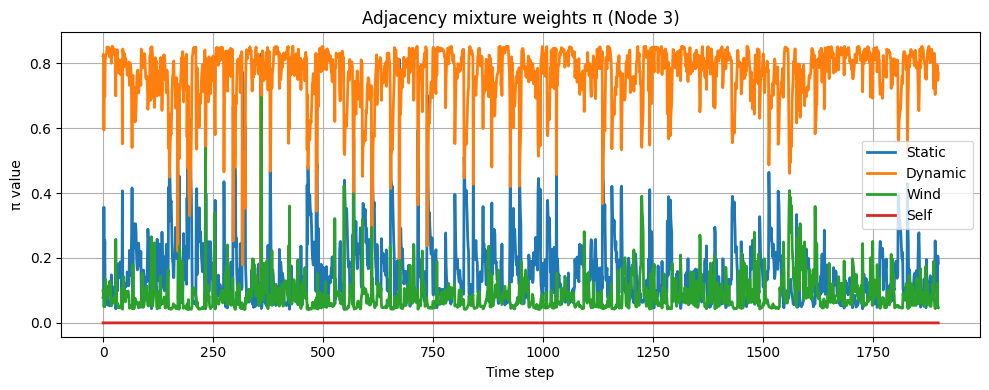

In [ ]:
# -------------------------------
# Setup
# -------------------------------
# Select portion
pi_dataset = torch.utils.data.Subset(
    test_dataset,
    range(100, 2000)
)

pi_loader = DataLoader(
    pi_dataset,
    batch_size=1,
    shuffle=False
)
checkpoint_path="/content/gdrive/MyDrive/checkpoints/train_A_W_f6416_a0_hor6.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params = list(model_copy.parameters())
params += list(gater_copy.parameters())
optimizer_dummy = torch.optim.Adam(params, lr=0.0)

load_for_evaluation(
    model_copy, Embedor_copy, gater_copy,
    optimizer_dummy,
    checkpoint_path,
    device
)

# -------------------------------
# Collect π
# -------------------------------
pi_series = collect_pi_over_loader(
    data_loader=pi_loader,   # batch_size = 1
    model=model_copy,
    Embedor=Embedor_copy,
    Gater=gater_copy,
    WindKernel=wind_adj,
    A_static=A_static1,
    device=device,
    node_idx=15,                # <-- choose node here
    temperature=1,
    topk_each=5,
    ablation_config=cfg8,
    node_const=torch.tensor(vars_geo.values,dtype=torch.float32,device=device),
)

# -------------------------------
# Plot
# -------------------------------
plot_pi_series(
    pi_series,
    ablation_config=cfg1,
    title="Adjacency mixture weights π (Node 3)"
)


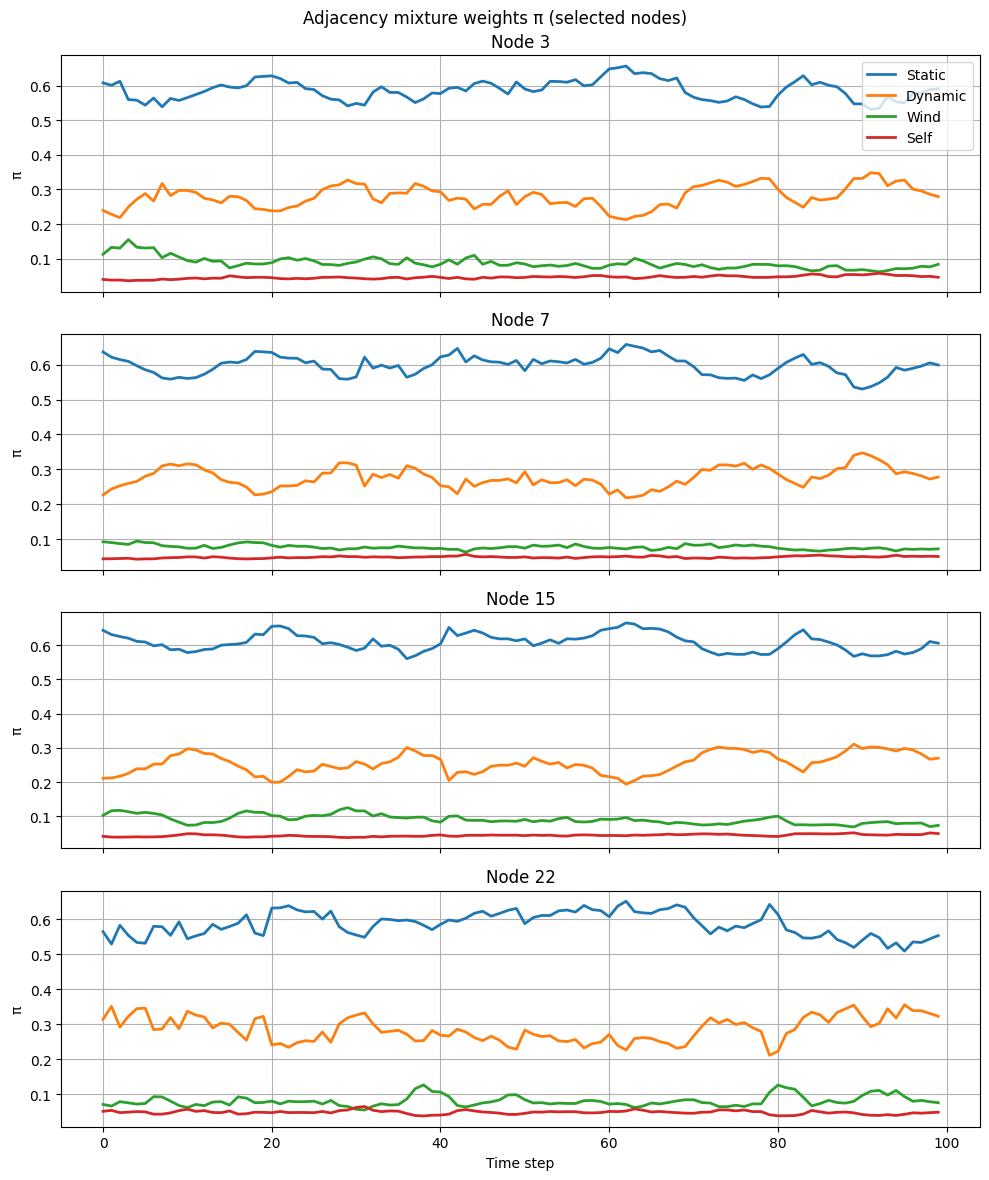

In [ ]:
@torch.no_grad()
def collect_pi_over_loader_multi_nodes(
    data_loader,
    model, Embedor, Gater, WindKernel,
    A_static,
    device,
    node_idx_list,
    temperature=0.5,
    topk_each=5,
    ablation_config=None,
    node_const=None,
):
    """
    Returns:
        pi_series: Tensor [T, K, 4]
            T = number of samples
            K = len(node_idx_list)
    """

    pi_list = []
    node_idx_list = torch.as_tensor(node_idx_list, device=device)

    A_static = A_static.to(device)

    for sample in tqdm(data_loader, desc="Collecting pi"):
        x_batch, e_batch, w_batch, g_batch, y_batch = sample

        x_batch = x_batch.to(device)
        e_batch = e_batch.to(device) if e_batch is not None else None
        w_batch = w_batch.to(device)
        g_batch = g_batch.to(device) if g_batch is not None else None

        _, aux = build_mixed_adjacency(
            e_window=e_batch,
            w_window=w_batch,
            g_window=g_batch,
            node_const=node_const,
            Gater=Gater,
            WindKernel=WindKernel,
            A_static=A_static,
            Embedor=Embedor,
            temperature=temperature,
            topk_each=topk_each,
            ablation_config=ablation_config,
        )

        # aux["pi"]: [1, N, 4]
        pi_nodes = aux["pi"][0, node_idx_list]  # [K, 4]
        pi_list.append(pi_nodes.cpu())

    return torch.stack(pi_list, dim=0)  # [T, K, 4]
def plot_pi_series_multi_nodes(
    pi_series,
    node_idx_list,
    ablation_config=None,
    title="Node-wise adjacency mixture (π)",
):
    """
    pi_series: Tensor [T, K, 4]
    """

    T, K, _ = pi_series.shape
    t = range(T)

    labels = ["Static", "Dynamic", "Wind", "Self"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    fig, axes = plt.subplots(
        K, 1, figsize=(10, 3 * K), sharex=True
    )

    if K == 1:
        axes = [axes]

    for k, ax in enumerate(axes):
        for i in range(4):
            if ablation_config is not None:
                if not ablation_config.get(
                    ["use_static", "use_dynamic", "use_wind", "use_self"][i], True
                ):
                    continue

            ax.plot(
                t,
                pi_series[:, k, i],
                label=labels[i],
                color=colors[i],
                linewidth=2
            )

        ax.set_ylabel("π")
        ax.set_title(f"Node {node_idx_list[k]}")
        ax.grid(True)

    axes[-1].set_xlabel("Time step")
    axes[0].legend(loc="upper right")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

node_idx_list = [3, 7, 15, 22]
# Select portion
pi_dataset = torch.utils.data.Subset(
    test_dataset,
    range(100, 200)
)

pi_loader = DataLoader(
    pi_dataset,
    batch_size=1,
    shuffle=False
)
checkpoint_path="/content/gdrive/MyDrive/checkpoints/train_A_W_f6416_a0_hor6.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params = list(model_copy.parameters())
params += list(gater_copy.parameters())
optimizer_dummy = torch.optim.Adam(params, lr=0.0)

load_for_evaluation(
    model_copy, Embedor_copy, gater_copy,
    optimizer_dummy,
    checkpoint_path,
    device
)

pi_series = collect_pi_over_loader_multi_nodes(
    data_loader=pi_loader,
    model=model_copy,
    Embedor=Embedor_copy,
    Gater=gater_copy,
    WindKernel=wind_adj,
    A_static=A_static1,
    device=device,
    node_idx_list=node_idx_list,
    temperature=1,
    topk_each=5,
    ablation_config=cfg1,
    node_const=torch.tensor(
        vars_geo.values, dtype=torch.float32, device=device
    ),
)

plot_pi_series_multi_nodes(
    pi_series,
    node_idx_list=node_idx_list,
    ablation_config=cfg1,
    title="Adjacency mixture weights π (selected nodes)",
)


# hyperparameters tuning

## Tier 1 (structure)

In [ ]:
# Tier1/A: Architecture screening
from itertools import product
import copy
import pandas as pd

# -------------------------
# Tier-1 hyperparameters
# -------------------------
TOPK_LIST = [4, 8, 12]

FILTER_SETS = [
    [32, 32],[64, 16],[64, 32],[64, 64],
]

GRAPH_CONFIGS = {
    "cfg1": {"use_static": True, "use_dynamic": True, "use_wind": True},
    "cfg2": {"use_static": True, "use_dynamic": True, "use_wind": False},
    "cfg3": {"use_static": True, "use_dynamic": False, "use_wind": True},
    "cfg4": {"use_static": False, "use_dynamic": True, "use_wind": True},
    "cfg5": {"use_static": False, "use_dynamic": False, "use_wind": True},
    "cfg6": {"use_static": False, "use_dynamic": True, "use_wind": False},
    "cfg7": {"use_static": True, "use_dynamic": False, "use_wind": False},
}
embed_ckpt = "/content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt"

def run_tier1_experiment(
    filters,
    topk_each,
    ablation_config,
    device,
    train_loader,
    valid_loader,
    wind_adj,
    Fx,
    embed_ckpt=embed_ckpt,
    epochs=3,          # short = structural screening
    lr=1e-3,
):
    A_static1 = topk_row (A_raw, k=topk_each, sym=False)

    # -------- Model --------
    model = RecurrentGCN(
        node_feature_dim=Fx,
        filters=filters,
        horizon=1,
        alpha=0.0,      # FIXED (Tier-2)
        dropout=0.0,    # FIXED
        mode="last",
    ).to(device)

    Embedor = load_pretrained_embedor(
        ckpt_path=embed_ckpt,
        mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool),
        device=device
    ).to(device)

    gater = GraphGateNodewise(
        in_dim=47,
        hidden=16,      # FIXED (Tier-2)
        n_graphs=3,
    ).to(device)

    # -------- Train --------
    train_joint_context_gated(
        model=model,
        Embedor=Embedor,
        Gater=gater,
        WindKernel=wind_adj,
        train_loader=train_loader,
        test_loader=None,
        device=device,
        A_static=A_static1,
        epochs=epochs,
        lr=lr,
        temperature=1,    # FIXED
        topk_each=topk_each,
        ablation_config=ablation_config,
        node_const=torch.tensor(vars_geo.values,dtype=torch.float32,device=device),
    )

    # -------- Validate --------
    metrics = evaluate_context_gated(
        model=model,
        Embedor=Embedor,
        Gater=gater,
        WindKernel=wind_adj,
        loader=valid_loader,
        A_static=A_static1,
        temperature=1,
        topk_each=topk_each,
        ablation_config=ablation_config,
        device=device,
        node_const=torch.tensor(vars_geo.values,dtype=torch.float32,device=device),
    )

    return {
        "RMSE": metrics["Global"]["RMSE"],
        "MAE":  metrics["Global"]["MAE"],
    }
# ----------------------------------execution----------------
CANONICAL_GRAPH = {
    "use_static": True,
    "use_dynamic": True,
    "use_wind": True,
}
arch_results = []
exp_id = 0

for filters, topk_each in product(FILTER_SETS, TOPK_LIST):
    exp_id += 1
    print(f"\n🧪 [ARCH] Exp {exp_id}: filters={filters}, topk={topk_each}")

    try:
        metrics = run_tier1_experiment(
            filters=filters,
            topk_each=topk_each,
            ablation_config=CANONICAL_GRAPH,
            device=device,
            train_loader=train_loader,
            valid_loader=valid_loader,
            wind_adj=wind_adj,
            embed_ckpt=embed_ckpt,
            Fx=Fx,
        )

        arch_results.append({
            "filters": str(filters),
            "n_layers": len(filters),
            "topk": topk_each,
            "RMSE": metrics["RMSE"],
            "MAE": metrics["MAE"],
        })

        print(f"✅ RMSE={metrics['RMSE']:.4f} | MAE={metrics['MAE']:.4f}")

    except RuntimeError as e:
        print(f"❌ Failed: {e}")

df_arch = pd.DataFrame(arch_results).sort_values("RMSE")
display(df_arch.head(5))
TOP_ARCHS = df_arch.head(3)



🧪 [ARCH] Exp 1: filters=[32, 32], topk=4
✅ Loaded Embedor from /content/gdrive/MyDrive/hparam_search_encoder/ed16_ch64_seed123_fold3.pt


Epoch 1/3: 100%|██████████| 759/759 [43:24<00:00,  3.43s/it]


✅ Checkpoint saved: checkpoint.pt


Epoch 2/3: 100%|██████████| 759/759 [43:29<00:00,  3.44s/it]


✅ Checkpoint saved: checkpoint.pt


Epoch 3/3: 100%|██████████| 759/759 [43:27<00:00,  3.44s/it]


✅ Checkpoint saved: checkpoint.pt


Evaluating: 0it [00:00, ?it/s]


TypeError: object of type 'NoneType' has no len()

In [ ]:
# Tier1/B: Graph combination ablation
graph_results = []
exp_id = 0

for _, row in TOP_ARCHS.iterrows():
    filters = eval(row["filters"])
    topk_each = row["topk"]

    for gname, gcfg in GRAPH_CONFIGS.items():
        exp_id += 1
        print(f"\n🧪 [GRAPH] Exp {exp_id}: {filters}, topk={topk_each}, graph={gname}")

        try:
            metrics = run_tier1_experiment(
                filters=filters,
                topk_each=topk_each,
                ablation_config=gcfg,
                device=device,
                train_loader=train_loader,
                valid_loader=valid_loader,
                wind_adj=wind_adj,
                embed_ckpt=embed_ckpt,
                Fx=Fx,
            )

            graph_results.append({
                "filters": str(filters),
                "topk": topk_each,
                "graph": gname,
                "RMSE": metrics["RMSE"],
                "MAE": metrics["MAE"],
            })

            print(f"✅ RMSE={metrics['RMSE']:.4f}")

        except RuntimeError as e:
            print(f"❌ Failed: {e}")
df_graph = pd.DataFrame(graph_results).sort_values(["filters", "RMSE"])
display(df_graph)


## Tier 2 (stability,generalization)

In [ ]:
# randomness
TIER2_CONFIG = {
    "filters": filters_star,
    "topk_each": topk_star,
    "ablation_config": graph_star,
}

SEEDS = [1, 3, 5]
results = []

for seed in SEEDS:
    set_seed(seed)

    metrics = run_tier2_experiment(
        **TIER2_CONFIG,
        device=device,
        train_loader=train_loader,
        valid_loader=valid_loader,
        wind_adj=wind_adj,
        embed_ckpt=embed_ckpt,
        Fx=Fx,
        epochs=40,
        dropout=0.1,
        alpha=0.2,
    )

    results.append({
        "seed": seed,
        "RMSE": metrics["RMSE"],
        "MAE": metrics["MAE"],
    })


In [ ]:
# tuning Alpha
TIER2B_SEED = 123
set_seed(TIER2B_SEED)
ALPHA_LIST = [0.0, 0.05, 0.1, 0.2]

alpha_results = []

for alpha in ALPHA_LIST:
    print(f"\n🔎 Tier-2/B α={alpha}")

    metrics = run_tier2_experiment(
        filters=filters_star,
        topk_each=topk_star,
        ablation_config=graph_star,
        alpha=alpha,
        dropout=0.0,
        epochs=40,
        device=device,
        train_loader=train_loader,
        valid_loader=valid_loader,
        wind_adj=wind_adj,
        Fx=Fx,
    )

    alpha_results.append({
        "alpha": alpha,
        "RMSE": metrics["RMSE"],
        "MAE":  metrics["MAE"],
    })
alpha_star = min(alpha_results, key=lambda x: x["RMSE"])["alpha"]


In [ ]:
DROPOUT_LIST = [0.0, 0.1, 0.2, 0.3]

dropout_results = []

for dropout in DROPOUT_LIST:
    print(f"\n🔎 Tier-2/B dropout={dropout}")

    metrics = run_tier2_experiment(
        filters=filters_star,
        topk_each=topk_star,
        ablation_config=graph_star,
        alpha=alpha_star,
        dropout=dropout,
        epochs=40,
        device=device,
        train_loader=train_loader,
        valid_loader=valid_loader,
        wind_adj=wind_adj,
        Fx=Fx,
    )

    dropout_results.append({
        "dropout": dropout,
        "RMSE": metrics["RMSE"],
        "MAE":  metrics["MAE"],
    })
dropout_star = min(dropout_results, key=lambda x: x["RMSE"])["dropout"]


## Tier 3 (Fine Tuning)

In [ ]:
import os, random, numpy as np
import torch
import pandas as pd

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@torch.no_grad()
def gate_diagnostics_from_loader(
    loader, Embedor, Gater, WindKernel, A_static, device,
    temperature=1.0, topk_each=8, ablation_config=None, node_const=None
):
    """
    Runs adjacency building only, collects gate diagnostics on pi.
    Returns: dict with entropy_mean, maxpi_mean.
    """
    Gater.eval(); Embedor.eval()
    entropies = []
    maxpis = []

    for sample in loader:
        x_batch, e_batch, w_batch, g_batch, y_batch = sample
        e_batch = e_batch.to(device) if e_batch is not None else None
        w_batch = w_batch.to(device)
        g_batch = g_batch.to(device) if g_batch is not None else None

        _, aux = build_mixed_adjacency(
            e_window=e_batch,
            w_window=w_batch,
            g_window=g_batch,
            node_const=node_const,
            Gater=Gater,
            WindKernel=WindKernel,
            A_static=A_static.to(device),
            Embedor=Embedor,
            temperature=temperature,
            topk_each=topk_each,
            ablation_config=ablation_config,
        )
        pi = aux["pi"]  # [B,N,G]
        # entropy per node: -sum p log p
        ent = -(pi.clamp_min(1e-12) * torch.log(pi.clamp_min(1e-12))).sum(-1)  # [B,N]
        entropies.append(ent.mean().item())
        maxpis.append(pi.max(dim=-1).values.mean().item())

    return {
        "pi_entropy_mean": float(np.mean(entropies)) if entropies else None,
        "pi_max_mean": float(np.mean(maxpis)) if maxpis else None,
    }
def run_tier3_experiment(
    *,
    # ----- fixed (Tier-1/Tier-2 outputs) -----
    filters, topk_each, ablation_config,
    alpha, dropout,
    Fx,
    device,
    train_loader, valid_loader,
    wind_adj,
    A_raw,           # your raw static adjacency before topk
    masks,
    vars_geo,        # node_const source
    embed_ckpt,

    # ----- tier-3 knobs -----
    gater_hidden=16,
    tau=1.0,
    learn_tau=False,
    lambda_cf=0.05,
    lambda_align=0.01,
    huber_delta=20.0,
    dyn_temperature=1.0,  # this maps to build_mixed_adjacency(temperature=...)
    epochs=40,
    lr=1e-3,
    seed=123,
):
    set_seed(seed)

    # Static adjacency sparsified with same k as mixing
    A_static = topk_row(A_raw, k=topk_each, sym=False).to(device)

    # Node constants
    node_const = torch.tensor(vars_geo.values, dtype=torch.float32, device=device)

    # Load frozen Embedor (per run for isolation; you can also load once outside)
    Embedor = load_pretrained_embedor(
        ckpt_path=embed_ckpt,
        mask_cloud=torch.tensor(masks["mask_cloud"], dtype=torch.bool),
        device=device
    ).to(device)

    # Build model
    model = RecurrentGCN(
        node_feature_dim=Fx,
        filters=filters,
        horizon=1,
        alpha=alpha,        # fixed from Tier-2
        dropout=dropout,    # fixed from Tier-2
        mode="last",
    ).to(device)

    # Build gater (IMPORTANT: n_graphs=4 if you mix static/dyn/wind/self)
    gater = GraphGateNodewise(
        in_dim=47,
        hidden=gater_hidden,
        n_graphs=4,
        tau=tau,
        learn_tau=learn_tau,
    ).to(device)

    # ---- Patch loss weights & huber delta into your train function ----
    # Easiest: temporarily wrap train_joint_context_gated to use your desired delta and weights.
    # We'll re-implement only the few lines that differ by copying your function and changing:
    #   loss_fn = nn.HuberLoss(delta=huber_delta)
    #   loss = loss_pred + lambda_cf * L_cf + lambda_align * L_align
    #
    # If you don’t want to duplicate code, edit your train_joint_context_gated() signature
    # to accept huber_delta, lambda_cf, lambda_align.

    train_joint_context_gated(
        model=model,
        Embedor=Embedor,
        Gater=gater,
        WindKernel=wind_adj,
        train_loader=train_loader,
        test_loader=None,
        device=device,
        A_static=A_static,
        epochs=epochs,
        lr=lr,
        temperature=dyn_temperature,
        topk_each=topk_each,
        ablation_config=ablation_config,
        node_const=node_const,
        # ---- you must add these args in your function or hardcode inside ----
        # huber_delta=huber_delta,
        # lambda_cf=lambda_cf,
        # lambda_align=lambda_align,
    )

    # Validate
    metrics = evaluate_context_gated(
        model=model,
        Embedor=Embedor,
        Gater=gater,
        WindKernel=wind_adj,
        loader=valid_loader,
        A_static=A_static,
        temperature=dyn_temperature,
        topk_each=topk_each,
        ablation_config=ablation_config,
        device=device,
        node_const=node_const,
    )

    # Gate diagnostics (optional but recommended in Tier-3)
    diag = gate_diagnostics_from_loader(
        loader=valid_loader,
        Embedor=Embedor,
        Gater=gater,
        WindKernel=wind_adj,
        A_static=A_static,
        device=device,
        temperature=dyn_temperature,
        topk_each=topk_each,
        ablation_config=ablation_config,
        node_const=node_const,
    )

    out = {
        "RMSE": metrics["Global"]["RMSE"],
        "MAE": metrics["Global"]["MAE"],
        **diag,
    }
    return out


# Results

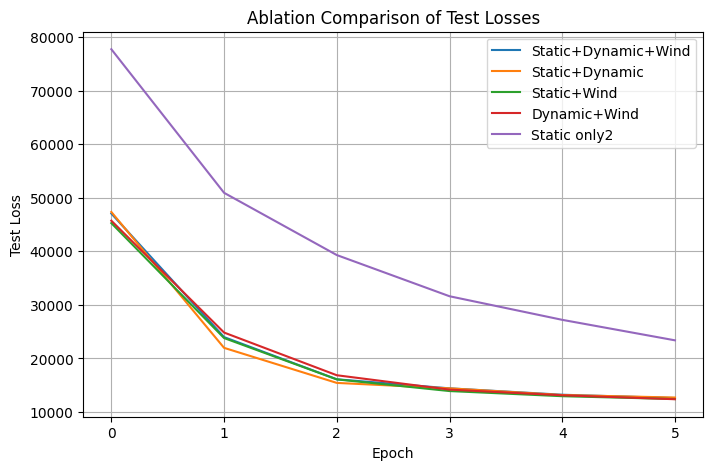

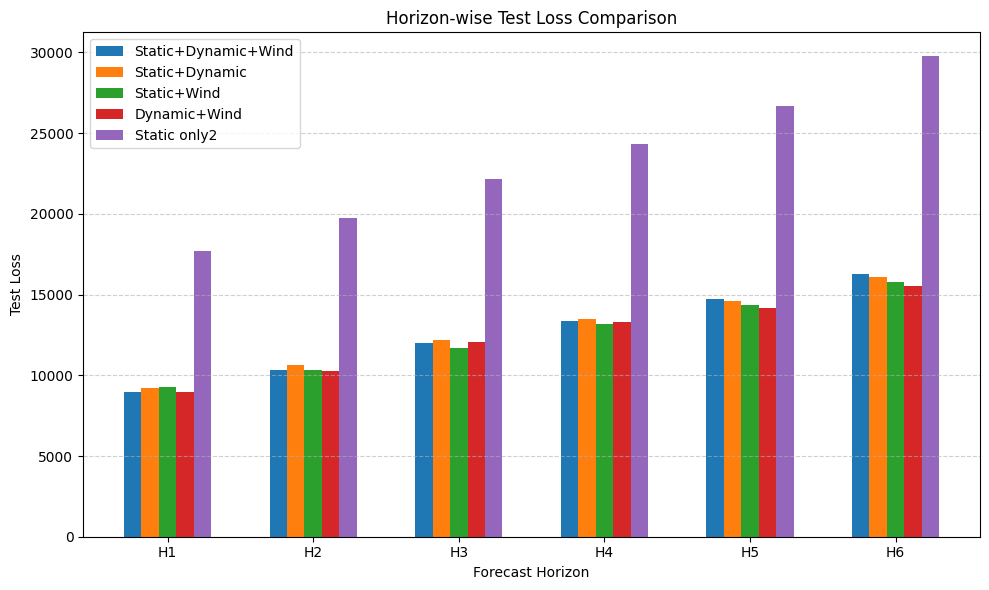

In [ ]:
import matplotlib.pyplot as plt
# --- List of your checkpoint files ---
checkpoints = {
    "Static+Dynamic+Wind": "train_A_SDW.pt",
    "Static+Dynamic":      "train_A_SD.pt",
    "Static+Wind":         "train_A_SW.pt",
    "Dynamic+Wind":        "train_A_DW.pt",
    #"Wind only":           "train_A_W.pt",
    #"Dynamic only":        "train_A_D.pt",
    #"Static only":         "train_A_S.pt",
    "Static only2":         "train_A_S2.pt"
}

results_dir = "/content/gdrive/MyDrive/checkpoints"

all_histories = {}
horizon_results = {}
# --- Load each checkpoint and extract losses ---
for label, fname in checkpoints.items():
    path = os.path.join(results_dir, fname)
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue

    ckpt = torch.load(path, map_location="cpu")

    # adjust if your training function stores them under a dict
    test_losses = ckpt.get("test_losses", None)

    if test_losses is None:
        print(f"⚠️ No test_losses in {fname}, keys: {list(ckpt.keys())}")
        continue

    all_histories[label] = test_losses

    horizon_losses = ckpt.get("test_avg_horizon_losses_history", None)
    if horizon_losses is None:
        print(f"⚠️ No horizon losses in {fname}, keys: {list(ckpt.keys())}")
        continue
    final_losses = horizon_losses[-1]  # shape: [horizon]
    horizon_results[label] = final_losses

# --- Plot ---
plt.figure(figsize=(8,5))
for label, losses in all_histories.items():
    plt.plot(losses, label=label)

plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Ablation Comparison of Test Losses")
plt.legend()
plt.grid(True)
plt.show()

# --- Bar plot per horizon ---
if horizon_results:
    labels = list(horizon_results.keys())
    horizons = range(1, len(next(iter(horizon_results.values()))) + 1)
    x = np.arange(len(horizons))  # horizon indices
    width = 0.12                  # bar width

    plt.figure(figsize=(10,6))

    for i, (label, losses) in enumerate(horizon_results.items()):
        plt.bar(x + i*width, losses, width, label=label)

    plt.xticks(x + width*(len(labels)-1)/2, [f"H{h}" for h in horizons])
    plt.ylabel("Test Loss")
    plt.xlabel("Forecast Horizon")
    plt.title("Horizon-wise Test Loss Comparison")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Forecasting

In [ ]:
def prepare_sample(t0, lags, horizon, temporal_node_tensor, temporal_target_tensor, masks, device):
    N = temporal_node_tensor.shape[1]

    # Forecast features
    x_seq_full = torch.tensor(temporal_node_tensor[t0:t0+lags, :, masks["mask_forecast"]])
    x_seq = x_seq_full[..., :-1].permute(1,0,2).reshape(N,-1).float().to(device)

    # Embedding features
    e_seq_full = torch.tensor(temporal_node_tensor[t0:t0+lags, :, masks["mask_embed"]])
    e_seq = e_seq_full[..., :-1].permute(1,0,2).reshape(N,-1).float().to(device)

    # Wind
    w_seq = torch.tensor(temporal_node_tensor[t0:t0+lags, :, masks["mask_wind"]])
    w_seq = w_seq.permute(1,0,2).reshape(N,-1).float().to(device)

    # Global
    g_seq = torch.tensor(temporal_node_tensor[t0:t0+lags, :, masks["mask_global"]])
    g_seq = g_seq.permute(1,0,2).reshape(N,-1).float().to(device)

    # Targets (ground truth)
    y_seq = torch.tensor(temporal_target_tensor[t0+lags:t0+lags+horizon])
    y_seq = y_seq.permute(1,0).float().to(device)   # [N, horizon]

    return x_seq, e_seq, w_seq, g_seq, y_seq
#preparing sample
model_copy.eval()
Embedor_copy.eval()
gater_copy.eval()
WindKernel.train(False)
# --- 2. Load checkpoint ---
ckpt_path = "/content/gdrive/MyDrive/checkpoints/train_A_S.pt"
checkpoint = torch.load(ckpt_path, map_location=device)

# --- 3. Restore weights ---
model_copy.load_state_dict(checkpoint["model_state"])
Embedor_copy.load_state_dict(checkpoint["embed_state"])
gater_copy.load_state_dict(checkpoint["gater_state"])

with torch.no_grad():
    # 1) Prepare one sample
    x, e, w, g, y_true = prepare_sample(
        t0=15000,  # pick any index
        lags=lags, horizon=horizon,
        temporal_node_tensor=temporal_node_tensor,
        temporal_target_tensor=temporal_target_tensor,
        masks=masks,
        device=device
    )

    # 2) Build adjacency for this sample
    A_t, cache = build_mixed_adjacency(
        e, w, g,
        Embedor_copy, gater_copy, WindKernel,
        A_static.to(device),
        temperature=0.5,
        emb_size=e_size,
        topk_each=5,
        ablation_config=cfg3
    )
    edge_index, edge_weight = dense_to_sparse(A_t)

    # 3) Forward pass through model
    y_pred = model_copy(x, edge_index, edge_weight)   # [N, horizon]

import matplotlib.pyplot as plt
import math

def scatter_all_horizons(y_true, y_pred, alpha=0.3, cols=3):
    """
    Plot scatter of ground truth vs prediction for ALL horizons.

    y_true: [N, horizon]
    y_pred: [N, horizon]
    cols:   number of subplots per row
    """
    num_horizons = y_true.shape[1]
    rows = math.ceil(num_horizons / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    axes = axes.flatten()

    for h in range(num_horizons):
        real = y_true[:, h].cpu().numpy()
        pred = y_pred[:, h].cpu().numpy()

        ax = axes[h]
        ax.scatter(real, pred, alpha=alpha, s=10)
        lims = [min(real.min(), pred.min()), max(real.max(), pred.max())]
        ax.plot(lims, lims, "r--", linewidth=1.5)
        ax.set_title(f"Horizon {h+1}")
        ax.set_xlabel("Ground Truth")
        ax.set_ylabel("Prediction")
        ax.grid(True, linestyle="--", alpha=0.6)

    # hide unused axes if horizons not divisible by cols
    for i in range(num_horizons, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
scatter_all_horizons(y_true, y_pred, alpha=0.3, cols=3)

# Comparing Architectures